# Programmieren 2 Projekt Diabetes Health Indicators (Gruppe 7)

# 0. Vorbereitung

## 0.1 externe Bibliotheken installieren

In [ ]:
# %pip install missingno
# %pip install tensorflow
# %pip install tensorflow-addons
# pip install xgboost
# %pip install imbalanced-learn
# !pip install imblearn

## 0.2 Bibliotheken, Funktionen und Klassen importieren

In [1]:
# Bibliotheken
import base64
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

# Allgemein
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_ib

# Data Preparation
from sklearn.preprocessing import OneHotEncoder

# Feature Selection
from sklearn.feature_selection import RFE, RFECV, SelectKBest, SelectPercentile, f_classif, chi2, mutual_info_classif

# Feature Scaling 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Datensatz aufsplitten
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split

# Over-/ Undersampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modelling - Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

# Modelling - Deep Learning
from tensorflow import keras
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay, auc 
from sklearn.model_selection import cross_val_score, cross_validate
# import copy as cp
from scipy.stats.mstats import gmean

## 0.3 Datensatz aus OneDrive einlesen
Der Datensatz wird aus OneDrive eingelesen. 

In [2]:
# Funktion, die einen Downloadlink zum Onedrive-Ordner erstellt 
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

# Multiclass-Datensatz einlesen
df_multiclass = pd.read_csv(create_onedrive_directdownload("https://1drv.ms/u/s!Ai0ffDmeM0ho1FNrZ1ho6d2NZqUV?e=MDLRDb"),sep=",", engine="python")

##### Quellen zum Code

Erstellung des Downloadlinks zu OneDrive: *https://towardsdatascience.com/onedrive-as-data-storage-for-python-project-2ff8d2d3a0aa*

## 0.4 binären Datensatz erstellen

In [3]:
# Initialisierung des binären Datensatzes
df = df_multiclass

# Gruppen 1 und 2 (Prediabetes und Diabetes) zusammenfassen
df['Diabetes_012'].replace({2:1}, inplace=True)

# Targetvariable umbenennen 
df.rename(columns={'Diabetes_012': 'Diabetes'}, inplace=True)

# 1. Business Understanding

## 1.1 Problemstellung

## 1.2 Ziel des Projekts

## 1.3 Kritische Faktoren

## 1.4 Vorgehen bei der Projektarbeit

### 1.4.1 Projektmanagement-Tools

#### 1.4.1.1 Projektstrukturplan

#### 1.4.1.2 GANTT-Diagramm

#### 1.4.1.3 Organisation der Arbeit und verwendete Tools 

# 2. Data Understanding

In [ ]:
# print(df_large.shape)
# print(df_large.columns)

## 2.1 Variablen und Skalenniveaus

Die Erklärung der Variablen des Datensatzes sind in der Beschreibung auf Kaggle bzw. in den Kommentaren zu finden. Zur Validierung der in Kaggle angegebenen Dokumentation kann der "Codebook Report" des Behavioral Risk Factor Surveillance System aus dem Jahr 2015 verwendet werden. Dieser beinhaltet eine Beschreibung des unbereinigten Datensatzes mit mehr als 300 Features. Da die Features beim Bereinigen zum Teil umbenannt wurden, ist es hilfreich, das Jupyter Notebook, das für die Bereinigung des großen Datensatzes erstellt wurde und auf Kaggle zu finden ist, hinzuzuziehen.

##### Quellen

Link zum Datensatz (Kaggle): *https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset*

2015 Codebook Report (BRFSS): *https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf*

Link zum unbereinigten Datensatz: *https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system*

Link zum Jupyer Notebook zur Bereinigung: *https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook*

In [4]:
# Ausgabe der Variablennamen
df.columns

Index(['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

### 2.1.1 Features

#### demographische Features:
**Sex**: nominalskaliert (kategorisch); 0 = weiblich, 1 = männlich

**Age**: ordinalskaliert (kategorisch); 1 = 18-24 Jahre alt, 2 = 25-29 Jahre alt, 3 = 30 bis 34 Jahre alt, 4 = 35 - 39 Jahre alt, 5 = 40 bis 44 Jahre alt, 6  = 45 - 49 Jahre alt, 7 = 50 - 54 Jahre alt, 8 = 55 - 59 Jahre alt, 9 = 60 - 64 Jahre alt, 10 = 65 - 69 Jahre alt, 11 = 70 - 74 Jahre alt, 12 = 75 - 79 Jahre alt, 13 = 80 oder älter

**Education**: ordinalskaliert (kategorisch); 1 = Kindergarten, 2 = Grundschule (Elementary School, Grade 1 through 8), 3 = Some High School  (Grade 9 through 11), 4 = High School Degree (Grade 12 or GED), 5 = College 1 year to 3 years (Some college or technical school), 6 = College 4 Years or more (College graduate)

**Income**: ordinalskaliert (kategorisch); 1 = < 10000 USD Einkommen, 2 = 10000 - 15000 USD , 3 = 15000 - 20000 USD, 4 = 20000 - 25000 USD, 5 = 25000 - 35000 USD, 6 = 35000 - 50000 USD, 7 = 50000 - 75000 USD, 8 = 75000+ USD

#### medizinische Features:
**HighBP**: nominalskaliert (kategorisch); 0 = kein hoher Blutdruck, 1 = hoher Blutdruck

**HighCol**: nominalskaliert (kategorisch); 0 = kein hoher Cholesterinspiegel, 1 = hoher Cholesterinspiegel

**CholCheck**: nominalskaliert (kategorisch); 0 = kein Cholesterincheck in den letzten 5 Jahren, 1 = Cholesterincheck in den letzten 5 Jahren

**HeartDieseaseorAttack**: nominalskaliert (kategorisch); 0 = keine Herzkrankheit oder Herzinfarkt, 1 = Herzkrankheit oder Herzinfarkt

**BMI**: intervallskaliert (numerisch), [kg/m²]

**Stroke**: nominalskaliert (kategorisch); 0 = noch keinen Schlaganfall gehabt, 1 = Schlaganfall gehabt 

**AnyHealthCare**: nominalskaliert (kategorisch); 0 = keine Krankenversicherung, 1 = Krankenversicherung (bezogen auf USA)

**NoDocbcCost**: nominalskaliert (kategorisch); 0 = konnte in den letzten 12 Monaten immer zum Doktor gehen, 1 = in den letzten 12 Monaten 
Doktor gebraucht aber nicht leisten können (bezogen auf USA)

**GenHlth**: ordinalskaliert (kategorisch); genereller Gesundheitsstatus: 1 = exzellent, 2 = sehr gut, 3 = gut, 4 = in Ordnung, 5 = schlecht

**MenHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem mental nicht gut ging (Stress, Depression, emotionale Probleme) 

**PhysHlth**: intervallskaliert (numerisch); Anzahl der Tage in den letzten 30 Tagen, an denen es einem körperlich nicht gut ging (körperliche Krankheit, Verletzung)

**DiffWalk**: nominalskaliert (kategorisch); 0 = keine Schwierigkeiten beim Laufen, 1 = Schwierigkeiten beim Laufen

#### "Lifestyle" Features:

**Fruits**: nominalskaliert (kategorisch); 0 = isst weniger als eine Frucht pro Tag, 1 = isst eine oder mehr Früchte pro Tag

**Veggies**: nominalskaliert(kategorisch); 0 = isst weniger als ein Gemüse pro Tag, 1 = isst eine oder mehr Gemüse pro Tag

**HvyAlcoholConsump**: nominalskaliert (kategorisch); 0 = weniger als 14 Drinks (7 bei Frauen) pro Woche, 1 = mehr als 14 Drinks (7 bei Frauen) pro Woche

**Smoker**: nominalskaliert (kategorisch); 0 = nicht mehr als 100 Zigaretten im Leben geraucht, 1 = mehr als 100 Zigaretten im Leben geraucht

**PhysActivity**: nominalskaliert (kategorisch); 0 = keine körperliche Aktivität in den letzten 30 Tagen, 1 = körperliche Aktivität in den letzten 30 Tagen

### 2.1.2 Target

**Diabetes**: nominalskaliert (kategorisch); 0 = gesund, 1 = krank

## 2.1.3 Variablen umbenennen

Die meisten Variablen des Datensatzes werden bereits durch ihre Namen ausreichend erklärt. Trotzdem gibt es ein paar Variablen, bei denen es zum vollständigen Verständnis der Bedeutung noch einer zusätzlichen Erläuterung bedarf. Diese werden **direkt zu Beginn** passend umbenannt, damit **später im Code**, nach der Umbennenung, **keine Probleme** auftreten.

In [4]:
# Umbenennung des Features 'gender_male'
df.rename(columns = {'Sex': 'Gender_male'}, inplace = True)
# Ausgabe der neuen Variablennamen
df.columns

Index(['Diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Gender_male', 'Age', 'Education',
       'Income'],
      dtype='object')

Damit die Variable eine größere Aussagekraft hat, wurde das Feature **'Sex' in 'Gender_male'** umbenannt. Ist hier der Wert 0, handelt es sich um einen weiblichen Patienten, ist der Wert 1 handelt es sich um einen männlichen.

## 2.2 Einblick in den  Datensatz

### 2.2.1 grundlegende Informationen über den Datensatz

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes              253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

### 2.2.1 Anzeige der ersten Zeilen

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 2.2.2 Anzeige der letzten Zeilen

In [8]:
df.tail()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,2.0


### 2.2.3 Größe des Datensatzes

In [9]:
print(f'Der Datensatz hat {df.shape[0]} Zeilen und {df.shape[1]} Spalten.')

Der Datensatz hat 253680 Zeilen und 22 Spalten.


### 2.2.4 Anzahl der einzigartigen Werte pro Feature

In [10]:
df.nunique()

Diabetes                 2
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Gender_male              2
Age                     13
Education                6
Income                   8
dtype: int64

## 2.3 Deskriptive Statistik im Datensatz

In [18]:
df.describe()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.157588,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.364355,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


##### Interpretation - Deskriptive Statistik im Datensatz

Die obige Tabelle gibt einen ersten Einblick in die Verteilung der Variablenausprägungen im Datensatz. Da die meisten der Variablen binär sind und die nicht binären Variablen einen relativ kleinen (ganzzahligen) Wertebereich haben, gibt es hier bei der ersten Betrachtung der Minimal- und Maximalwerte kaum Unstimmigkeiten. Lediglich beim Feature BMI gibt es unplausible Werte, die aber in einem späteren Kapitel nochmals näher beleuchtet werden.

## 2.4 Klassenverteilung im Datensatz bezüglich der Zielvariable

In [19]:
Diabetes_valuecount = df['Diabetes'].value_counts()
Diabetes_valuecount

0.0    213703
1.0     39977
Name: Diabetes, dtype: int64

### 2.4.1 Visualisierung - Klassenverteilung im Datensatz

Zur Visualisierung der Klassenverteilung im Datensatz bezüglich der Targetvariable 'Diabetes_012' wird im Folgenden ein **Pieplot** mittels der pie()-Funktion aus der matplotlib-library erstellt.

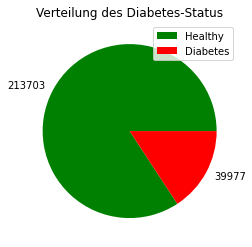

In [20]:
# Erzeugung eines Kreisdiagramms zur Klassenverteilung im Datensatz
%matplotlib inline
labels = ['Healthy', 'Diabetes']
plt.pie(Diabetes_valuecount, labels=Diabetes_valuecount, colors=['green', 'red'])
plt.legend(labels)
plt.title('Verteilung des Diabetes-Status')
plt.show()

### 2.4.2 Ergebnis (absolute Werte) - Klassenverteilung im Datensatz 
Der Datensatz ist **unausgewogen**. Das bedeutet, dass eine Klasse des Datensatzes gegenüber den anderen deutlich über-/unterrepräsentiert ist.

**213703 Personen** im Datensatz haben kein Diabetes, **39977 Personen** haben Diabetes.

### 2.4.3 Ergebnis (prozentualer Anteil) - Klassenverteilung im Datensatz

In [14]:
# Funktion zur Berechnung der prozentualen Klassenverteilung im Datensatz
def calc_prozentual_target(df):
    # Shape 
    df_diab0 = df.loc[df['Diabetes'] == 0.0]
    df_diab1 = df.loc[df['Diabetes'] == 1.0]

    df_diab0_count = df_diab0.shape[0]
    df_diab1_count = df_diab1.shape[0]

    df_diab0_perc = round((df_diab0_count/df.shape[0])*100, 3)
    df_diab1_perc = round((df_diab1_count/df.shape[0])*100, 3)
    
    diabetes_perc_list = [df_diab0_perc, df_diab1_perc]
    
    return diabetes_perc_list

In [15]:
# Ausgabe der prozentualen Klassenverteilung im vollständigen binären Datensatz
diabetes_perc_df = calc_prozentual_target(df)
print(f'Der vollständige Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten {diabetes_perc_df[1] }% Patienten mit Diabetes.')

Der vollständige Datensatz enthält 84.241 % gesunde Patienten 15.759% Patienten mit Diabetes.


## 2.5 Fehlende Werte

Zur Visualisierung möglicher fehlender Werte im Datensatz wird eine **Missing-Data-Matrix** mithilfe der missingno-Bibliothek erstellt. Diese besteht aus schwarzen Balken für die jeweiligen Variablen. Mögliche fehlende Werte wären durch weiße Striche in den Balken gekennzeichnet.

##### Visualisierung - Fehlende Werte

<AxesSubplot:>

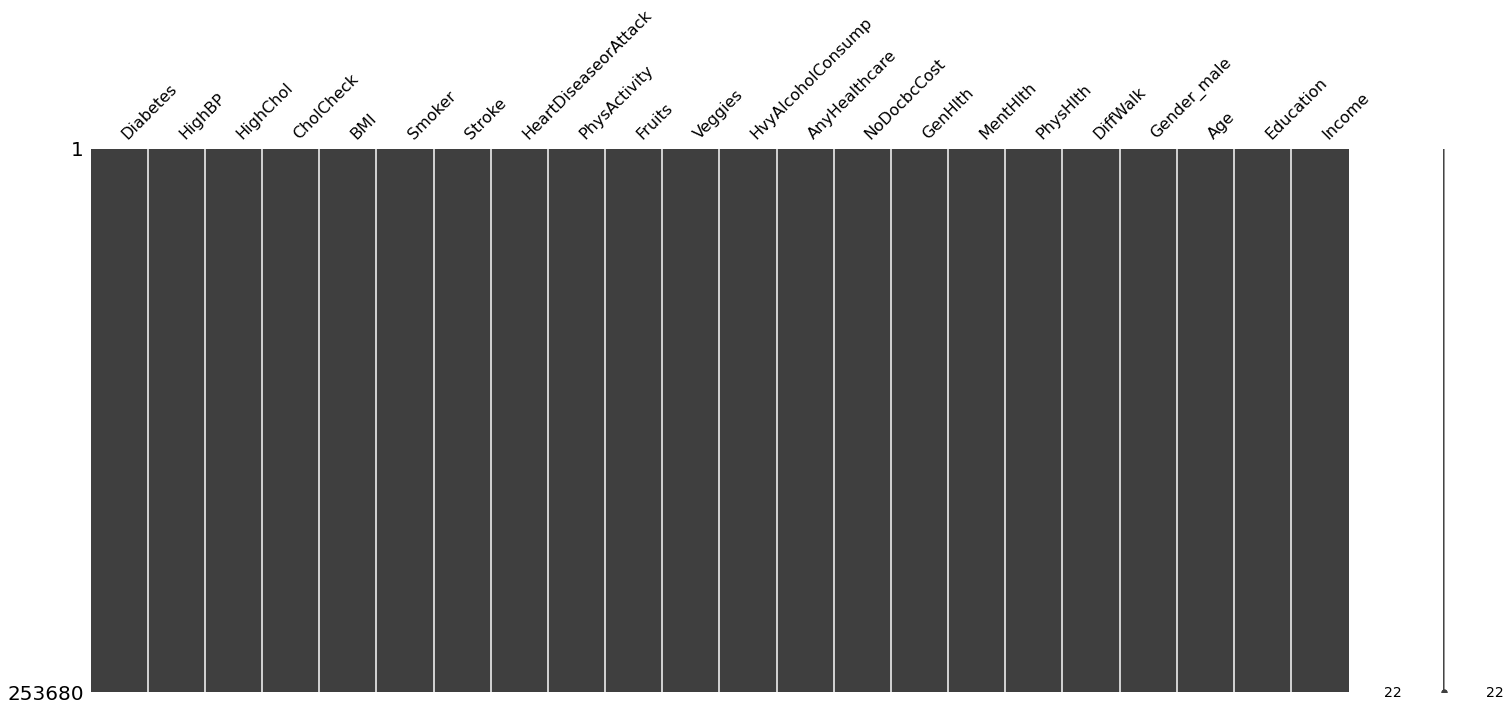

In [16]:
# Ausgabe der missingno-Matrix für fehlende Werte
%matplotlib inline
msno.matrix(df)

##### Ergebnis - Fehlende Werte

In [17]:
print(f'Der Datensatz enthält {df.isnull().sum().sum()} fehlende Werte.')

Der Datensatz enthält 0 fehlende Werte.


Dies ist bereits in der Infotabelle unter Kapitel 2.2.1 zu erkennen, da bei keiner Variable die Anzahl von "non-null"-Werten von der Gesamtgröße des Datensatzes abweicht. In Kapitel 2.5.1 wird dies durch die graphische Veranschaulichung nochmals bestätigt. 

Da es sich beim Datensatz um einen **bereits bereinigten Datensatz** aus Kaggle handelt, war dies bereits zu erwarten. Aufgrund der Vollständigkeit des Datensatzes ist eine weitere Behandlung möglicher fehlender Werte in Kap. 3 (Data Preparation) überflüssig.  

## 2.6 Explorative Analyse des Datensatzes

### 2.6.1 Visualisierung der mindestens ordinalskalierten Features in Abhängigkeit des Diabetesstatus
Um eine erste Idee vom Datensatz und möglichen **Ausreißern** bei den Features zu bekommen, wird jeweils ein **Boxplot** für jede nicht binäre Variable erstellt. Die Voraussetzung, um einen Boxplot berechnen zu können, ist eine Variable, die **mindestens Ordinalskalen-Niveau** hat. Zur Erstellung der Boxplots wird die boxplot()-Funktion aus der seaborn-library verwendet.

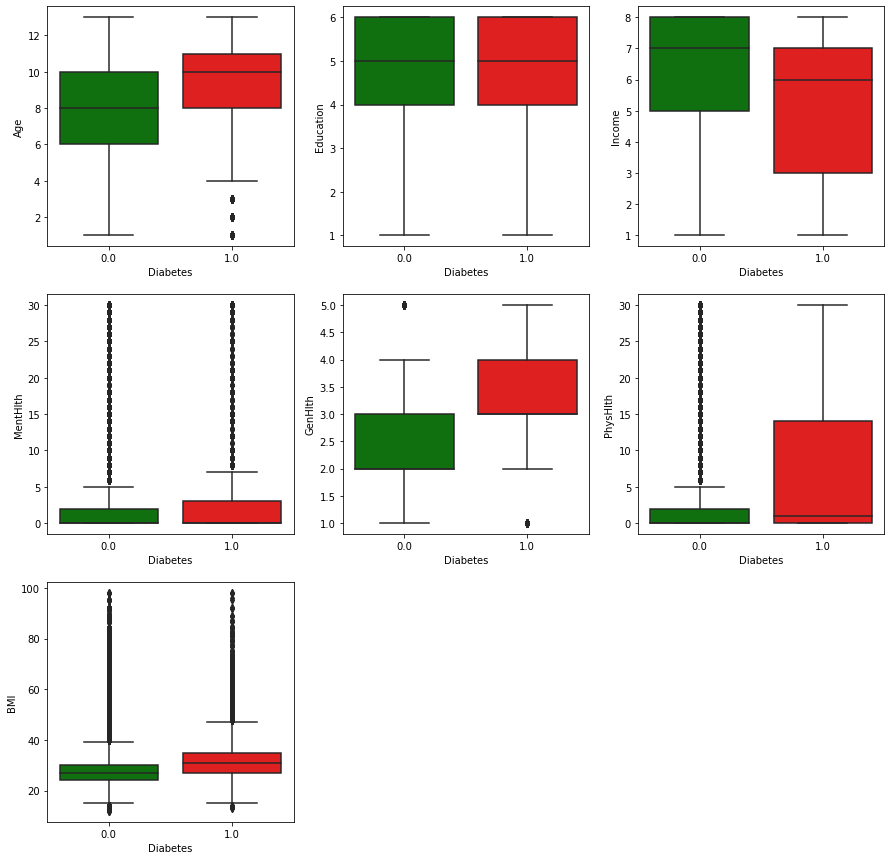

In [22]:
# Erstellung von Boxplots zur Visualisierung von mindestens ordinalskalierten Features 
%matplotlib inline

# Liste mit mindestens ordinalskalierten Features
features_boxplots = ['Age', 'Education', 'Income', 'MentHlth', 'GenHlth', 'PhysHlth', 'BMI']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

row_count = 0
col_count = 0

# For-Schleife zur Ausgabe der einzelnen Subplots (Boxplots)
for feature in features_boxplots:
    sns.boxplot(ax=axes[row_count, col_count], data=df, x='Diabetes', y=feature, palette=['Green', 'Red'])
    col_count += 1
    if col_count > 2:
        row_count += 1
        col_count = 0

# Entfernen von Subplot 8 und 9, da nur 7 Features geplottet werden sollen         
fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])

##### Interpretation - Boxplots

Die Betrachtung der obigen Boxplots liefert einige **Erkenntnisse**, die später bei der **Feature Selection** zur zusätzlichen Validierung der Ergebnisse nützlich sein können. So ist beispielsweise zu erkennen, dass beim Feature **'BMI'** ein Zusammenhang zwischen der Ausprägung und dem Diabetesstatus vorhanden ist. Ein weiterer Punkt, der hier auffällig wird, sind unplausible Werte in Bezug auf den BMI der Patienten. Diese werden in Kapitel 3.1.2 nochmals näher beleuchtet und aus dem Datensatz entfernt. Neben dem BMI, lassen die Boxplots auch auf einen Zusammenhang des **Alters** mit dem Diabetesstatus schließen. Beim Feature **'Income'** scheint es eine Art negativen Zusammenhang zwischen dem Einkommen eines Patienten und dem Diabetesstatus geben, was bedeutet, dass Leute mit Diabetes anscheinend etwas weniger verdienen. Darüber hinaus gibt es auch beim Feature **'GenHlth'** einen erkennbaren Zusammenhang zwischen der generellen Gesundheit eines Patienten und dem Diabetesstatus, wobei hierbei berücksichtigt werden muss, dass es sich hierbei um ein Feature handelt, deren Ausprägung auf individuellem, subjektivem Empfinden ohne medizinische Grundlage beruht. Während beim Feature **'PhysHlth'** auch noch ein visueller Zusammenhang mit dem Diabetesstatus vorliegt, scheint die mentale Gesundheit (MentHlth) und die Bildung (Education) eines Patienten nicht bzw. nur geringfügig mit dem Diabetesstatus zusammenzuhängen.

Obwohl eine starke Unbalanciertheit der Daten bezüglich des Diabetesstatus vorliegt, was bei der Interpretation dieser Werte auf jeden Fall beachtet werden muss, sollte man diese Erkenntnisse **für die spätere Feature Selection** im Hinterkopf behalten.

##### Quellen

Skalenniveau bei Boxplots: *https://www.statistikpsychologie.de/boxplot/#:~:text=Die%20Voraussetzung%2C%20um%20einen%20Boxplot,den%20Skalenniveaus%20findest%20du%20hier*

### 2.6.2 Visualisierung der nominalskalierten Features in Abhängigkeit des Diabetesstatus

Zur Darstellung der Verteilung der **nominalskalierten** Variablen werden im Folgenden einige Balkendiagramme erstellt. Um hier den Faktor der Unbalanciertheit auszugleichen, bilden die Balkendiagramme keine absoluten Werte ab, sondern es erfolgte vorher die Umwandlung in prozentuale Werte. Jede Abbildung zeigt die Verteilung eines bestimmten Features in Abhängigkeit vom Diabetesstatus.

In [82]:
# Funktion zur Berechnung der bedingten Wahrscheinlichkeiten (prozentual) des Diabetes-Status unter bestimmten Bedingungen 
def create_diabetes_feature_tab(feature):
    # DataFrame erstellen, der die Anzahl aller Zugehörigen eines Features unter der Bedinungen des Diabetes-Status enthält 
    diabetes_feature_count = df.groupby(['Diabetes', feature]).size().reset_index(name = 'Count')
    # DataFrame erstellen, der die Anzahl aller Zugehörigen zum jeweiligen Diabetes-Typ enthält
    diabetes_count_total = diabetes_feature_count.groupby(['Diabetes']).sum().Count
    # gerade erstellte DataFrames zusammenfügen
    diabetes_feature_count_tab = diabetes_feature_count.set_index('Diabetes').join(diabetes_count_total,rsuffix='_Diabetes')
    # neue Spalte hinzufügen, die prozentualen Anteil von Personen einer Featureausprägung in Bezug auf jeweiligen Diabetestyp enthält
    diabetes_feature_count_tab['Percentage'] = diabetes_feature_count_tab['Count']/diabetes_feature_count_tab['Count_Diabetes']
    # Indizes des DataFrames zurücksetzen
    diabetes_feature_count_tab.reset_index(inplace = True)
    # Antworten leichter verständlich machen
    diabetes_feature_count_tab['Diabetes'].replace({0.0: 'Healthy', 1.0: 'Diabetes'}, inplace=True)
    diabetes_feature_count_tab[feature].replace({0.0: 'No', 1.0: 'Yes'}, inplace=True)
    return diabetes_feature_count_tab

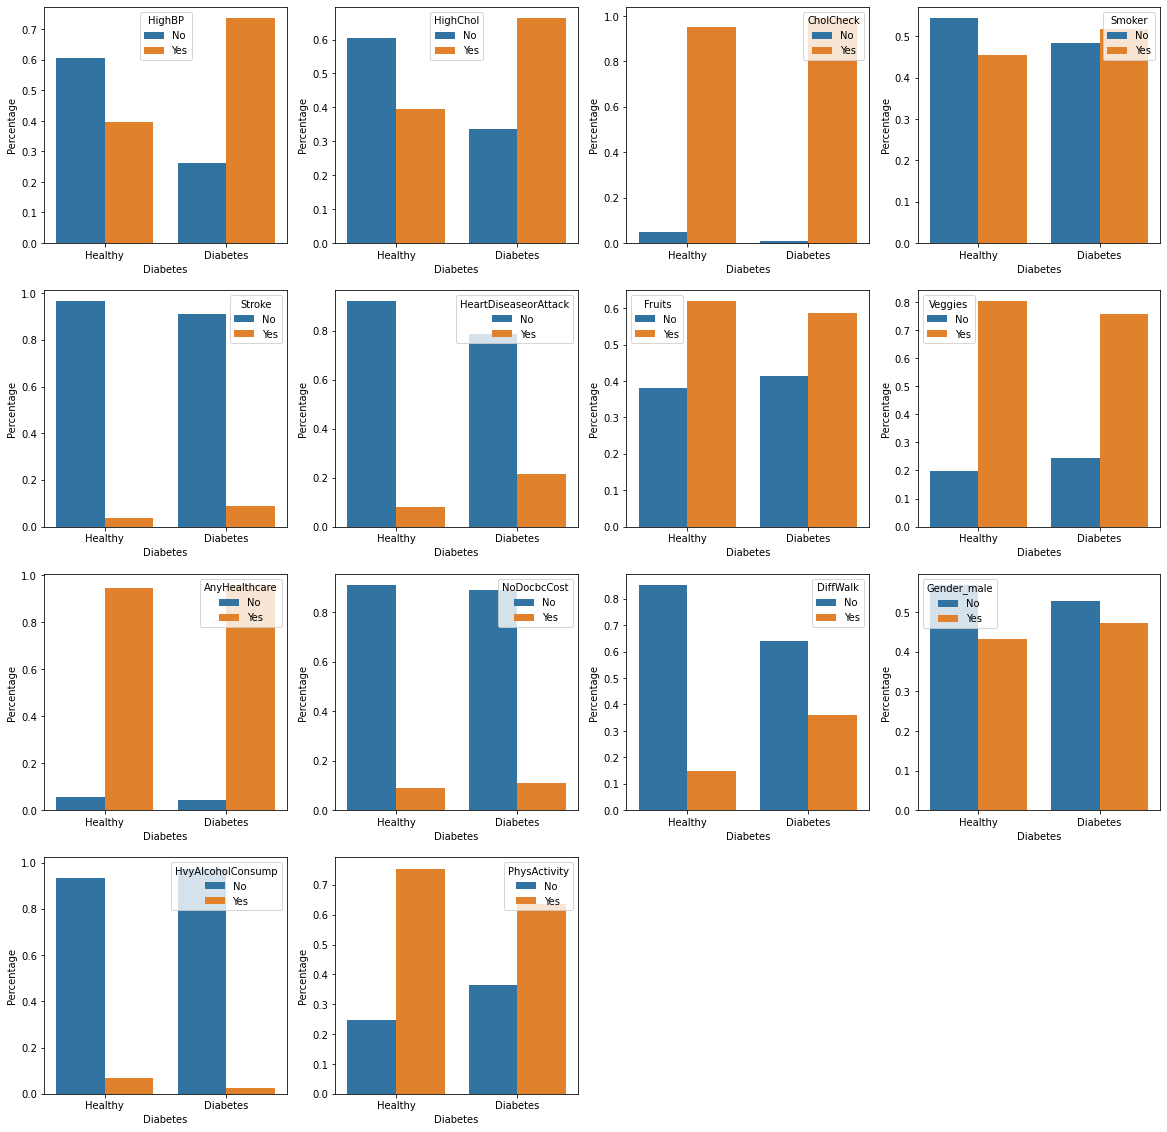

In [39]:
# Liste mit nominalskalierten Features
features_barplots = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke','HeartDiseaseorAttack', 'Fruits', 'Veggies', 
                     'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Gender_male', 'HvyAlcoholConsump', 'PhysActivity']

fig, axes = plt.subplots(4, 4, figsize=(20,20))

row_count = 0
col_count = 0

# For-Schleife, die die nominalen Features durchläuft und Subplots (bar-Plots) erstellt
for feature in features_barplots:
    diabetes_feature_count_tab = create_diabetes_feature_tab(feature)
    sns.barplot(x='Diabetes', y='Percentage', hue=feature, data=diabetes_feature_count_tab, ax=axes[row_count, col_count])
    col_count += 1
    if col_count > 3:
        row_count += 1
        col_count = 0

# Entfernen der Subplots 15 und 16 
fig.delaxes(axes[3,2])
fig.delaxes(axes[3,3])

##### Interpretation - Balkendiagramme

Ähnlich wie bei den Boxplots aus dem vorherigen Kapitel, kann auch die Interpretation der hier erstellen Balkendiagramme **erste Erkenntnisse bezüglich der späteren Feature Selection** geben, wobei **einige Zusammenhänge** hier bereits **sehr deutlich** zu erkennen sind. So ist zum Beispiel bei den Features **'HighBP'** und **'HighChol'** eine deutliche Abhängigkeit der Feature Ausprägung und des Diabetesstatus zu erkennen. Auch die Verteilung des Features **'Smoker'** lässt darauf schließen dass hier ein Zusammenhang besteht. Gleiches gilt für die körperliche Aktivität (**'PhysActivity'**). Die visuelle Abhängigkeit beim Feature 'DiffWalk' besteht auch, ist allerdings kritischer zu betrachten, da hier nicht klar ersichtlich ist, ob eine Person Schwierigkeiten beim Laufen hat, weil sie Diabetes hat oder anders herum. Das ähnliche Problem bei der Interpretation besteht bei 'Stroke' und 'HeartDiseaseorAttack'. Alle anderen Features scheinen nach visueller Betrachtung der Balkendiagramme keinen großen Zusammenhang zum Diabetesstatus zu haben. 

Aus den gesammelten Erkenntnissen lassen sich **Nullhypothesen** ableiten, welche in Kapitel 2.7.2 durch **statistische Tests**, im Falle der kategorischen Inputs beim vorliegenden kategorischen Output dem Chi-Quadrat-Test, überprüft werden können.

Die zu überprüfenden Nullhypothesen, abgeleitet aus den Erkenntnissen aus den Balkendiagrammen, lauten:

1) Es besteht kein Zusammenhang zwischen dem Feature HighBP und dem Diabetesstatus.

2) Es besteht kein Zusammenhang zwischen dem Feature HighChol und dem Diabetesstatus.

3) Es besteht kein Zusammenhang zwischen dem Feature Smoker und dem Diabetesstatus.

4) Es besteht kein Zusammenhang zwischen dem Feature PhysActivity und dem Diabetesstatus.

### 2.6.3 Visualisierung der metrischen Features in Abhängigkeit des Diabetesstatus

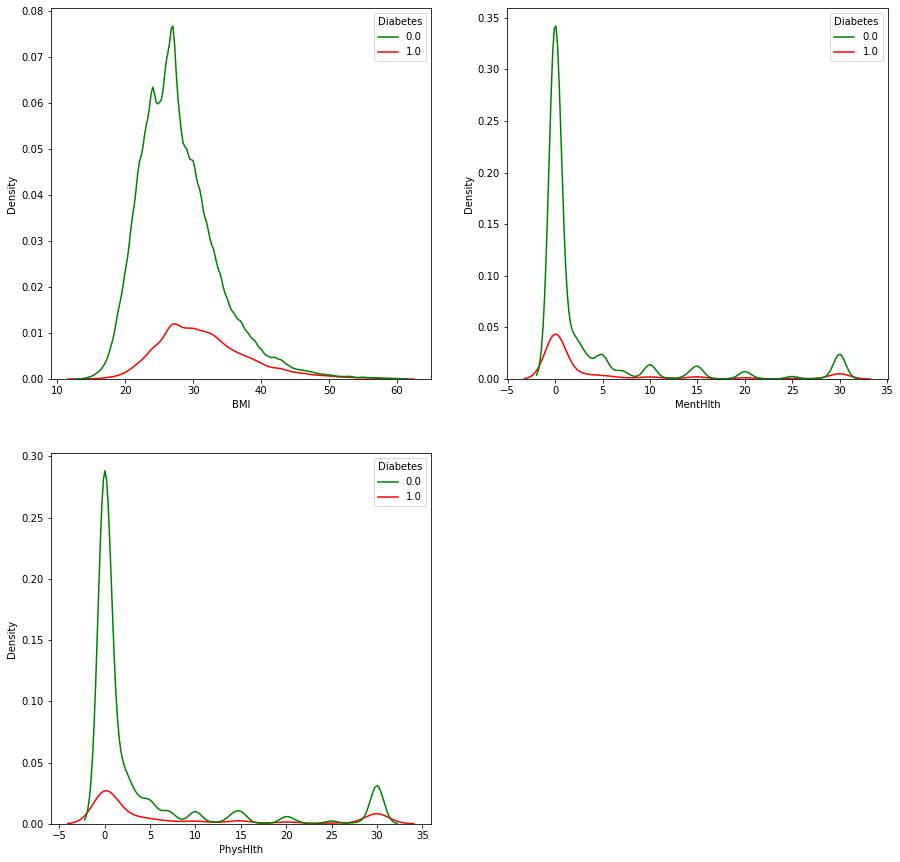

In [36]:
# Liste mit metrischen Features 
features_kdeplot = ['BMI', 'MentHlth', 'PhysHlth']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

row_count = 0
col_count = 0

# For-Schleife, die metrische Features durchläuft und einzelne Subplots (KDE-Plots) erstellt
for feature in features_kdeplot:
    sns.kdeplot(ax=axes[row_count, col_count], data=df, x=feature, hue='Diabetes', legend=True, palette=['green', 'red'])
    col_count += 1
    if col_count == 2:
        row_count += 1
        col_count = 0

fig.delaxes(axes[1,1])
        
plt.show()

### 2.6.4 Nähere Betrachtung einiger Features

#### 2.6.4.1 High Cholesterol vs. Cholesterol Check

In [ ]:
# sns.barplot(x='HighChol', hue='CholCheck', data=df)
# distplot
# Plot Age vs. Gender

## 2.7 statistische Zusammenhänge zwischen den Variablen

Im Folgenden werden die **Zusammenhänge zwischen den Variablen untereinander** untersucht. Besteht zwischen zwei Features eine hohe Korrelation, so kann dies bei der Feature Selection näher betrachtet werden. Hier kann dann beispielsweise nur eines der stark korrelierenden Features in das tatsächliche Feature Set übernommen werden, da das Aufnehmen beider Variablen das endgültige Modell verzerren könnte.

### 2.7.1 Zusammenhang zwischen numerischen Inputs und kategorischem Output

Um den Zusammenhang von numerischen Inputs mit einem kategorischen Output und den Zusammenhang von nicht binären Features untereinander darzustellen wird der Kendall'sche Rangkorrelationskoeffizient verwendet.

#### 2.7.1.1 Spearman Rangkorrelationskoeffizient

Der kendall'sche Rangkorrelationskoeffizient wird eingesetzt, um die Beziehung zweier **mindestens ordinalskalierter** Features zueinander auszugeben. Es handelt sich hierbei um eine **bivariate** Analysemethode der Statistik. Für die Scoringmethode der .corr-Funktion wurde sich nach Durchführung von 'kendall' und 'spearman' für **'spearman'** entschieden, da dieser in der Praxis noch etwas weiter verbreitert ist. Generell unterscheiden sich beide Methoden jedoch nicht in den Anforderungen und **beide** wären **möglich**. Auch die Ergebnisse waren in beiden Fällen ähnlich, wobei jedoch die Werte bei 'spearman' noch etwas klar ausfielen, sodass sie auch leichter zu interpretieren sind. 

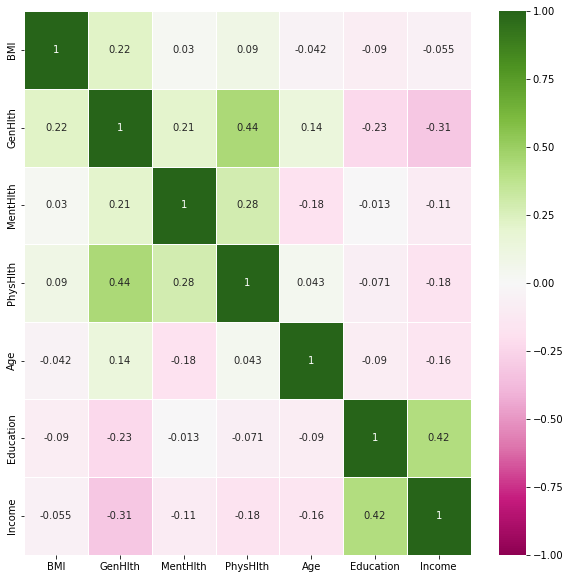

In [107]:
# Dataframe der nur mindestens ordinalskalierte Features enthält 
df_numerical = df[['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']]

fig = plt.figure(figsize=(10,10))
# Erstellung eines sns-Heatmap zur Darstellung von Korrelationen aus dem Spearman Rangkorrelationskoeffizienten
sns.heatmap(df_numerical.corr(method='spearman'), vmin=-1, vmax=1, cmap='PiYG', annot=True, linewidths=1)
plt.show()

##### Quellen

Spearman und Kendall: *https://wissenschafts-thurm.de/grundlagen-der-statistik-zusammenhangsmasse-die-korrelationskoeffizienten-nach-spearman-und-kendall/*

### 2.7.2 Zusammenhang zwischen kategorischen Inputs und kategorischem Output

#### 2.7.2.1 Chi-Quadrat-Test

In Kapitel 2.6.2, bei der Interpretation der Balkendiagramme, wurden ein paar Nullhypothesen bezüglich des Zusammenhangs zweier kategorischer (nominaler) Variablen aufgestellt. Diese sollen im Folgenden durch die Anwendung des Chi-Quadrat-Test auf einem Signifikanzniveau von 5& statistisch bestätigt werden. Das bedeutet, dass die Nullhypothese abgelehnt werden kann, wenn der p-Wert kleiner als 5% ist. 

Wichtig hierbei ist, dass hier nur ausgewählte Tests, z.B. auf Grundlage einiger Beobachtungen in Visualisierungen, durchgeführt werden, da multiples Testen die Wahrscheinlichkeit für falsche Ergebnisse beim Testen erhöht.

In [104]:
_, p_val1 = chi2(np.array(df['HighBP']).reshape(-1,1), np.array(df['Diabetes']).reshape(-1,1))
print(f'p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen HighBP und Diabetes: {p_val1}')

_, p_val2 = chi2(np.array(df['HighChol']).reshape(-1,1), np.array(df['Diabetes']).reshape(-1,1))
print(f'p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen HighChol und Diabetes: {p_val2}')

_, p_val3 = chi2(np.array(df['Smoker']).reshape(-1,1), np.array(df['Diabetes']).reshape(-1,1))
print(f'p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen Smoker und Diabetes: {p_val3}')

_, p_val4 = chi2(np.array(df['PhysActivity']).reshape(-1,1), np.array(df['Diabetes']).reshape(-1,1))
print(f'p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen PhysActivity und Diabetes: {p_val4}')

p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen HighBP und Diabetes: [0.]
p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen HighChol und Diabetes: [0.]
p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen Smoker und Diabetes: [2.60478892e-59]
p-Wert für die Nullhypothese: Es besteht kein Zusammenhang zwischen PhysActivity und Diabetes: [6.64033729e-140]


##### Interpretation - Chi-Quadrat-Test

Es ist zu erkennen, dass alle p-Werte der durchgeführten Chi-Quadrat-Tests kleiner als 5% sind. Somit können alle vier Nullhypothesen abgelehnt werden. Es besteht also ein **statistischer Zusammenhang** zwischen den Features **'HighBP', 'HighChol', 'Smoker', 'PhysActivity'** mit dem **Diabetesstatus** eines Patienten. Diese Erkenntnisse können später bei der Feature Selection erneut aufgegriffen werden. Bei der Interpretation der p-Werte muss berücksichtigt werden, dass bereits ein **kleiner Zusammenhang bei großer Stichprobenanzahl im p-Wert deutlich** angezeigt wird.

##### Quellen 

Chi-Quadrat-Test (1): *Skript 4: Ergänzungen*

Chi-Quadrat-Test (2): *https://datatab.de/tutorial/chi-quadrat*

Skalenniveau beim Chi-Quadrat-Test: *https://statistikguru.de/spss/chi-quadrat-test-unabhaengigkeit/voraussetzungen-10.html*

# 3. Data Preparation

## 3.1 Data Cleaning

### 3.1.1 Duplikate entfernen

Im Bereich des Machine Learnings können **doppelte Feature Vektoren** aus verschiedenen Gründen **problematisch** werden. Fällt zum Beispiel eine Zeile nach dem Split in den Trainingsdatensatz und die andere, gleiche Zeile in den Testdatensatz, so hat das Modell diese Daten bereits gesehen. Hierdurch wird das anschließende Ergebnis verzerrt. (*https://deepchecks.com/what-is-data-cleaning/*) Hierbei könnten doppelte Zeilen im Datensatz zu **Overfitting** führen, wenn das Modell mehrmals mit den gleichen Daten trainiert wird. Um dies zu verhindern werden die Duplikate aus dem "Diabetes Health Indicators" Datensatz ausfindig gemacht und **entfernt**.

In [51]:
# Ausgabe Anzahl der Zeilen im unbereinigten Datensatz
print(f'Der unbereinigte Datensatz umfasst {df.shape[0]} Feature Vektoren.')

Der unbereinigte Datensatz umfasst 253680 Feature Vektoren.


In [52]:
# Ausgabe der Anzahl der doppelten Zeilen im Datensatz
duplicates = df[df.duplicated()]
print(f'Davon sind {len(duplicates)} Zeilen doppelt.')

Davon sind 23968 Zeilen doppelt.


In [53]:
# Ausgabe der doppelten Zeilen
duplicates

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
1242,1.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
1563,0.0,0.0,0.0,1.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
2700,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
3160,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0
3332,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,9.0,6.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,1.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


In [5]:
# Entfernen der doppelten Zeilen
df.drop_duplicates(inplace = True)

In [55]:
# Anzahl der Zeilen im bereinigten Datensatz
print(f'Der bereinigte Datensatz beinhaltet noch die Daten von {df.shape[0]} Patienten.')

Der bereinigte Datensatz beinhaltet noch die Daten von 229712 Patienten.


In [57]:
# Ausgabe der prozentualen Klassenverteilung im Datensatz ohne doppelte Zeilen
df_dup_removed_diab_perc_list = calc_prozentual_target(df)

print(f'Der bereinigte Datensatz enthält {diabetes_perc_df[0]} % gesunde Patienten und {diabetes_perc_df[1] }% Patienten mit Diabetes.')

Der bereinigte Datensatz enthält 84.241 % gesunde Patienten und 15.759% Patienten mit Diabetes.


##### Zusammenfassung - Doppelte Zeilen entfernen

Obwohl die Unbalanciertheit des Datensatzes durch das Entfernen der doppelten Zeilen etwas vergrößert wird, sprechen unter anderem die oben genanneten Gründe dafür, sie zur weiteren Bearbeitung aus dem Datensatz zu entfernen. 

### 3.1.2 Unplausible Werte

Aus dem unteren Boxplot in Kap. 2.5.1 und der Informationstabelle, die in Kap. 2.3 mithilfe von df.describe() erstellt wurde, lässt sich ein Maximalwert des BMI von 98 kg/m² erkennen. Da man laut der deutschen Adipositas Gesellschaft bereits ab einem BMI über 40kg/m² unter Adipositas Grad III fällt, sind Werte ab einem BMI über 60kg/m² als kritisch einzustufen. (*https://adipositas-gesellschaft.de/bmi/*) Gleiches gilt für den Minimalwert des BMI, der im Datensatz bei 12 kg/m² liegt. Generell gilt ein BMI von unter 14,5 kg/m² als lebensgefährlich. Aus diesem Grund werden Patienten mit einem BMI unter 14 kg/m² aus dem Datensatz entfernt.

In [6]:
lower_crit_value_bmi = 14
upper_crit_value_bmi = 60

df_low_bmi = df.loc[df['BMI'] < lower_crit_value_bmi]
df_high_bmi = df.loc[df['BMI'] > upper_crit_value_bmi]

print(f'Der Datensatz enthält {df_low_bmi.shape[0]} Patienten mit einem kritischen BMI von unter {lower_crit_value_bmi} kg/m² und {df_high_bmi.shape[0]} Patienten mit einem kritischen BMI von\nüber {upper_crit_value_bmi} kg/m².')

Der Datensatz enthält 27 Patienten mit einem kritischen BMI von unter 14 kg/m² und 805 Patienten mit einem kritischen BMI von
über 60 kg/m².


Die Patienten mit einem kritisch hohen BMI verbleiben vorerst im Datensatz, da solch hohe BMI-Werte in der Realitiät tatsächlich vorkommen können. Nachdem allerdings ein BMI von unter 14,5 kg/m² als lebensgefährlich gilt, werden Patienten mit einem BMI von unter 14 kg/m² aus dem Datensatz entfernt.

##### Entfernen der Featurevektoren mit kritischem BMI (niedrig)

In [7]:
df.drop(df_low_bmi.index, axis=0, inplace=True)

##### Entfernen der Featurevektoren mit kritischem BMI (hoch)

In [8]:
df.drop(df_high_bmi.index, axis=0, inplace=True)

## 3.2 Vorbereitung des Modellings

Für anschließende Vorgänge in der Vorbereitung des Modellings und im Modelling selbst kann es nützlich sein, den Datensatz in Features (x-Werte) und Target (y-Wert) aufzuteilen. Da im weiteren Verlauf eine erneute Trennung des Datensatzes in x- und y-Werte erforderlich sein kann, z.B. nach der Skalierung, werden im Folgenden zwei Funktionen hierfür implementiert.

In [9]:
# Funktion, die Features aus Datensatz extrahiert
def get_x_values(df):
    x_values = df.drop(['Diabetes'], axis='columns')
    return x_values

# Funktion, die Target aus Datensatz extrahiert
def get_y_value(df):
    y_value = df['Diabetes']
    return y_value

# Erstellung eines neuen DataFrames, der nur x-Werte enthält
x_values = get_x_values(df)

# Erstellung eines Dataframe.shape, der nur die Targetvariable des Datensatzes enthält
y_value = get_y_value(df)

##### Initialisierung von Cross Validation-Splits zur späteren Verwendung im Modelling

Im Folgenden werden sowohl **KFold-** als auch **StratifiedKFold-Splits** erstellt, die später im Modelling hinzugezogen werden. Um zu gewährleisten, dass es sich hierbei später immer um die gleichen Splits handelt, wird der **'random_state'-Parameter** der Splits auf eine feste Zahl (42) gesetzt.

In [10]:
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
kf10 = KFold(n_splits=10, shuffle=True, random_state=42)

skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### 3.2.1 Feature Scaling

#### 3.2.1.1 Einführung in das Thema Feature Scaling

Wenn ein Modell mit unskalierten Daten trainiert wird, bei dem einige Features einen (deutlich) größeren Wertebereich haben, als andere, kann es beim Training des Modells dazu führen, dass diese Features einen größeren Einfluss auf den Ausgang des Modells haben. Obwohl ein paar Machine-Learning-Algorithmen, wie z.B. baumbasierte Methoden, auch ohne Feature Scaling auskommen, ist es üblich, diese vor dem Modelling zu skalieren. Dies gilt besonders, wenn man viele verschiedene Machine Learning Algorithmen testen und vergleichen will. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.239. Apress.*)

Im Folgenden wird eine Funktion scale_df() implementiert, die einen DataFrame und eine Scaling-Methode entgegen nimmt, und den skalierten Datensatz zurückgibt. Diese wird im Modelling an geeigneter Stelle eingesetzt, um die **Daten zu skalieren**. 

In [11]:
# Funktion, die gesamten Datensatz mit gewünschtem Scaler skaliert und den skalierten Datensatz zurückgibt
def scale_df(df, scaler_method):
    scaler = scaler_method
    scaled_data = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(scaled_data, columns = df.columns)
    return df_scaled

In [25]:
# Funktion, die nur gewünschte Features eines Datensatzes skaliert und den neuen Datensatz zurückgibt
def scale_features_df(df, features_to_scale, scaler_method):
    arr_scaled_features = scaler_method.fit_transform(df[features_to_scale])
    df_scaled_features = pd.DataFrame(arr_scaled_features, columns=features_to_scale)
    df_scaled = pd.concat([df.drop(features_to_scale, axis='columns').reset_index(drop=True), df_scaled_features.reset_index(drop=True)], axis='columns')
    return df_scaled

#### 3.2.1.2 Vorbereitung - Feature Scaling

Genauso wie es wichtig ist das Modell mit unbekannten Testdaten zu testen, ist es auch wichtig, das Scaling innerhalb des Splits durchzuführen. *(Computing cross-validated metrics, 3.1.1 https://scikit-learn.org/stable/modules/cross_validation.html)* Anderenfalls könnte das Skalieren des gesamten Datensatzes dazu führen, dass Informationen aus dem Datensatz noch vor dem Test in das Modell geraten und das anschließende Ergebnis verzerren.

Im Folgenden wird innerhalb eines ersten **Stratified KFold-Splits** mit **5 Folds** analysiert, ob verschiedene statistische Werte beim Skalieren der Daten in den verschiedenen Folds voneinander abweichen. Falls das nicht der Fall ist, kann das Scaling trotzdem auf den gesamten Datensatz angewendet werden. Darüber hinaus kann es hilfreich sein, um einen Eindruck über die Güte des gewählten Splits zu erhalten.

*Anmerkung zur Größe des Splits*

*Wegen der Größe des Datensatzes wurde der Split vorerst auf 5 festgelegt, um Rechenaufwand zu sparen. Treten hier innerhalb der unterschiedlichen Splits die gleichen Ergebnisse auf, so wäre dies ein erstes Indiz dafür, dass der Split richtig gewählt ist, und die Größe nicht angepasst werden muss. Andernfalls gäbe es noch die Möglichkeit, die Anzahl der Folds zu verändern.*

In [14]:
# Funktion, die das Scaling des Datensatzes in verschiedenen Splits durchführt und in einem DataFrame abspeichert
def create_df_scaling_cv_feature(x_values, y_value, scaler):
    features = list(x_values.columns)
    df_column_names = ['Feature', 'Split', 'Train_Minima', 'Test_Minima', 'Train_Maxima', 'Test_Maxima']
    df_scaled_values = pd.DataFrame(columns=df_column_names)
    split_counter = 1
    for train_index, test_index in skf5.split(x_values, y_value):
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        scaler = scaler
        scaled_train = scaler.fit_transform(X_train)
        scaled_test = scaler.transform(X_test)
        df_scaled_train = pd.DataFrame(scaled_train, columns=features)
        df_scaled_test = pd.DataFrame(scaled_test, columns=features)
        for idx, feature in enumerate(features):
            row_counter = (split_counter-1)*len(features) + idx
            df_scaled_values.at[row_counter, 'Split'] = split_counter
            df_scaled_values.at[row_counter, 'Feature'] = feature
            df_scaled_values.at[row_counter, 'Train_Minima'] = df_scaled_train.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Train_Maxima'] = df_scaled_train.iloc[:, idx].max()
            df_scaled_values.at[row_counter, 'Test_Minima'] = df_scaled_test.iloc[:, idx].min()
            df_scaled_values.at[row_counter, 'Test_Maxima'] = df_scaled_test.iloc[:, idx].max()
        split_counter += 1 
    df_scaled_values.sort_values(by=['Feature', 'Split'], inplace=True)
    return df_scaled_values

##### Vergleich der Minima und Maxima bei Scaling mit dem MinMaxScaler innerhalb eines StratifiedKFold-Splits

In [72]:
pd.set_option('display.max_rows', None)
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, MinMaxScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,0.0,0.0,1.0,1.0
39,Age,2,0.0,0.0,1.0,1.0
60,Age,3,0.0,0.0,1.0,1.0
81,Age,4,0.0,0.0,1.0,1.0
102,Age,5,0.0,0.0,1.0,1.0
11,AnyHealthcare,1,0.0,0.0,1.0,1.0
32,AnyHealthcare,2,0.0,0.0,1.0,1.0
53,AnyHealthcare,3,0.0,0.0,1.0,1.0
74,AnyHealthcare,4,0.0,0.0,1.0,1.0
95,AnyHealthcare,5,0.0,0.0,1.0,1.0


##### Vergleich der Minima und Maxima bei Scaling mit dem StandardScaler innerhalb eines StratifiedKFold-Splits

In [73]:
pd.set_option('display.max_rows', None)
df_minmax_scaler_cv = create_df_scaling_cv_feature(x_values, y_value, StandardScaler())
df_minmax_scaler_cv

,Feature,Split,Train_Minima,Test_Minima,Train_Maxima,Test_Maxima
18,Age,1,-2.292599,-2.292599,1.586454,1.586454
39,Age,2,-2.290448,-2.290448,1.587008,1.587008
60,Age,3,-2.294375,-2.294375,1.587779,1.587779
81,Age,4,-2.293386,-2.293386,1.587758,1.587758
102,Age,5,-2.288342,-2.288342,1.585275,1.585275
11,AnyHealthcare,1,-4.183862,-4.183862,0.239014,0.239014
32,AnyHealthcare,2,-4.197782,-4.197782,0.238221,0.238221
53,AnyHealthcare,3,-4.202527,-4.202527,0.237952,0.237952
74,AnyHealthcare,4,-4.189459,-4.189459,0.238694,0.238694
95,AnyHealthcare,5,-4.179621,-4.179621,0.239256,0.239256


##### Interpretation (Vorbereitung - Feature Scaling)

Es ist zu erkennen, dass **weder die Minimal-, noch die Maximalwerte** der skalierten Daten (**sowohl mit dem StandardScaler(), als auch mit dem MinMaxScaler())** bei einem StratifiedKFold-Split mit 5 Folds deutlich voneinander abweichen. Hierdurch ist es möglich, die Daten bereits vor dem Modelling mithilfe des ganzen Datensatzes durchzuführen, ohne dass es zu Verzerrungen des Modells kommt. Ein Grund hierfür könnte beispielsweise der relativ große Umfang des Datensatzes sein. Darüber hinaus kann dies ein Indiz dafür sein, dass der **Split** (StratifiedKFold mit 5 Folds) an dieser Stelle **richtig gewählt** wurde.

#### 3.2.1.3 Auswahl eines geeigneten Scalers

Gängige Scaler, die im Bereich des Machine Learnings verwendet werden, sind unter anderem der **MinMaxScaler, der StandardScaler und der Robust Scaler**.

Der Vorteil des **RobustScalers** liegt darin, dass er **robust gegen Ausreißer** ist. Da im vorliegenden Datensatz überwiegend binäre Features bzw. numerische Features mit einem geringen Wertebereich vorliegen, spielt das hier keine große Rolle. Lediglich beim Feature 'BMI' gab es "Ausreißer" bzw. unplausible Werte, welche aber bereits zu Beginn der Data Preparation aus dem Datensatz entfernt wurden. Deshalb wird der RobustScaler im weiteren Verlauf der Arbeit **nicht näher betrachtet**.

Der **StandardScaler** skaliert die Werte über die Ermittlung des **Mittelwert** eines Features. Darüber hinaus geht er von einer **Normalverteilung** der einzelnen Features aus. Da im vorliegenden Datensatz überwiegend binäre Features vorliegen, und auch die numerischen Features nach Interpretation der Plots in Kapitel 2.6.3 nicht normal verteilt zu sein scheinen, ist auch dieser Scaler in diesem Fall **nur wenig sinnvoll**. Da es sich hierbei trotzdem um einen beliebten Scaler handelt, wird der Datensatz im Folgenden trotzdem auch mit dem StandardScaler skaliert, um später eventuell einen **Vergleich** durchführen zu können. Die **Funktion 'scale_features_df'** (s. Kapitel 3.2.1.1) ermöglicht zumindest den **Ausschluss der binären Features**, deren Wertebereich sowieso schon zwischen 0 und 1 liegt, aus dem Scalingprozess.

Der **MinMaxScaler** skaliert alle Features in ein **bestimmtes Intervall**, welches standardmäßig zwischen 0 und 1 liegt. Dieser Scaler funktioniert optimal, wenn die **Standardabweichung der Features gering** ist und die Verteilung der Featurs **nicht der Gauss'schen Normalverteilung** entspricht. Beides ist beim vorliegenden Datensatz, mit einigen binären Features, gegeben, sodass der MinMaxScaler hier als **beste Option** erscheint.

##### Quellen

Informationen über die verschiedenen Scaler: *https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35*

Vorgehen beim StandardScaler: *https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html*

#### 3.2.1.4 Feature Scaling - Normalisieren mit dem MinMaxScaler

In [44]:
# Erzeugung eines neuen DataFrames mit skalierten Variablen (MinMaxScaler)
df_scaled_mm = scale_df(df, MinMaxScaler())

# Anzeige der ersten Zeilen aus dem neu erzeugten Datensatz
df_scaled_mm.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
0,0.0,1.0,1.0,1.0,0.565217,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.00,0.6,0.5,1.0,0.0,0.666667,0.6,0.285714
1,0.0,0.0,0.0,0.0,0.239130,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.50,0.0,0.0,0.0,0.0,0.500000,1.0,0.000000
2,0.0,1.0,1.0,1.0,0.304348,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.00,1.0,1.0,1.0,0.0,0.666667,0.6,1.000000
3,0.0,1.0,0.0,1.0,0.282609,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.833333,0.4,0.714286
4,0.0,1.0,1.0,1.0,0.217391,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.1,0.0,0.0,0.0,0.833333,0.8,0.428571


Zur Verwendung der skalierten Daten im späteren Modelling wird anschließend der Datensatz wieder in **Features und Target** aufgeteilt. Da es beim Scaling hauptsächlich darum geht, die Features untereinander "vergleichbarer" zu machen, sodass nicht beispielweise ein Feature mit größerem Wertebereich das Ergebnis mehr beeinflusst, ist es nicht zwingend notwendig das skalierte Target zusätzlich abzuspeichern. Im Modelling kann das ursprüngliche Target für y verwendet werden. 

In [45]:
# normalisierte x-Werte abspeichern
x_values_mm = get_x_values(df_scaled_mm)

#### 3.2.1.5 Feature Scaling - Standardisieren mit dem StandardScaler

In [23]:
# Erstellung eines neuen DataFrames, in dem alle Variablen mit dem StandardScaler skaliert werden
df_scaled_ss = scale_df(df, StandardScaler())
df_scaled_ss.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
0,-0.456463,1.096028,1.123943,0.205488,1.862121,1.070723,-0.216536,-0.339353,-1.659715,-1.259021,...,0.238628,-0.319807,2.255396,1.880735,1.143245,2.099021,-0.884857,0.293960,-0.987576,-1.382424
1,-0.456463,-0.912386,-0.889725,-4.866458,-0.571218,1.070723,-0.216536,-0.339353,0.602513,-1.259021,...,-4.190626,3.126886,0.375776,-0.454232,-0.516457,-0.476412,-0.884857,-0.352487,1.027044,-2.338694
2,-0.456463,1.096028,1.123943,0.205488,-0.084550,-0.933948,-0.216536,-0.339353,-1.659715,0.794268,...,0.238628,3.126886,2.255396,3.437379,2.802946,2.099021,-0.884857,0.293960,-0.987576,1.008251
3,-0.456463,1.096028,-0.889725,0.205488,-0.246773,-0.933948,-0.216536,-0.339353,0.602513,0.794268,...,0.238628,-0.319807,-0.564034,-0.454232,-0.516457,-0.476412,-0.884857,0.940407,-1.994886,0.051981
4,-0.456463,1.096028,1.123943,0.205488,-0.733441,-0.933948,-0.216536,-0.339353,0.602513,0.794268,...,0.238628,-0.319807,-0.564034,-0.065071,-0.516457,-0.476412,-0.884857,0.940407,0.019734,-0.904289


In [27]:
# Erstellung eines neuen DataFrames, in dem alle nicht binären Variablen mit dem StandardScaler skaliert werden
df_scaled_ss_nb = scale_features_df(df, ['BMI', 'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'], StandardScaler())
df_scaled_ss_nb.head()

,Diabetes,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,Fruits,Veggies,HvyAlcoholConsump,...,DiffWalk,Gender_male,BMI,PhysActivity,GenHlth,MentHlth,PhysHlth,Age,Education,Income
0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.862121,-1.659715,2.255396,1.880735,1.143245,0.293960,-0.987576,-1.382424
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.571218,0.602513,0.375776,-0.454232,-0.516457,-0.352487,1.027044,-2.338694
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,-0.084550,-1.659715,2.255396,3.437379,2.802946,0.293960,-0.987576,1.008251
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,-0.246773,0.602513,-0.564034,-0.454232,-0.516457,0.940407,-1.994886,0.051981
4,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,-0.733441,0.602513,-0.564034,-0.065071,-0.516457,0.940407,0.019734,-0.904289


In [28]:
# x-Werte des DataFrames, der mit StandardScaler skaliert wurde
x_values_ss = get_x_values(df_scaled_ss)

# x-Werte des DataFrames, bei dem nicht binäre Variablen mit dem StandardScaler skaliert wurden
x_values_ss_nb = get_x_values(df_scaled_ss_nb)

### 3.2.2 Umgang mit kategorischen Daten

Da ein **Machine Learning Algorithmus** immer besser mit **numerischen Werten** arbeiten kann, als mit kategorischen Variablen. Aus diesem Grund müssen kategorische Daten häufig speziell für das Modelling vorbereitet werden, indem die kategorischen Werte in numerische Werte **umgewandelt** werden. Dies gilt vor allem für die Features, für manche Machine Learning-Algorithmen, vor allem im Bereich des Deep Learnings, aber auch für die Targetvariable. Allerdings muss die Targetvariable nur im Fall der Multiclass-Klassifikation umgewandelt werden. 

Generell gelten für das OneHot Encoding von kategorischen Daten noch einige Zusätze. Variablen, die als Ausprägungen nur die Werte **0 und 1** annehmen können, müssen **nicht umgewandelt** werden. Hier reicht eine genaue Bezeichnung für die Variable, um den Wert darstellen zu können. Ein Beispiel hier wäre, dass man beim Geschlecht nicht zwei Variablen (eine für männlich und eine für weiblich braucht), sondern bspw. männlich ausreichend ist. Beim vorliegenden Datensatz ist nämlich klar, dass es sich um einen weiblichen Patienten handelt, falls der Wert für 'Male' 0 ist, da es keine Ausprägung für divers gibt.

Zudem muss beachtet werden, dass Variablen, deren Ausprägungen eine **vorgegebene Rangordnung** (mit gleichen Min-Max-Abständen) haben, **nicht unbedingt umgewandelt** werden müssen. Beim vorliegenden Datensatz wird zum Beispiel die Variable 'Age' nicht umgewandelt, da **jede Altersklasse ungefähr gleich groß** ist (5-7 Jahre) und somit eine feste Rangordnung zwischen den einzelnen Klassen besteht, die für die Vorhersage von Diabetes eine wichtige Rolle spielt.

**Anders** verhält es sich mit den Variablen **'GenHlth', 'Education'**. Hier liegen keine fest definierten Abstände vor, weshalb auch keine klare Rangordnung gebildet werden kann, mit der der Algorithmus rechnen kann. Diese werden deshalb umgewandelt. In einem späteren Kapitel wird hierzu auch eine Sensitivitätsanalyse durchgeführt. Zudem gibt es bei Feature **'Income'** keine gleichmäßigen Abstände, sodass der Algorithmus diese Abstufen eventuell fehlerhaft interpretieren könnte.

In [51]:
features_to_encode = ["GenHlth","Education", "Income"]
df_onehot = pd.get_dummies(df, columns = features_to_encode, drop_first=True)

In [20]:
pd.set_option('display.max_columns', None)
df_onehot.head()

,Diabetes,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,GenHlth_2.0,GenHlth_3.0,GenHlth_4.0,GenHlth_5.0,Education_2.0,Education_3.0,Education_4.0,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,18.0,15.0,1.0,0.0,9.0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,30.0,30.0,1.0,0.0,9.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,11.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [84]:
df_onehot.shape

(228880, 35)

##### Zusammenfassung - OneHotEncoding

Es ist zu erkennen, dass der neue Datensatz, der auch die OneHot-encodeten Features enthält, nun **35 Features** umfasst.

##### Features des encodeten Datensatzes

In [52]:
x_onehot = get_x_values(df_onehot)

##### Scaling des encodeten Datensatzes

In [113]:
x_onehot_mm = scale_df(x_onehot, MinMaxScaler())

##### Quellen (Umgang mit kategorischen Daten)
*https://analyticsindiamag.com/when-to-use-one-hot-encoding-in-deep-learning/#:~:text=One%20hot%20encoding%20can%20be,classification%20accuracy%20of%20a%20model.*

*https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/*

*https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/*

*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.204. Apress.*

## 3.3 Feature Selection

Ein weiterer wichtiger Schritt, der bereits zu Beginn des Modellings eine Rolle spielen kann ist die Feature Selection. Hierbei versucht man die Features ausfindig zu machen, die den größten Einfluss auf die vorhergesagte Klasse der Targetvariable haben. Dies ist nötig, da eine **große Anzahl** von Features dazu führen kann, dass das Modell **komplexer und schwerer zu interpretieren** wird. (*Sarkar, Bali, Sharma (2018): Practical Machine Learning with Python, S.242. Apress.*) Feature Selection wird im Allgemeinen angewendet, um **Overfitting zu vermeiden, die Accuracy zu erhöhen, und die Trainingsdauer zu minimieren**. Zur Berechung der Feature Importance stehen einem **verschiedene Methoden** zur Verfügung. Im Allgemeinen werden zur tatsächlichen Auswahl geeigneter Features mehrere dieser Möglichkeiten durchgeführt und anschließend das **Gesamtergebnis interpretiert**. 

Ähnlich wie beim Scaling der Features bietet es sich an, die Feature Selection **vorerst im Rahmen eines Splits** durchzuführen. Auch dieser Schritt zählt zur Vorbereitung des Modellings und müsste eigentlich ein Unterpunkt von Kapitel 3.2 sein, ist aber so umfangreich, dass er hier ein eigenes Teilkapitel bekommt.

### 3.3.1 Recursive Feature Elimination with Cross Validation

Die Feature Selection wird im Folgenden mit der Recursive Feature Elimination mit Cross Validation durchgeführt, um einen ersten Eindruck bezüglich der Feature Importance/ Selection zu bekommen. Hierbei kann der Minimalwert für die zu betrachtenden Features über den 'min_features_to_select'-Parameter gesetzt werden. Anschließend ist eine **Visualisierung der Scores eines gewählten Evaluationskriteriums**, sowie die **Ausgabe der optimalen Anzahl an Features** möglich. Im Fall des Diabetesdatensatzes wurde der **'recall'-Wert** als entscheidendstes Kriterium ausgewählt, welcher bei der Klassifikation von Krankheiten generell eine entscheidende Rolle spielt. EIn Vorteil der RFECV besteht darin, dass hier die Cross Validation bereits implementiert ist und somit ein manuelles Splitting nicht erforderlich ist. Dennoch sollte die Feature Selection später auch innerhalb unterschiedlicher Splits betrachtet werden, um zu ermitteln, ob die Feature Selection vor dem Modelling auf den ganzen Datensatz durchgeführt werden kann, oder ob sie im Split des tatsächlichen Modellings erfolgen muss.

#### 3.3.1.1 Vorbereitung - RFECV

In [125]:
# Funktion zur Ausgabe der ausgewählten Features der RFE(CV) und des Rankings in einem DataFrame
def rank_features_rfecv(rfecv_model, features):
    feature_names_list = list(features.columns)
    feature_ranking_list = list(rfecv_model.ranking_)
    feature_support_list = list(rfecv_model.support_)
    df_RFE_results = []
    for i in range(len(feature_names_list)):
        df_RFE_results.append(
            {      
                'Feature_names': feature_names_list[i],
                'Selected': feature_support_list[i],
                'RFE_ranking': feature_ranking_list[i]
            }
        )
    df_RFE_results = pd.DataFrame(df_RFE_results)
    df_RFE_results.index.name='Columns'
    return df_RFE_results

In [126]:
rfc1 = RandomForestClassifier()
rfecv1 = RFECV(estimator=rfc1, cv=skf5, scoring='recall', min_features_to_select=1, verbose=1)
rfecv1.fit(x_values, y_value)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(), scoring='recall', verbose=1)

#### 3.3.1.2 Optimale Anzahl an Features 

In [127]:
print("Optimal number of features : %d" % rfecv1.n_features_)

Optimal number of features : 11


#### 3.3.1.3 Visualisierung der 'Recall'-Werte mit unterschiedlicher Anzahl an Features

C:\Users\Max\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


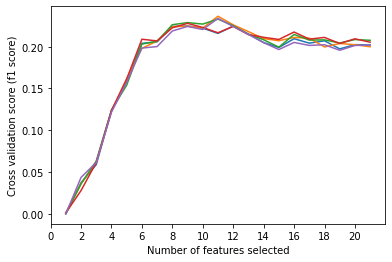

In [128]:
plt.figure()
plt.xticks(np.arange(0, 22, step=2))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (recall)")
plt.plot(range(1, len(rfecv1.grid_scores_) + 1), rfecv1.grid_scores_)
plt.show()

#### 3.3.1.4 Ranking der Features

In [130]:
df_feature_rank_rfecv1 = rank_features_rfecv(rfecv1, x_values)
df_feature_rank_rfecv1

,Feature_names,Selected,RFE_ranking
Columns,,,
0,HighBP,True,1
1,HighChol,True,1
2,CholCheck,False,11
3,BMI,True,1
4,Smoker,True,1
5,Stroke,False,8
6,HeartDiseaseorAttack,False,6
7,PhysActivity,False,4
8,Fruits,True,1


#### 3.3.1.5 Interpretation - RFECV

Wie bereits in der obigen Ausgabe zu erkennen liegt die optimale Anzahl an Features aus der RFECV mit der Evaluationskenngröße 'recall' bei 11. Im DataFrame sind die ausgewahlten Features mit einem 'Selected'-Wert von True und einem 'Ranking'-Wert von 1 gekennzeichnet. Alle weiteren Features sind abfallend über den 'ranking'-Parameter gekennzeichnet. Die wichtigsten Features aus der RFECV werden im Folgenden zur späteren Gesamtinterpretation der Feature Selection nochmals gelistet.

#### 3.3.1.6 Ausgabe der wichtigsten Features 

In [129]:
rfecv1.get_feature_names_out()

array(['HighBP', 'HighChol', 'BMI', 'Smoker', 'Fruits', 'GenHlth',
       'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income'], dtype=object)

##### Quellen zum Code (Optimale Anzahl an Features)

Allgemeiner Code: *https://machinelearningmastery.com/feature-selection-machine-learning-python/*

Erstellung des DataFrames (1): *https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31*

Erstellung des DataFrames (2): *https://www.kdnuggets.com/2020/10/feature-ranking-recursive-feature-elimination-scikit-learn.html*

Visualisierung der Ergebnisse: *https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py*

### 3.3.2 Feature Importance 

Bei Anwendung der Recursive Feature Elimination läuft im Hintergrund immer ein Machine Learning Algorithmus, der iterativ die am wenigsten wichtigen Features eliminiert, um das optimale Ergebnis zu erzielen. Hierzu muss der Algorithmus über ein Attribut namens **'coef_' oder 'feature_importances_'** verfügen, in der die Werte enthalten sind, die der RFE-Algorithmus zur Eliminierung der einzelnen Features braucht. Durch RFECV kann mithilfe des 'n_features_' Attributes eine erste Idee über die optimale Anzahl an Features für das optimale Modell erlangt werden. RFE kann durch die Attribute 'ranking_' bzw 'support_' einen detaillierteren Einblick in die tatsächliche Feature Importance geben, die im Endeffekt hinter der Feature Selection steckt. 

Ein **direkter Zugriff auf den 'feature_importances_'-Parameter** des Algorithmus, ohne Einbindung in 'Wrapper Feature Selection'-Algorithmen, wie z.B. RFE, kann eine noch genauere Einsicht in die Ergebnisse liefern und bietet weitere Visualisierungsmöglichkeiten der Ergebnisse.

#### 3.3.2.1 Vorbereitung - Feature Importance

In [193]:
# Funktion zur Erstellung von horizontalen Barplots der Feature Importance in CV-Splits
def plot_model_feature_importance(x_values, y_value, estimator, cv):
    split_counter = 1
    split_list = []
    feature_importances_df = pd.DataFrame(columns=x_values.columns)
    
    for train_index, test_index in cv.split(x_values, y_value):
        feature_importances_list = []
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        estimator.fit(X_train, y_train)
        
        importances = estimator.feature_importances_
        features = list(x_values.columns)
        
        for importance in importances:
            feature_importances_list.append(importance)
        
        importance_series = pd.Series(feature_importances_list, index = x_values.columns)
        feature_importances_df = feature_importances_df.append(importance_series, ignore_index=True)

        plt.figure(figsize=(15,15))
        plt.barh(features, importances, label='Score in Split CV ' + str(split_counter))
        
        plt.yticks(np.arange(0, len(features), step=1), features)
        plt.legend(loc='upper right')
        plt.show()
        
        split_counter += 1
        split_list.append('Split ' + str(split_counter))
        
    feature_importances_df.index = split_list
    return feature_importances_df

#### 3.3.2.2 RandomForest Classifier - Feature Importance

Der erste Machine Learning Algorithmus, der für die Ermittlung der Feature Importance verwendet wird, ist der RandomForestClassifier. Der baumbasierte Algorithmus verlangt nicht die Eingabe von skalierten oder OneHot-encodeten Features. Diese können die Ergebnisse im Fall des Random Forrest Classifiers sogar verschlechtern. Aus diesem Grund werden anschließend die **unveränderten x- und y-Werte** für die Ermittlung der Feature Importance verwendet.

##### Visualisierung mit horizontalen Barplots

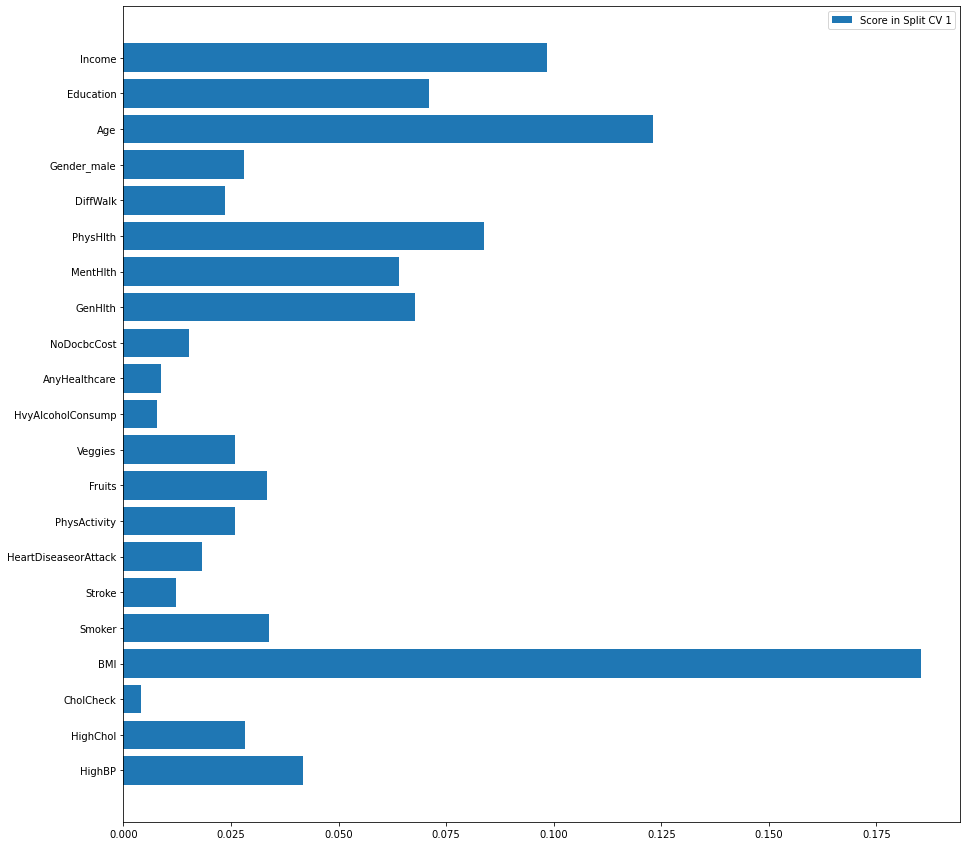

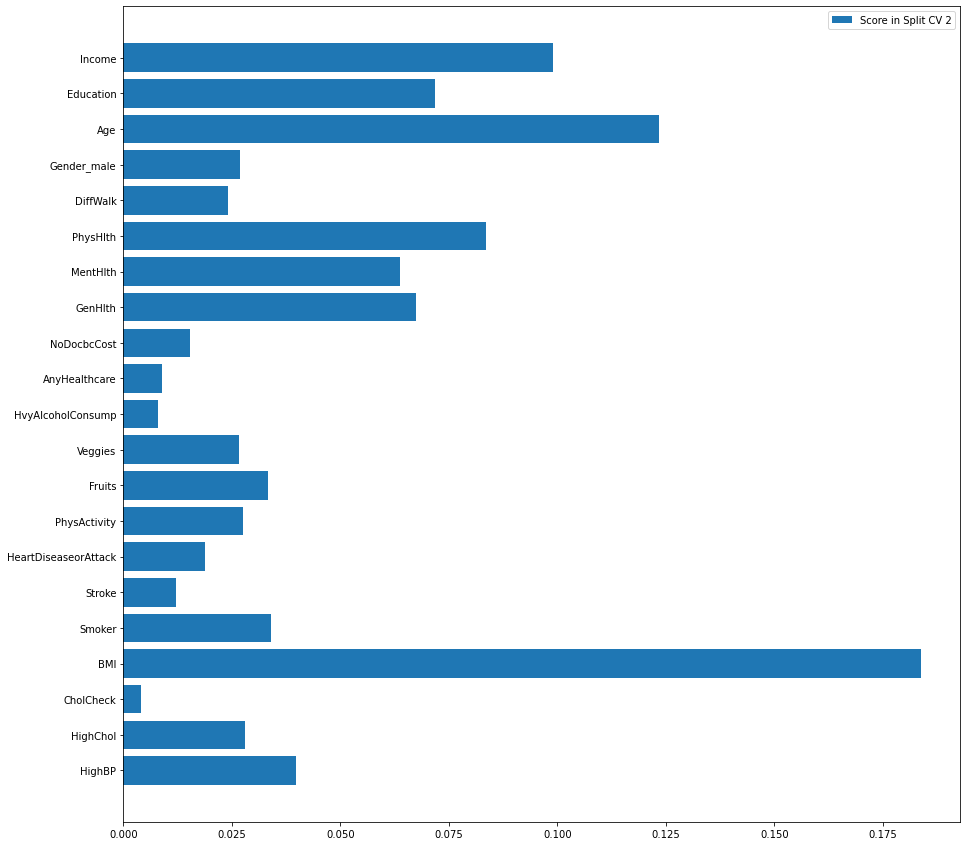

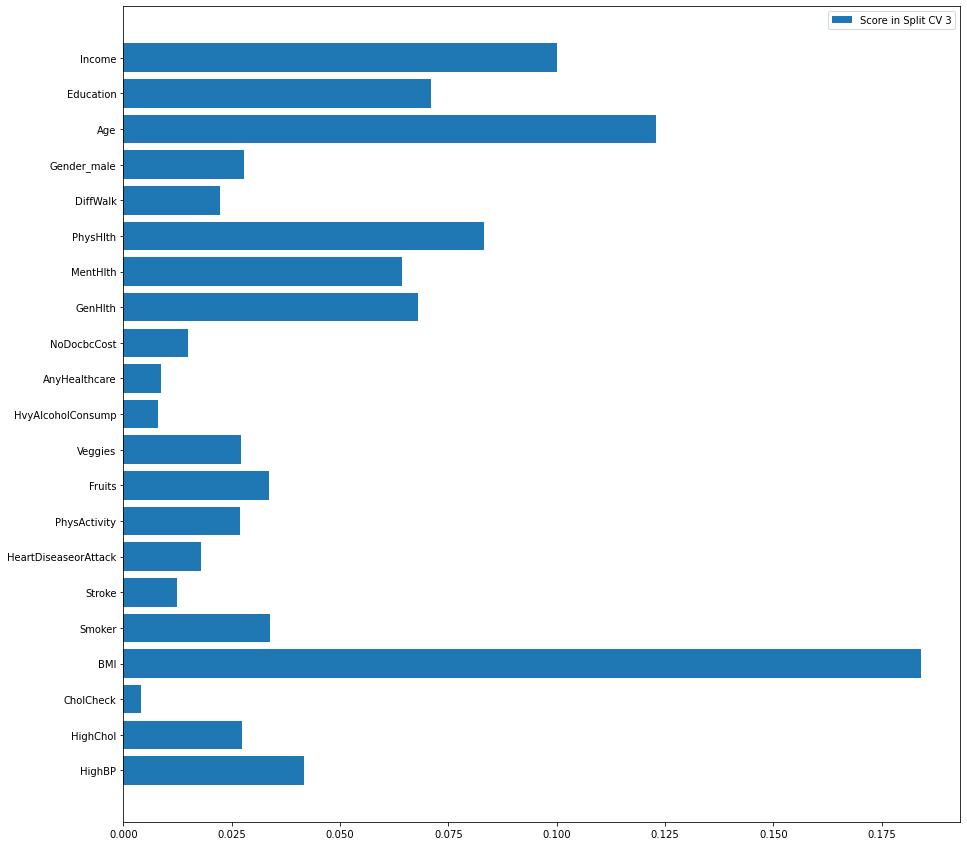

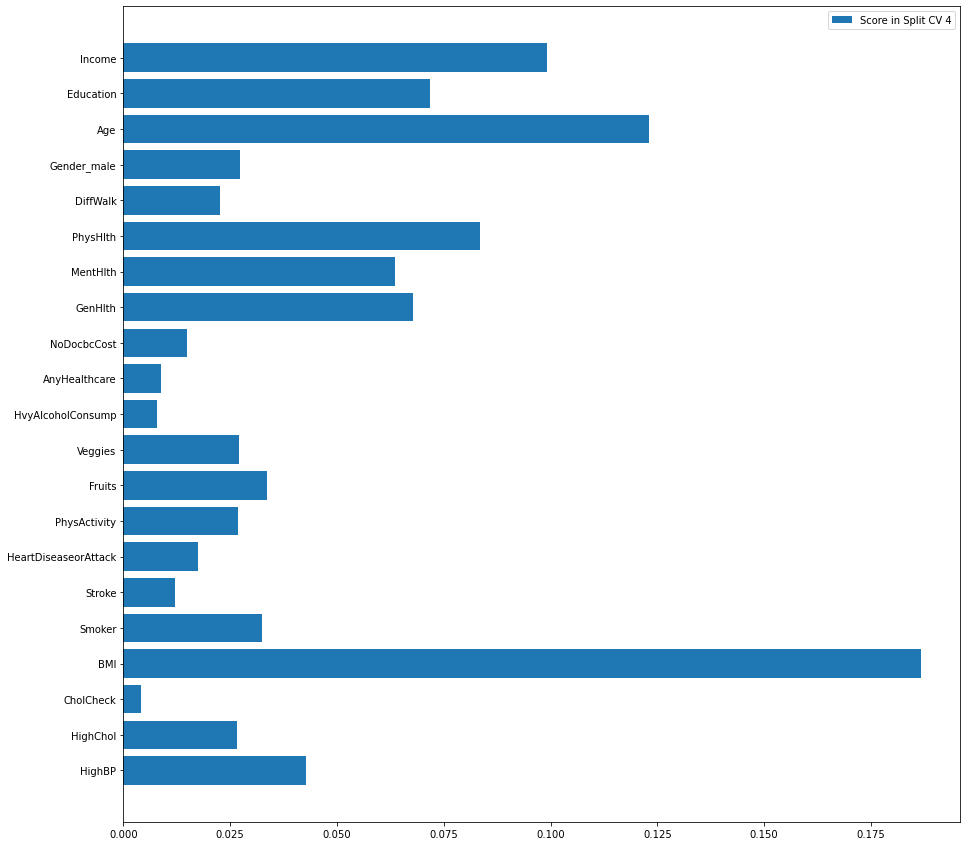

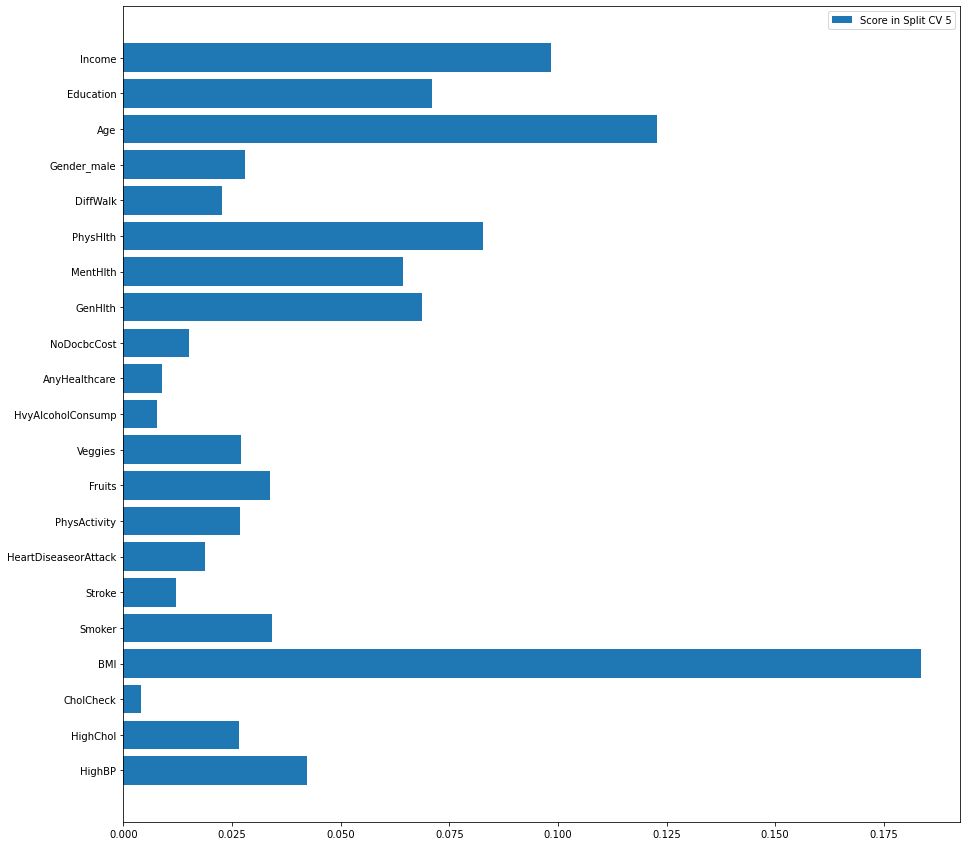

In [194]:
# Initialisierung eines RandomForestClassifiers zur Ausgabe der Feature Importance über den 'feature_importances_'-Parameter
rfc_feature_importance1 = RandomForestClassifier()

# Ausgabe der Feature Importance mit unskalierten Features
rfc_feature_importances = plot_model_feature_importance(x_values, y_value, rfc_feature_importance1, skf5)

##### Darstellung in einem DataFrame

In [195]:
pd.set_option('display.max_columns', None)
rfc_feature_importances

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
Split 2,0.041801,0.028146,0.004064,0.185261,0.033833,0.012240,0.018264,0.025845,0.033422,0.026014,0.007843,0.008654,0.015170,0.067718,0.064058,0.083689,0.023546,0.028055,0.123090,0.070953,0.098336
Split 3,0.039692,0.028071,0.004139,0.183690,0.033969,0.012055,0.018703,0.027610,0.033408,0.026734,0.007983,0.008805,0.015379,0.067363,0.063672,0.083587,0.024144,0.026920,0.123306,0.071755,0.099015
Split 4,0.041690,0.027285,0.004016,0.183990,0.033777,0.012332,0.017808,0.026943,0.033528,0.027137,0.008039,0.008680,0.014949,0.068096,0.064302,0.083218,0.022311,0.027883,0.123020,0.070984,0.100013
Split 5,0.042812,0.026531,0.004047,0.186657,0.032516,0.012069,0.017496,0.026870,0.033528,0.027043,0.007863,0.008906,0.014984,0.067826,0.063579,0.083462,0.022588,0.027353,0.123026,0.071678,0.099165
Split 6,0.042294,0.026682,0.004034,0.183472,0.034252,0.012063,0.018696,0.026910,0.033772,0.026976,0.007786,0.008854,0.015196,0.068813,0.064405,0.082869,0.022749,0.027883,0.122773,0.071072,0.098450


##### Interpretation - Feature Importance (RandomForestClassifier)

Der erste Punkt, der bei der Betrachtung der Feature Importance in unterschiedlichen Splits auffällt, ist, dass die **Ergebnisse der einzelnen Splits nur geringfügig voneinander abweichen**. Dies ist sowohl ein Indikator dafür, dass der **Split mit 5 Folds ausreichend** ist, als auch dafür, dass die **Feature Selection später bereits vor dem Modelling** durchgeführt werden kann. Betrachtet man nun speziell die Ergebnisse der Feature Selection aus dem RandomForestClassifier, so können also eindeutig Features angegeben werden, die hier wichtig sind.

Allerdings muss gesagt werden, dass beim vorliegenden Datensatz kein Feature als wirklich unwichtig deklariert wird. Speziell die Features, deren Ausprägungen nicht nur binäre Werte annehmen können, scheinen laut dem RandomForestClassifier eine wichtige Rolle zu spielen. Nach Interpretation der Visualisierungen sind die **wichtigsten Features** in diesem Fall die Folgenden:

1. BMI
2. Age
3. Income
4. PhysHlth
5. Education
6. GenHlth
7. MentHlth
8. HighBP
9. Smoker/ Fruits

Bei allen weiteren Features kommt es hier zu einem leichten Einbruch der Feature Importances. Komischerweise scheint hier zum Beispiel das Feature 'HvyAlcoholConsumption' keine tragende Rolle zu spielen, obwohl dies eigentlich als Risikofaktor für Diabetes gilt. Auch eine nähere Betrachtung der Visualisierung in Kapitel 2.6.2 bestätigt diesen nicht vorliegenden Zusammenhang zwischen dem Alkoholkonsum und dem Diabetesstatus.

Hier besteht die Überlegung, ob das Feature 'HvyAlcoholconsumption' des Datensatzes, welches angibt, ob eine Person über 14 (bei weiblichen Patienten über 7) alkoholische Getränke pro Woche konsumiert, geeignet ist, um Aufschluss über den tatsächlichen Alkoholkonsum einer Person zu geben. Darüber hinaus entstammen die Werte aus einer Telefonumfrage, wodurch offen bleibt, ob alle Antworten hier wahrheitsgemäß erfolgten.

##### Verwendung des skalierten Datensatzes für die Feature Importance - Random Forest Classifier

Da es etwas verwunderlich erschien, dass die Feature Importances laut dem Random Forest Classifier überwiegend die Features, die nicht nur binär sein können als wichtig einstuft, kam die Überlegung auf, ob dies am unskalierten Datensatz liegen könnte. Deshalb wird anschließend das Ergebnis nochmals mit normalisierten Werte validiert.

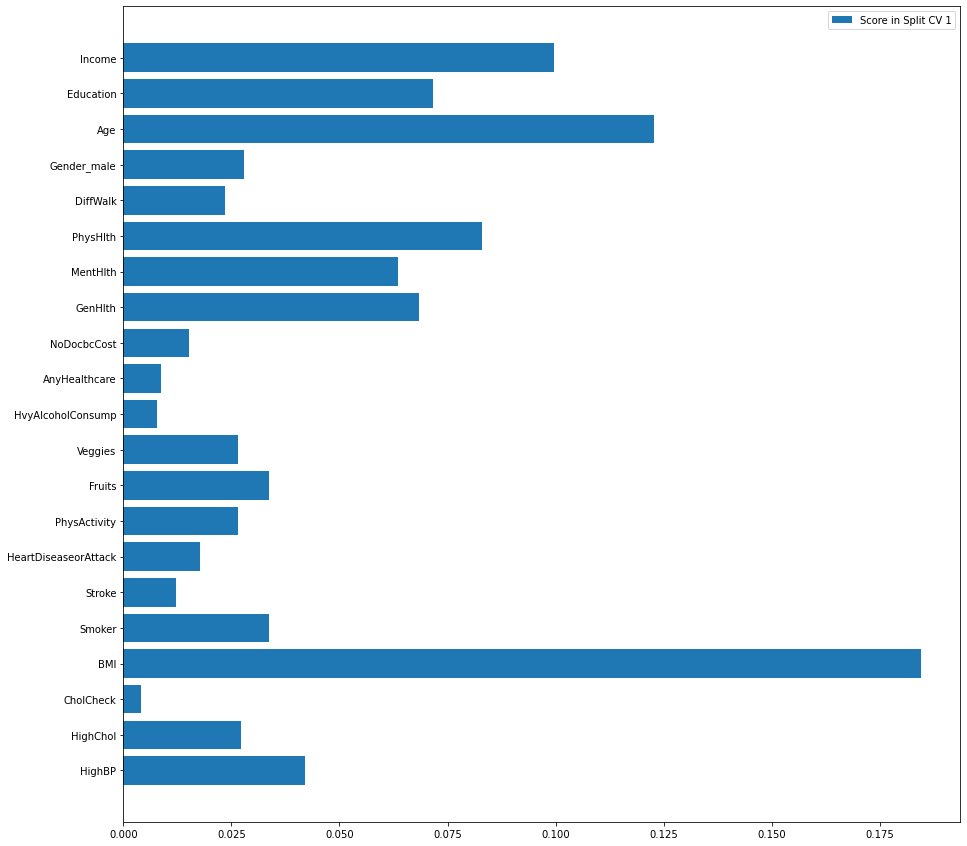

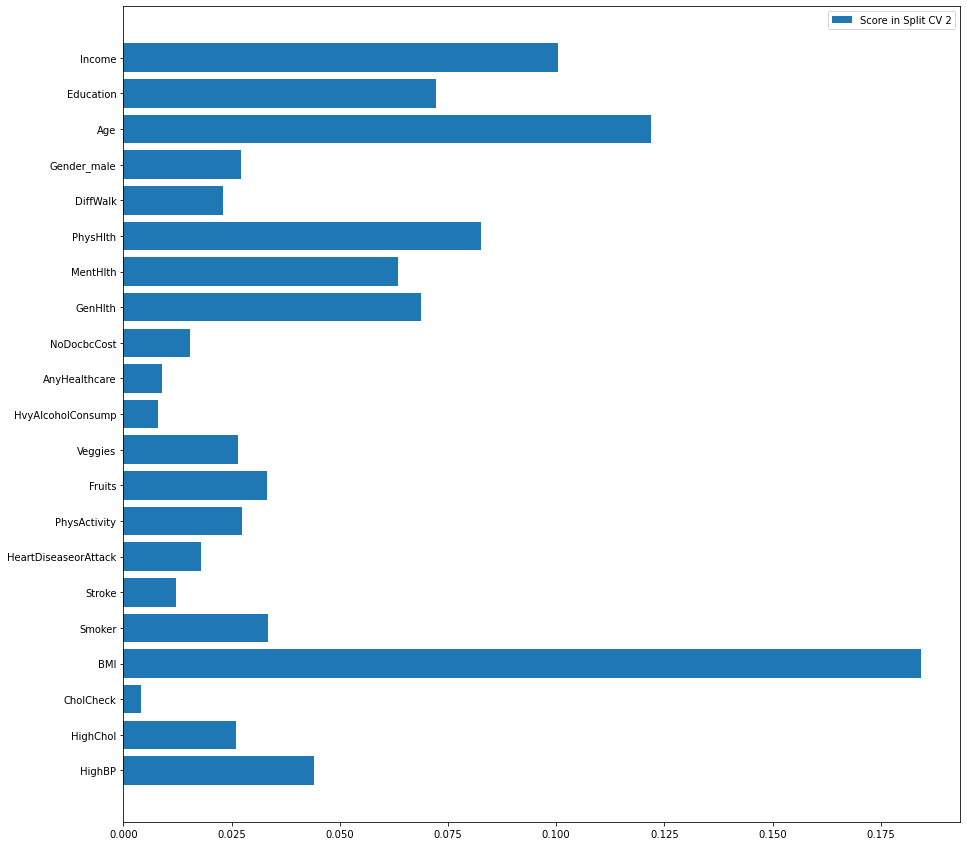

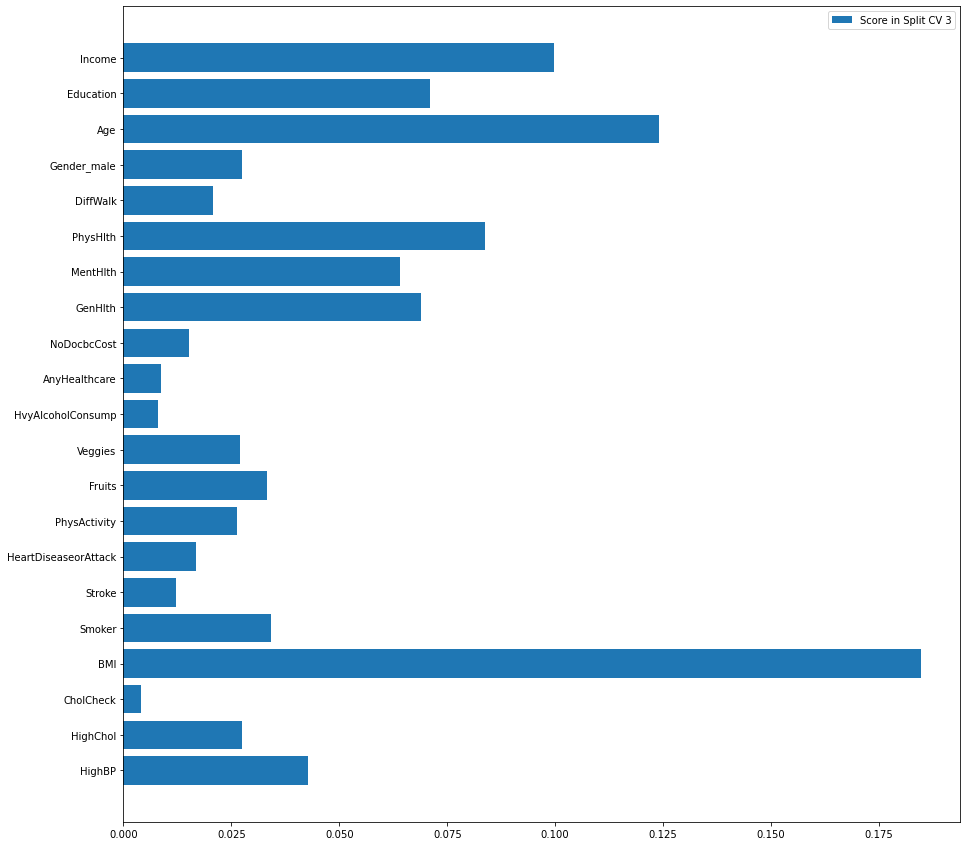

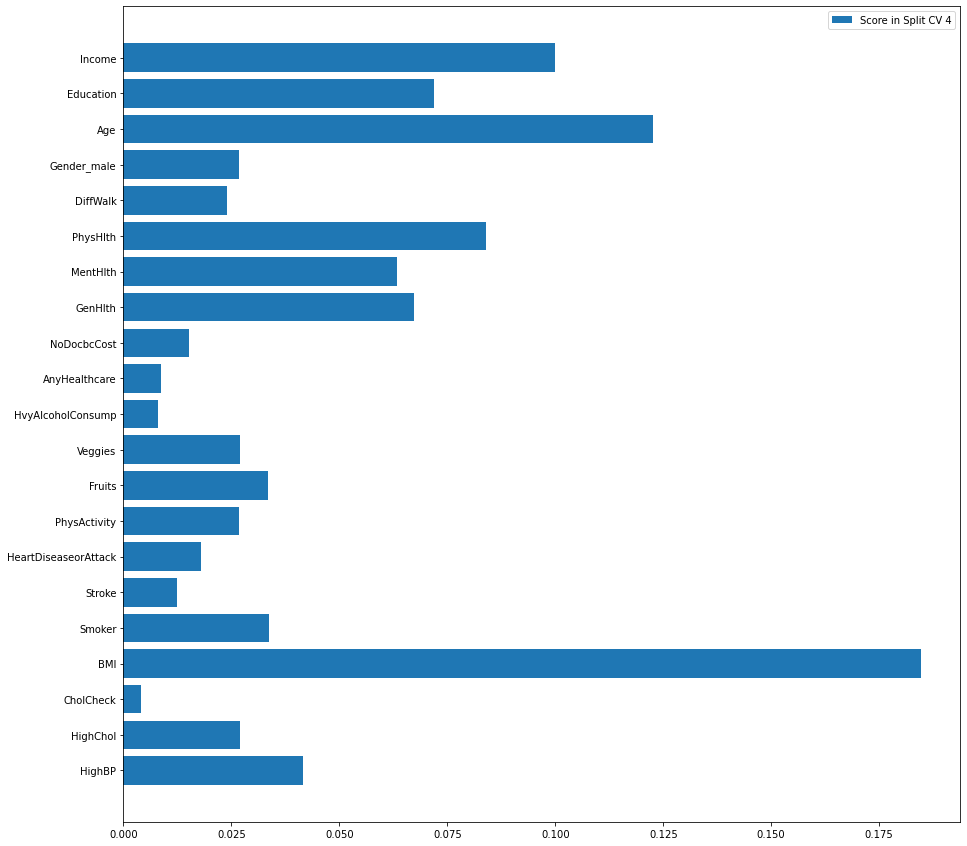

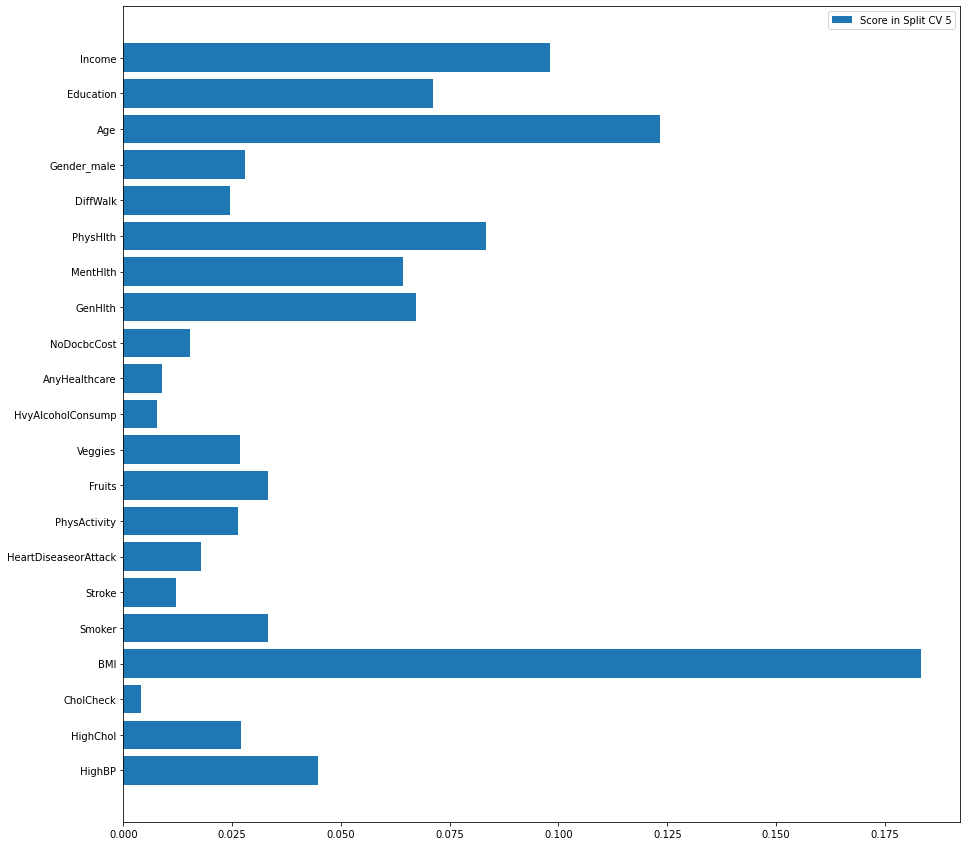

In [196]:
# Initialisierung eines RandomForestClassifiers zur Ausgabe der Feature Importance über den 'feature_importances_'-Parameter
rfc_feature_importance2 = RandomForestClassifier()

# Ausgabe der Feature Importance mit unskalierten Features
rfc_feature_importances2 = plot_model_feature_importance(x_values_mm, y_value, rfc_feature_importance2, skf5)

In [197]:
rfc_feature_importances2

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Gender_male,Age,Education,Income
Split 2,0.042110,0.027174,0.004016,0.184482,0.033654,0.012071,0.017718,0.026428,0.033713,0.026421,0.007825,0.008707,0.015102,0.068477,0.063560,0.083072,0.023537,0.028000,0.122781,0.071570,0.099582
Split 3,0.043966,0.026044,0.003977,0.184219,0.033344,0.012066,0.017877,0.027299,0.033231,0.026398,0.007919,0.008797,0.015302,0.068709,0.063493,0.082592,0.022948,0.027247,0.121999,0.072148,0.100424
Split 4,0.042690,0.027502,0.004129,0.184623,0.034138,0.012148,0.016698,0.026277,0.033333,0.026999,0.008051,0.008742,0.015206,0.068928,0.064084,0.083626,0.020709,0.027487,0.123933,0.071028,0.099668
Split 5,0.041636,0.026885,0.003988,0.184590,0.033756,0.012393,0.017913,0.026752,0.033383,0.027028,0.008114,0.008758,0.015097,0.067167,0.063345,0.083929,0.024077,0.026773,0.122593,0.071920,0.099901
Split 6,0.044785,0.027132,0.004063,0.183232,0.033170,0.012004,0.017789,0.026250,0.033255,0.026829,0.007681,0.008942,0.015214,0.067184,0.064241,0.083403,0.024414,0.028004,0.123268,0.071145,0.097996


##### Interpretation - Verwendung der skalierten Daten (Feature Importance mit RFC)

Es ist erneut zu erkennen, dass die **Ergebnisse in den unterschiedlichen Splits nicht bzw. nur kaum voneinander abweichen**. Darüber hinaus ist im Vergleich zum vorherigen Test mit unskalierten Werten **keine Veränderung** der Ergebnisse zu erkennen. Dies bestätigt die Annahme vom Anfang, dass hier unskalierte Werte ausreichend sind.  

##### Quellen

Scaling mit dem RandomForestClassifier: *https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf*

OneHotEncoding mit dem RandomForestClassifier: *https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769#:~:text=One%2Dhot%20encoding%20categorical%20variables,importance%20resulting%20in%20poorer%20performance.*

#### 3.3.2.3 XGBoost Classifier - Feature Importance

Ein weiterer Machine Learning Algorithmus, der über den 'feature_importances_'-Parameter verfügt und somit für die Ermittlung der Feature Importance hinzugezogen werden kann, ist der XGBClassifier. Hier ist die Verwendung der OneHot-encodeten Features möglich, weshalb im Folgenden sowohl die Ermittlung der Werte für die ursprünglichen Features, als auch für die encodeten Features, durchgeführt wird.

Ein wichtiger Punkt, den es bei der Interpretation der Feature Importance aus dem XGBoost Classifier zu beachten gilt, ist der **'importance_type'-Parameter** des XGBClassifiers, der für unterschiedliche Ergebnisse bei der Feature Importance sorgt. Hierbei stehen ein paar Methoden zur Auswahl, die die Feature Importance alle auf unterschiedliche Weisen berechnen. Nach mehrmaligem Testen aller Parameteroptionen, waren die Ergebnnisse für **'importance_type'='total_gain'** am besten mit den Ergebnissen aus der Visualisierung vereinbar, sodass dieser Parameter im Folgenden so gesetzt wurde. Darüber hinaus ergab eine Internetrecherche, dass die Ergebnisse hier am besten mit der Feature Importance aus dem Random Forest Classifier vergleichbar sein sollen.

##### Ausgabe der Feature Importance ohne OneHot-encodete Features

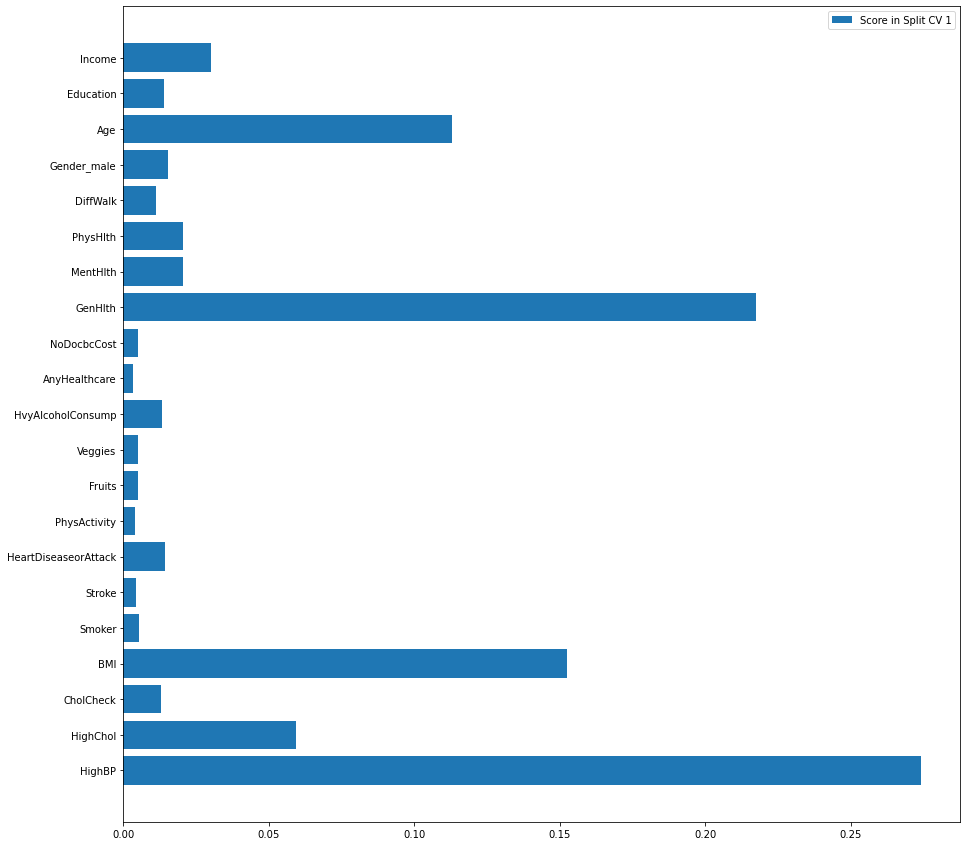

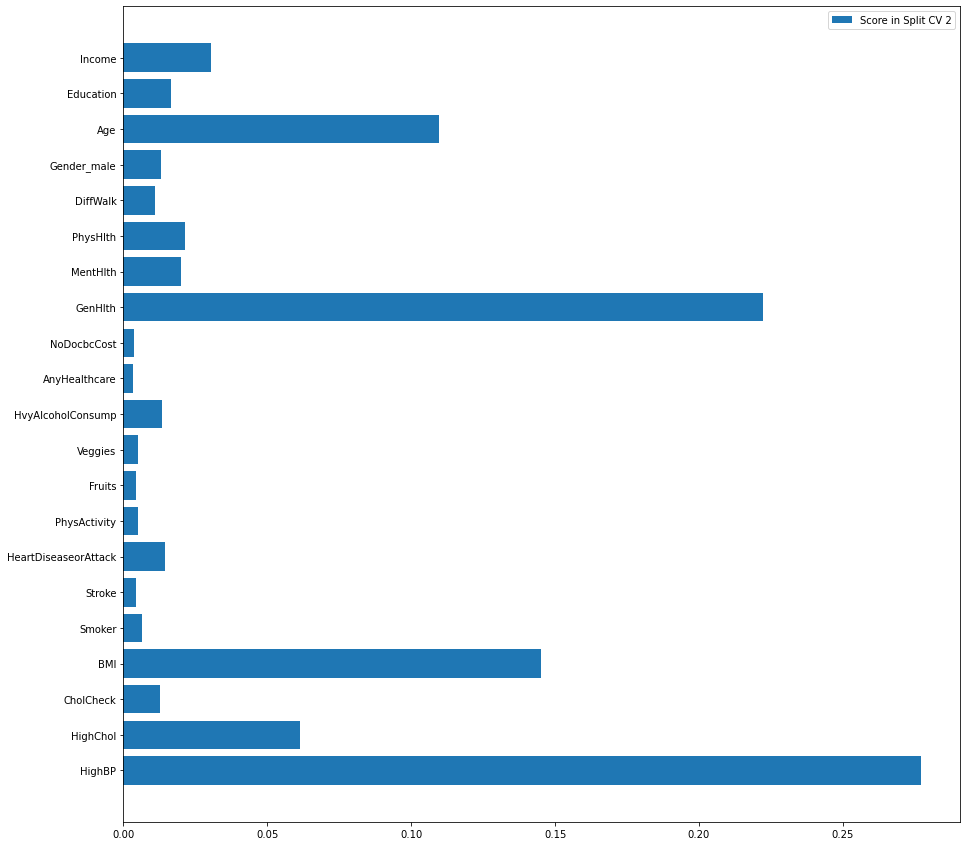

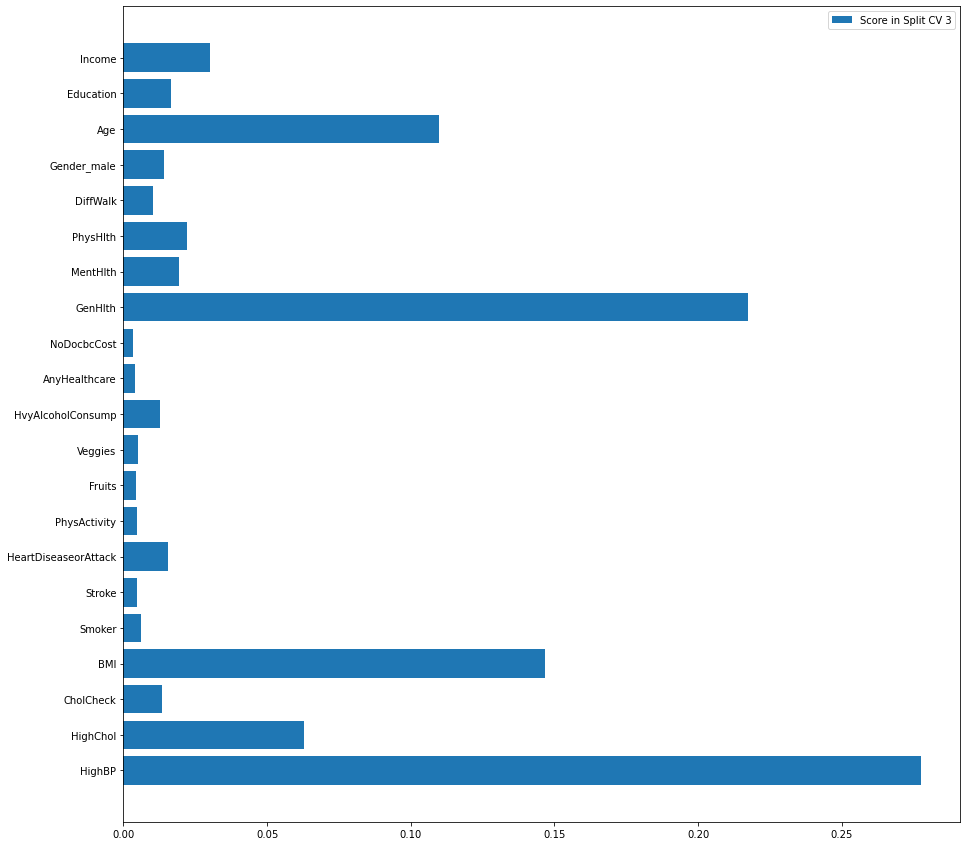

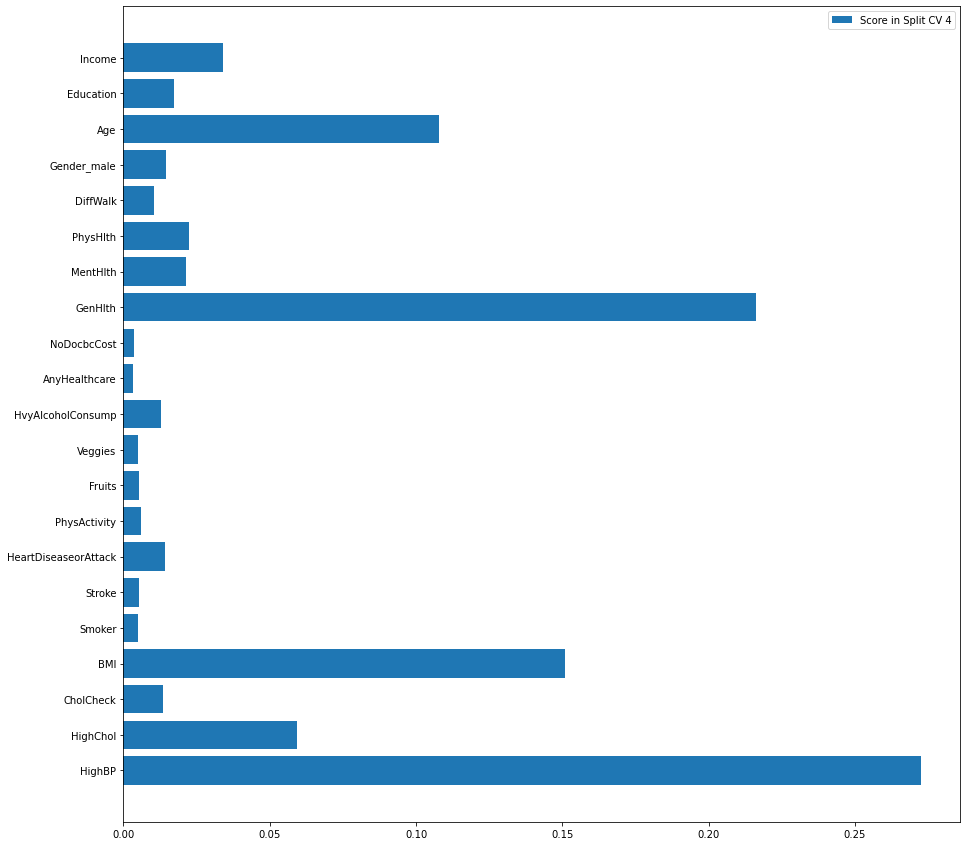

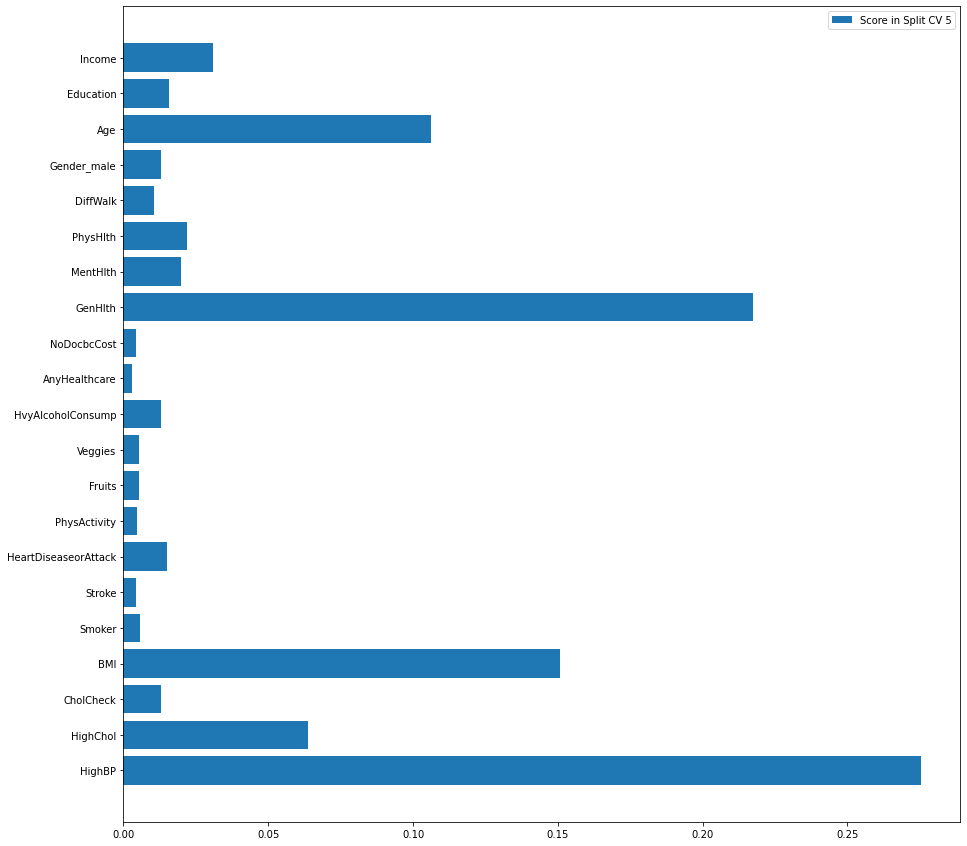

{'HighBP': 0.2752406,
 'HighChol': 0.063769154,
 'CholCheck': 0.012975688,
 'BMI': 0.15077265,
 'Smoker': 0.005844792,
 'Stroke': 0.0044899504,
 'HeartDiseaseorAttack': 0.014990359,
 'PhysActivity': 0.004812382,
 'Fruits': 0.005444861,
 'Veggies': 0.0054700174,
 'HvyAlcoholConsump': 0.012885451,
 'AnyHealthcare': 0.0028884595,
 'NoDocbcCost': 0.004385118,
 'GenHlth': 0.21747504,
 'MentHlth': 0.019783014,
 'PhysHlth': 0.021928275,
 'DiffWalk': 0.010693082,
 'Gender_male': 0.013080812,
 'Age': 0.10619765,
 'Education': 0.015846211,
 'Income': 0.031026375}

In [112]:
# Initialisierung eines XGBClassifier
xgb_feature_importance = XGBClassifier(importance_type='total_gain')

# Ausgabe der Feature Importance des XBGClassifiers über 'feature_importances_'-Parameter
plot_model_feature_importance(x_values_mm, y_value, xgb_feature_importance, skf5)

##### Ausgabe der Feature Importance mit OneHot-encodeten Features

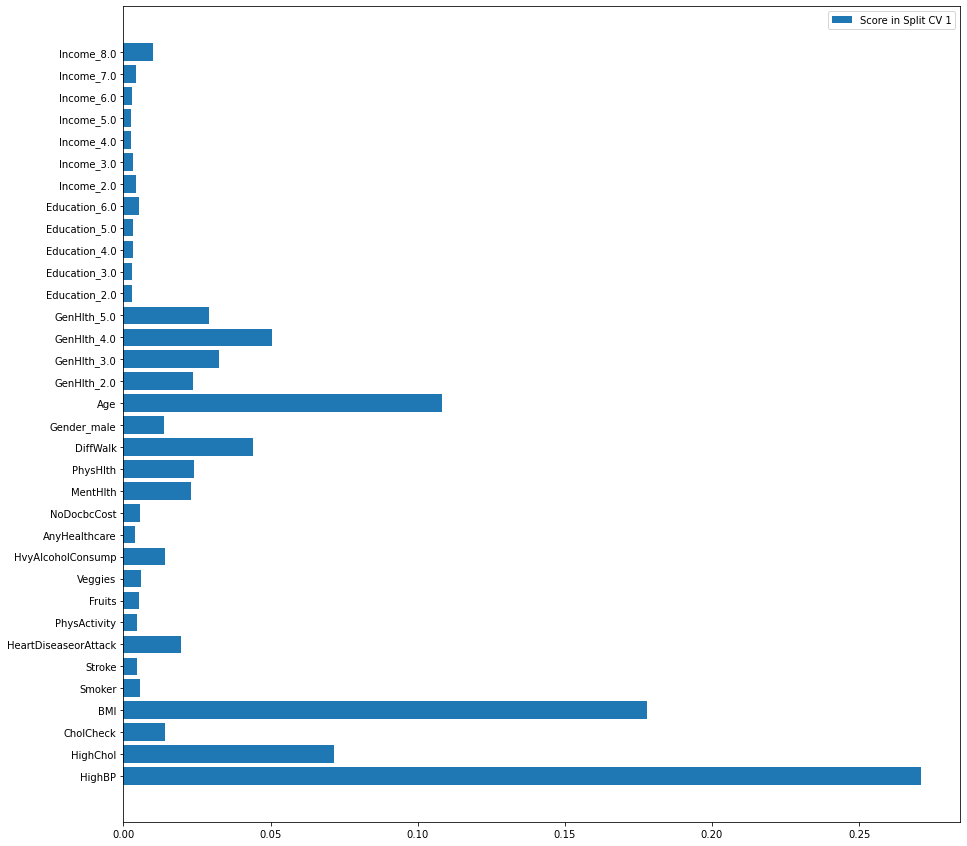

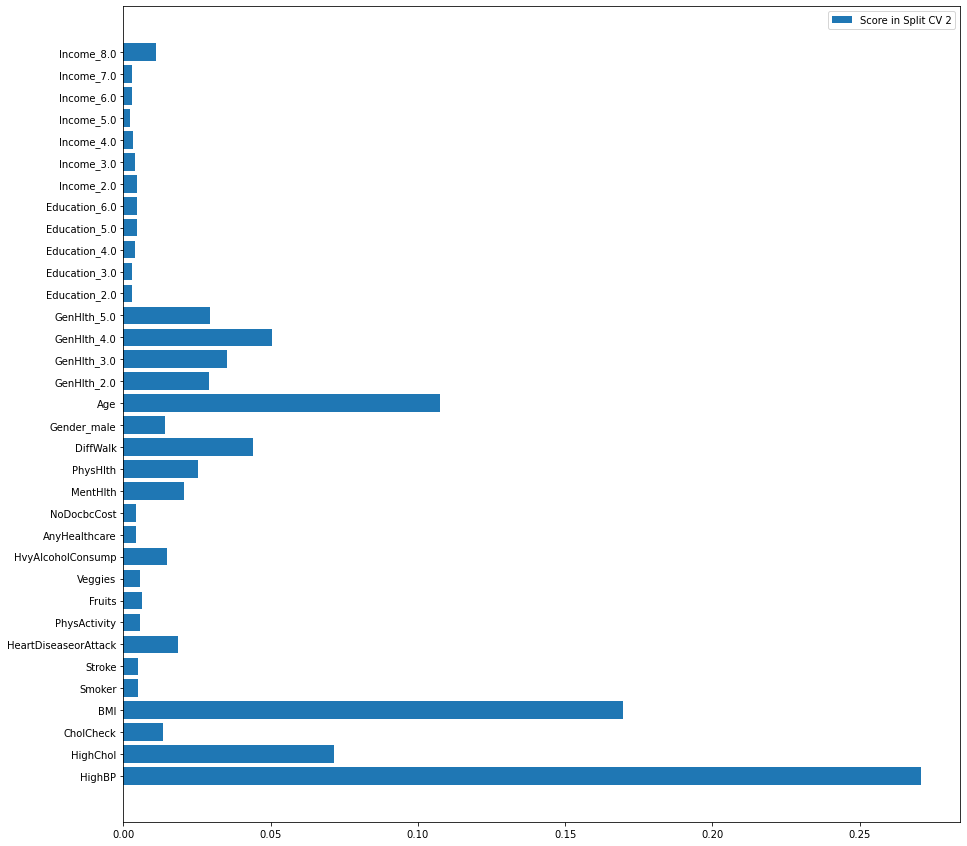

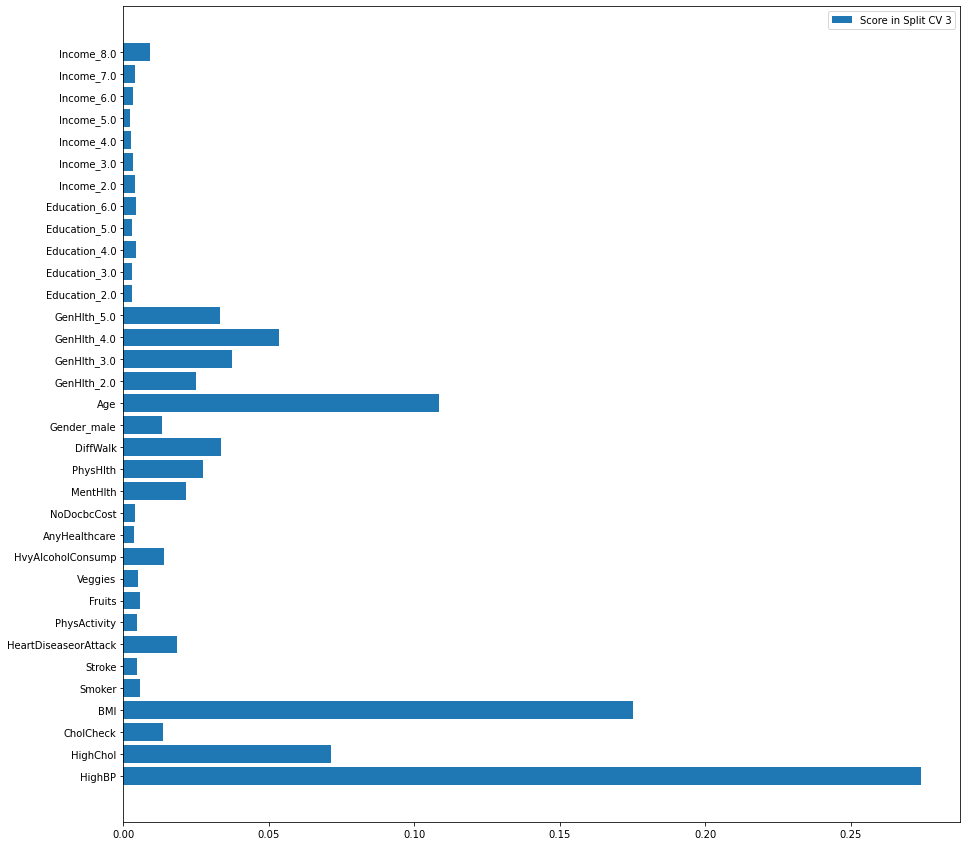

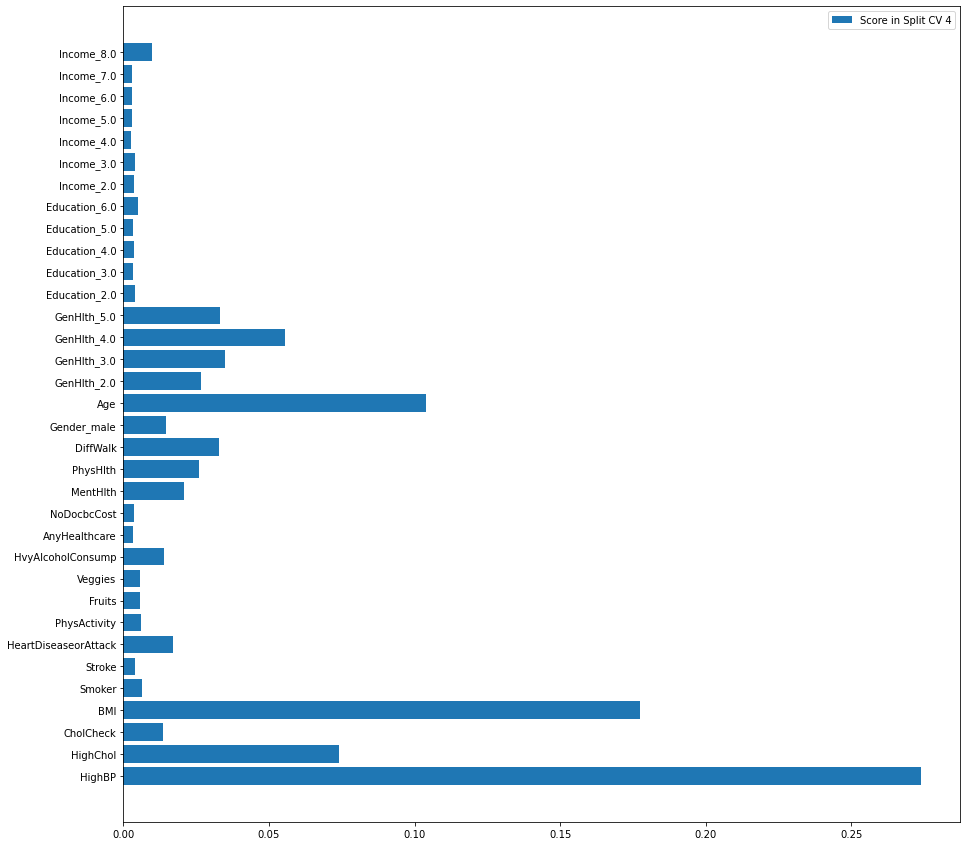

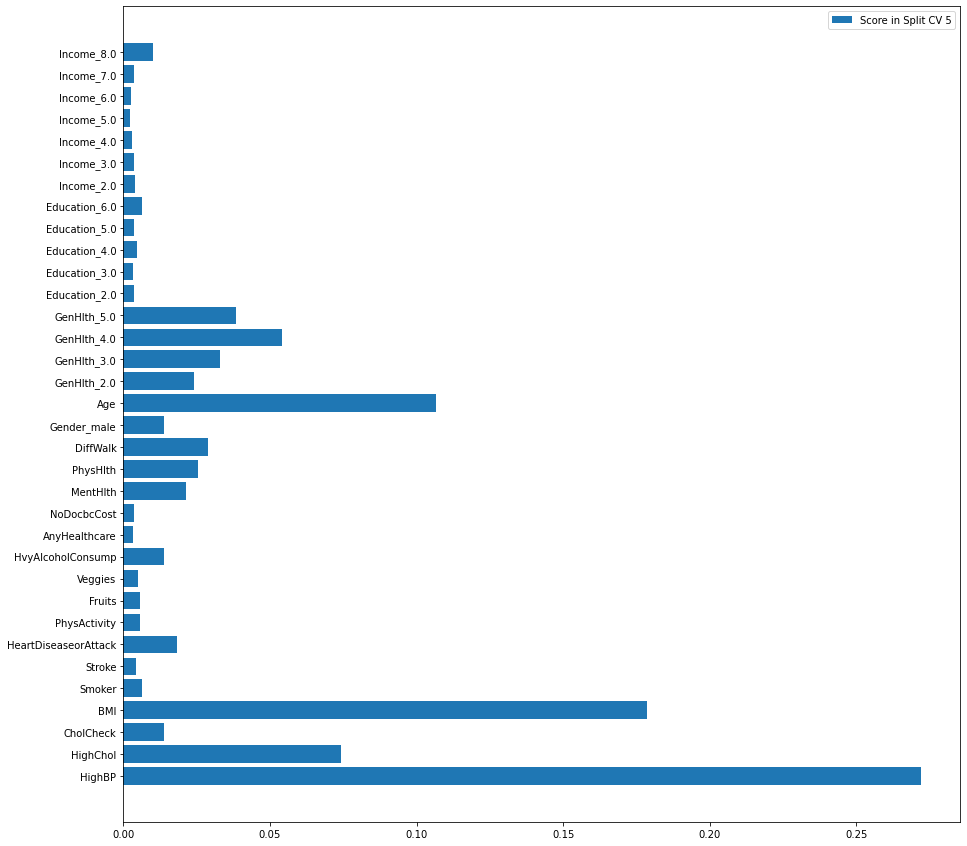

{'HighBP': 0.27188095,
 'HighChol': 0.07435239,
 'CholCheck': 0.0139938025,
 'BMI': 0.17847662,
 'Smoker': 0.0061901943,
 'Stroke': 0.0044171317,
 'HeartDiseaseorAttack': 0.018294176,
 'PhysActivity': 0.0057733944,
 'Fruits': 0.0057549323,
 'Veggies': 0.0050828313,
 'HvyAlcoholConsump': 0.013711577,
 'AnyHealthcare': 0.003377372,
 'NoDocbcCost': 0.0036559994,
 'MentHlth': 0.021209272,
 'PhysHlth': 0.025372637,
 'DiffWalk': 0.02899512,
 'Gender_male': 0.013661675,
 'Age': 0.10662528,
 'GenHlth_2.0': 0.024181768,
 'GenHlth_3.0': 0.032867577,
 'GenHlth_4.0': 0.053968914,
 'GenHlth_5.0': 0.03823258,
 'Education_2.0': 0.0035149246,
 'Education_3.0': 0.003228214,
 'Education_4.0': 0.0045738094,
 'Education_5.0': 0.0034901157,
 'Education_6.0': 0.0063395887,
 'Income_2.0': 0.0040300083,
 'Income_3.0': 0.0034613283,
 'Income_4.0': 0.0029002787,
 'Income_5.0': 0.0021812704,
 'Income_6.0': 0.0025707104,
 'Income_7.0': 0.0034960236,
 'Income_8.0': 0.010137463}

In [114]:
# Ausgabe der Feature Importances mithilfe von selbst geschriebener Funktion
plot_model_feature_importance(x_onehot_mm, y_value, xgb_feature_importance, skf5)

##### Interpretation - Feature Importance XGBClassifier

Trotz der Wahl des 'importance_type'-Parameters für den XGBClassifier, welcher die beste Vergleichbarkeit der Ergebnisse der Feature Importance aus dem XGBClassifier mit der aus dem RandomForestClassifier liefern soll, **weichen die Ergebnisse** hier relativ deutlich von denen aus dem RandomForestClassifier **ab**. Dies liegt daran, dass es sich zwar bei beidem um baumbasierte Methoden handelt, der RandomForestClassifier aber auf **Bagging** basiert, während dem XGBClassifier das **Boosting-Verfahren** zu Grunde liegt.

Im Gegensatz zum RandomForestClassifier, bei dem kein Feature als total unwichtig eingestuft wurde, sind bei XGBoostClassifier ganz deutlich die **wichtigsten vier Features** erkennbar. Hierbei handelt es sich um **'BMI', 'GenHlth', 'Age' und 'HighBP'**. Anschließend folgt noch **'HighChol'**. Alle anderen Features scheinen hier nicht wirklich wichtig zu sein. 

Die gleichen Ergebnisse werden auch bei der Verwendung der OneHot-encodeten Daten erzielt, wobei hier der Durchschnittwert der jeweils nur erzeugten Features eines ursprünglichen Features interpretiert werden.  

Auch hier weichen die Ergebnisse in den unterschiedlichen Splits nicht, bzw. nur kaum, voneinander ab.

##### Quellen

Feature Importance in Python: *https://machinelearningmastery.com/calculate-feature-importance-with-python/*

Dokumentation XGBClassifier: *https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn*

'importance_type'-Parameter (XGBClassifier): *https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7*

### 3.3.3 Univariate Selection

Eine weitere Methode, um Informationen über die Nützlichkeit einzelner Features für das Modelling zu bekommen ist die Univariate Feature Selection. Hierbei handelt es sich um eine **'Filter-Methode'**, die die Beziehungen der einzelnen Features zum Target anhand statistischer Methoden ermittelt. Die univariate Feature Selection betrachtet nicht die Interaktion zwischen den einzelnen Features. Stattdessen wird die **Beziehung der einzelnen Features zum Target** jeweils **separat** betrachtet. Aus diesem Grund wurden hier **nicht die OneHot-encodeten Daten** verwendet, da hier die Beziehung der einzelnen entstandenen Variablen komplett verloren gehen würde, und die Ergebnisse nicht sinnvoll zu interpretieren wären.

Ein wichtiger Punkt, den man bei der univariaten Feature Selection beachten muss, ist das **Skalenniveau** der einzelnen Variablen. Hierbei muss strikt zwischen kategorischen und numerischen (kontinuierlichen) Features unterschieden werden, weshalb in einem Datensatz mit unterschiedlichen Skalenniveaus hier auch unterschiedliche Tests durchgeführt werden müssen.

##### Quellen

*https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/*

*https://towardsdatascience.com/mistakes-in-applying-univariate-feature-selection-methods-34c43ce8b93d*

#### 3.3.3.1 Vorbereitung - Univariate Selection

In [55]:
# Funktion um die Scores aus SelectKBest über einzelne StratifiedKFold-Splits in horizontalen Barplots darzustellen
def ufs_scaling_cv_plot_score(x_values, y_value, scaler, n_splits, score_func):
    print(f'Univariate Feature Selection mit Score-Func {str(score_func)} und Scaler {str(scaler)}')
    features = list(x_values.columns)
    if scaler != None:
        x_values_scaled = scaler.fit_transform(x_values)
    split_counter = 1
    for train_index, test_index in skf5.split(x_values, y_value):
        selected_features_list = []
        X_train, X_test = x_values.iloc[train_index], x_values.iloc[test_index]
        y_train, y_test = y_value.iloc[train_index], y_value.iloc[test_index]
        fs = SelectKBest(score_func=score_func, k='all')
        fs.fit(X_train, y_train)
        features = list(x_values.columns)
        plt.figure(figsize=(15,10))
        scores_normalized = fs.scores_ / np.amax(fs.scores_)
        plt.barh(features, scores_normalized, label='Score in Split CV ' + str(split_counter))
        plt.yticks(np.arange(0, len(features), step=1), features)
        plt.legend(loc='upper right')
        plt.show()
        split_counter += 1

#### 3.3.2.2 Auswahl der wichtigsten kategorischen Features

Zur Auswahl der wichtigsten kategorischen Features ist der **Chi-Quadrat-Test** geeignet. Dieser wurde eigentlich für nominalskalierte Features entwickelt, ist aber auch auf ordinalskalierte Features anwendbar. Allerdings gehen hier bei der Skalentransformation auch Informationen bezüglich der Rangordnung verloren. Im vorliegenden Datensatz sind die meisten kategorischen Features auch **nominalskaliert**, weswegen diese Option hier recht gut geeignet ist. Bei der Anwendung des Chi-Quadrat-Tests ist darauf zu achten, dass vorher kein OneHot-encoding durchgeführt wird.

In [143]:
# DataFrame mit kategorischen Features
df_categorical_features = df.drop(['BMI', 'MentHlth', 'PhysHlth', 'Diabetes'], axis = 'columns')

##### Visualisierung der Scores aus SelectKBest mit MinMaxScaler (Chi-Quadrat-Test) 

Univariate Feature Selection mit Score-Func <function chi2 at 0x0000023D203FB670> und Scaler MinMaxScaler()


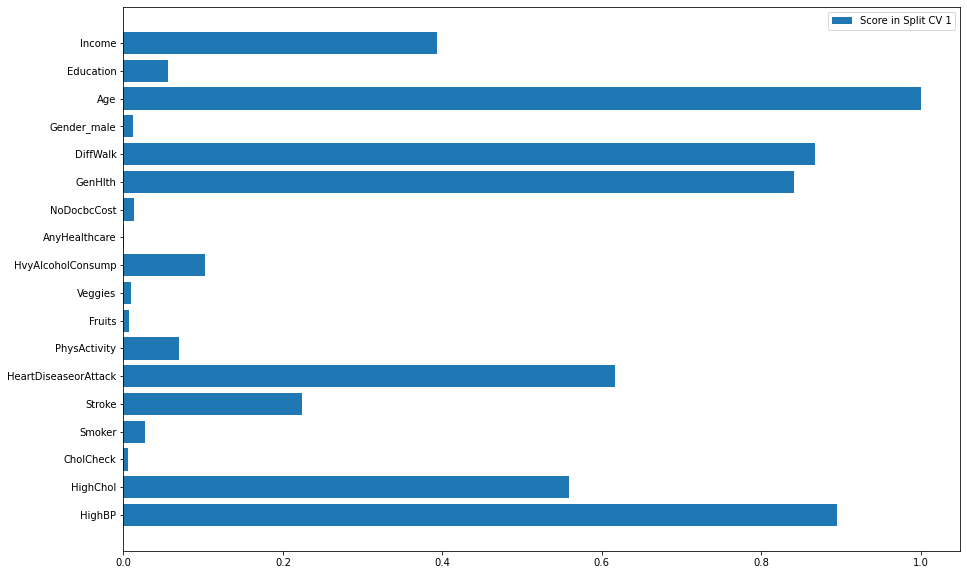

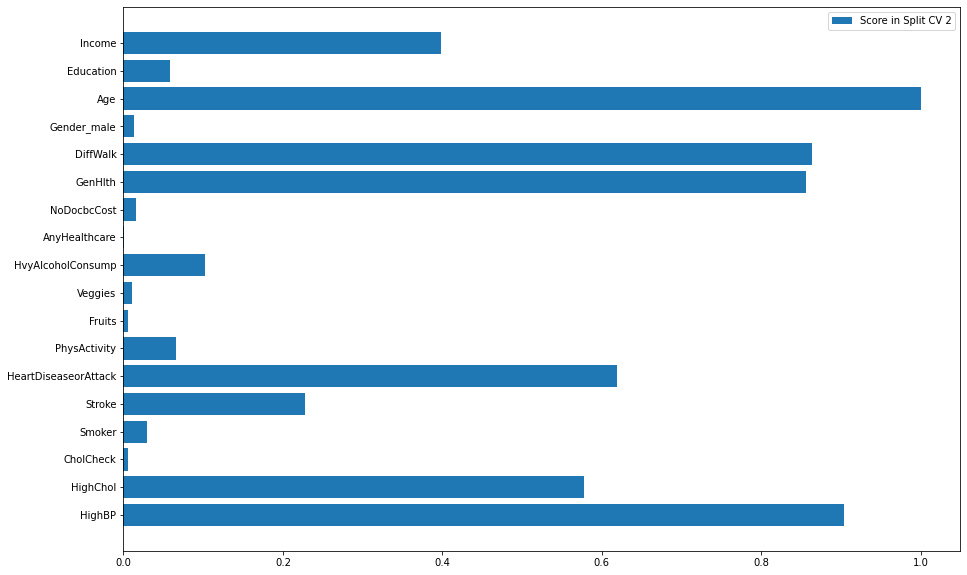

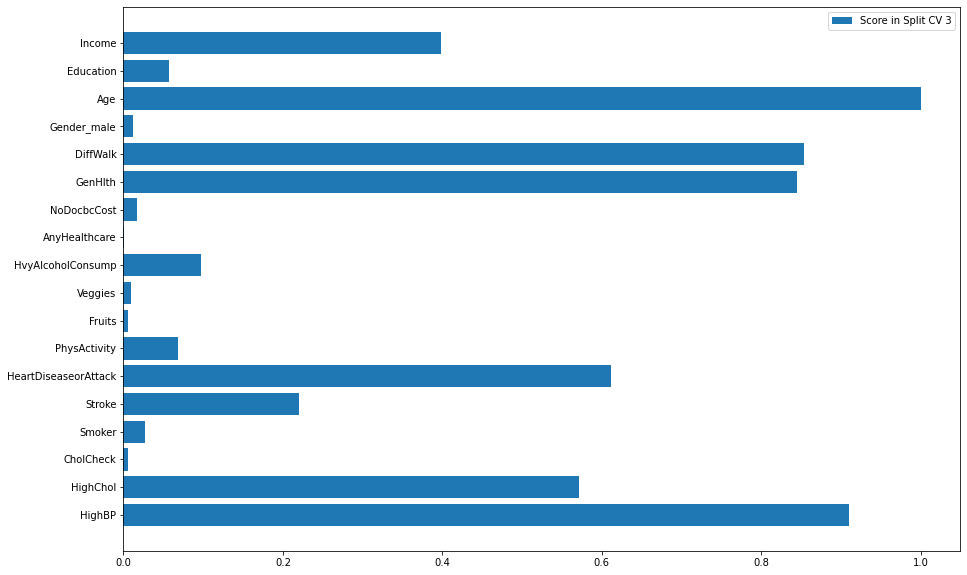

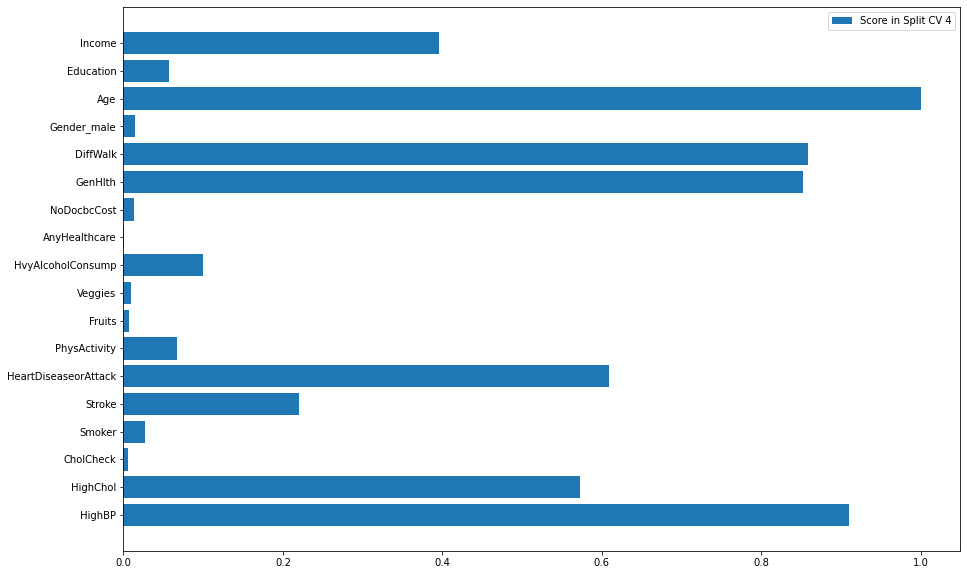

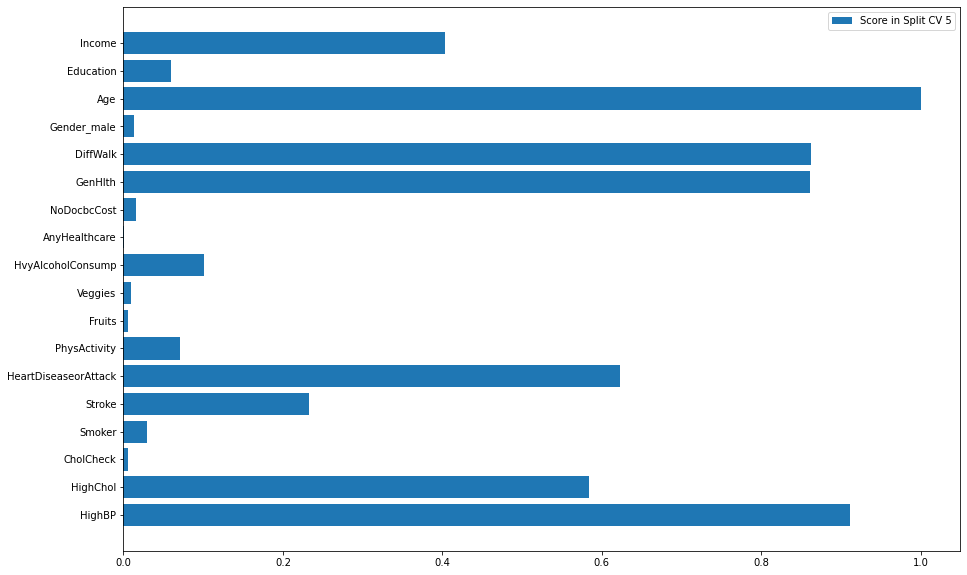

In [144]:
ufs_scaling_cv_plot_score(df_categorical_features, y_value, MinMaxScaler(), 5, chi2)

##### Interpretation - Auswahl der wichtigsten kategorischen Features (Chi-Quadrat-Test)

Es ist erneut zu erkennen, dass die Ergebnisse der einzelnen Splits nicht bzw. nur geringfügig voneinander abweichen. Auch hier sind, ähnlich wie bei der Feature Importance aus dem XGBClassifier die **wichtigsten Features** auf Anhieb zu erkennen. So handelt es sich hierbei um **'HighBP', 'HighChol', 'Age', 'GenHlth' und 'Income'**. Weitere wichtige Features sind 'DiffWalk' und 'HeartDiseaseorAttack'. Hier ist allerdings wie bereits in einem früheren Kapitel erwähnt kritisch zu begutachten, ob ein Patient beispielsweise Diabetes hat, weil er eine Herzkrankheit hatte oder anders herum. Gleiches gilt für das Feature 'Stroke'. 

##### Quellen zum Code (Feature Selection - SelectKBest)

Feature Selection mit kategorischen Daten: *https://machinelearningmastery.com/feature-selection-with-categorical-data/*

#### 3.3.2.2 Auswahl der wichtigsten numerischen Features

##### Visualisierung der Scores aus SelectKBest mit MinMaxScaler (ANOVA)

Univariate Feature Selection mit Score-Func <function f_classif at 0x0000023D203FB550> und Scaler MinMaxScaler()


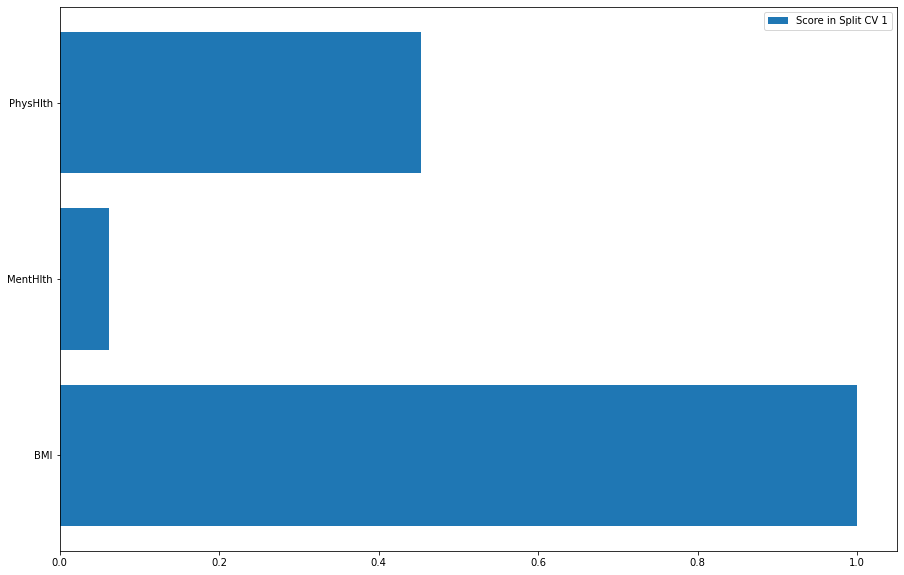

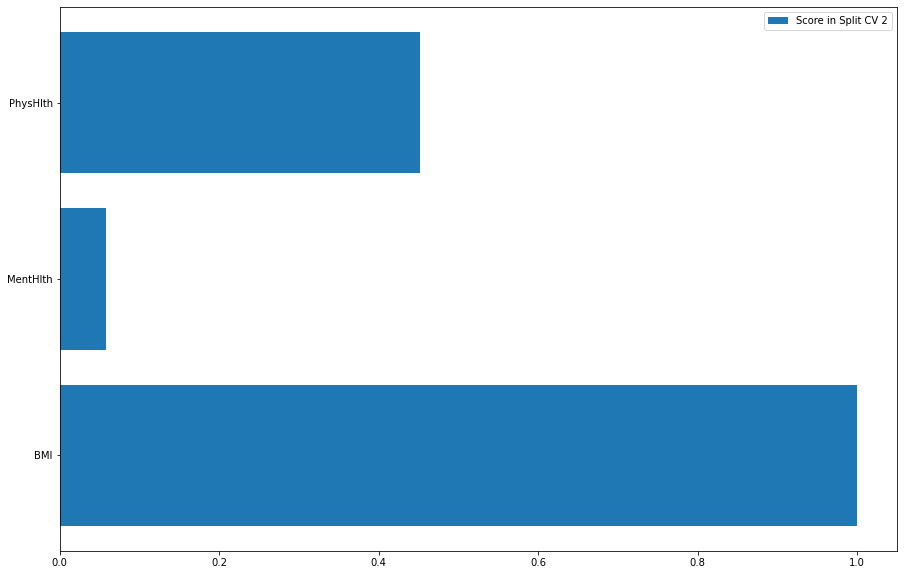

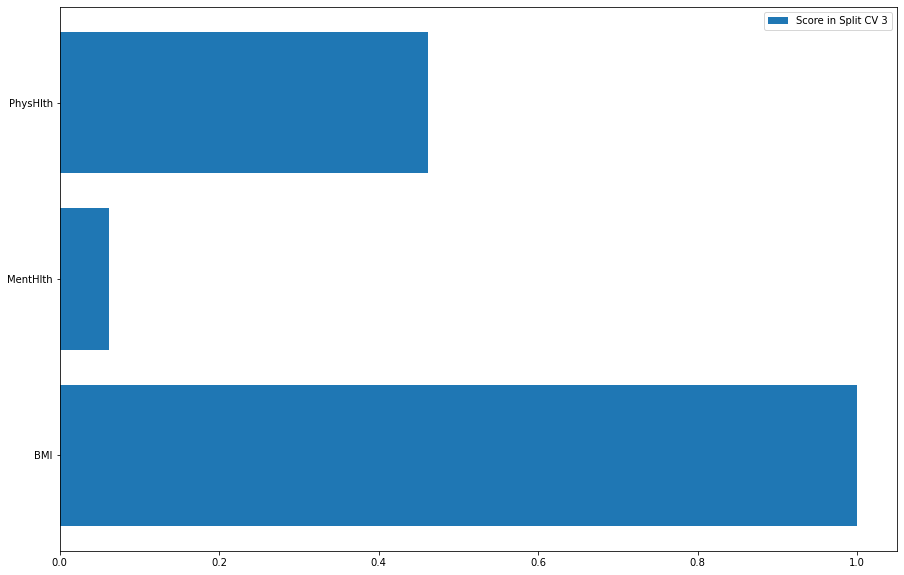

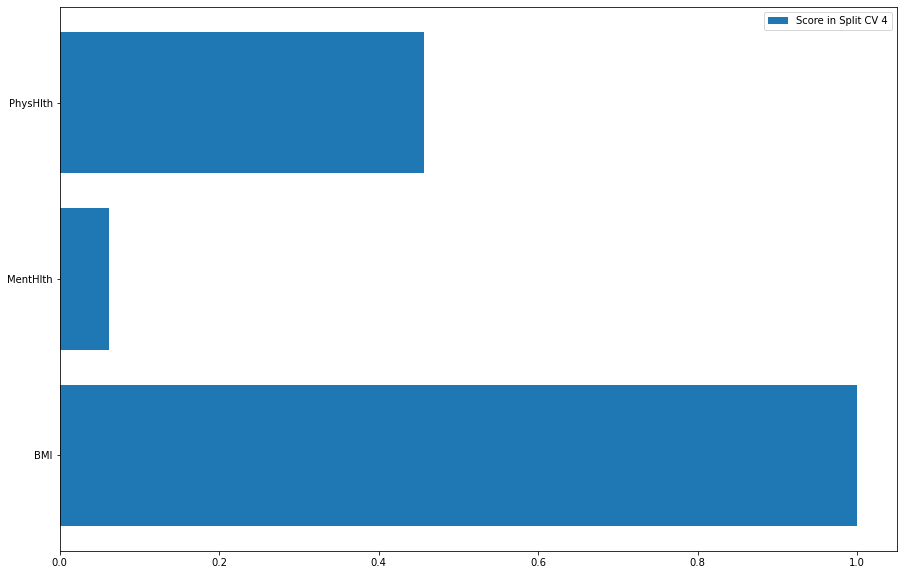

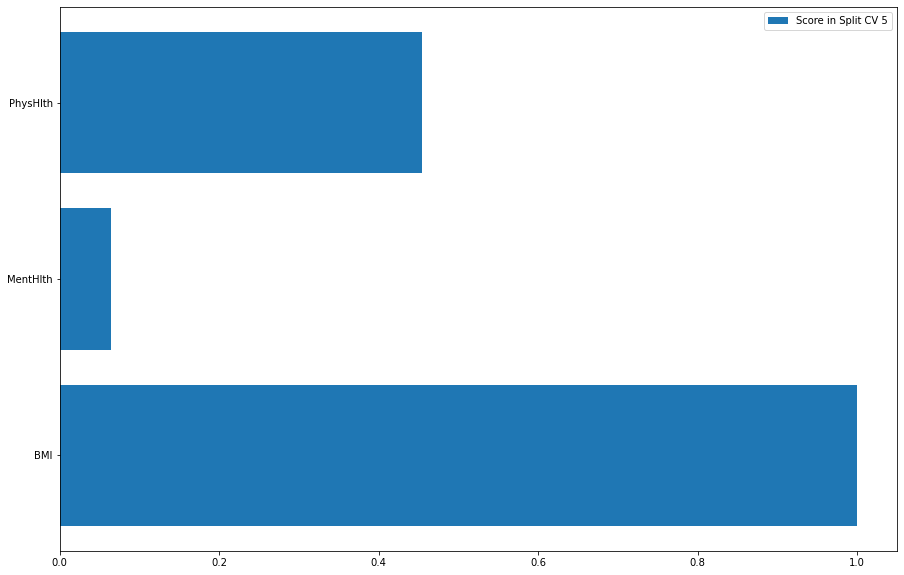

In [148]:
# Liste mit den numerischen (kontinuierlichen Features)
numerical_features = ['BMI', 'MentHlth', 'PhysHlth']

# Umwandlung der Liste in DataFrame 
df_numerical_features = df[numerical_features]

# visuelle Darstellung der Ergebnisse aus ANOVA (score-Funktion 'f_classif')
ufs_scaling_cv_plot_score(df_numerical_features, y_value, MinMaxScaler(), 5, f_classif)

##### Interpretation - SelectKBest (ANOVA)

Auch bei dieser Methode gibt es innerhalb der unterschiedlichen Splits keine Unterschiede. Während das Feature 'MentHlth' laut dieser Methode nur einen geringen Zusammenhang mit der Targetausprägung hat, werden die Features **'PhysHlth'** und vor allem **'BMI'** hier als wichtiger eingestuft.

##### Quellen (Feature Selection - SelectKBest)

*https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/*

### 3.4 Ergebnis - Feature Selection

Im bisherigen Verlauf des Notebooks wurden unter anderem verschiedene Methoden angewandt, die einen Eindruck darüber vermitteln sollen, welche Features einen besonders großen Einfluss auf die Ausprägungen der Targetvariablen haben. So gab es relativ zu Beginn die Visualisierungen, welche anschließend anhand von statistischen Tests überprüft wurden. Danach wurden einige Methoden zur Feature Importance beziehungsweise der Feature Selection angewandt. Im Folgenden werden die **Ergebnisse der verschiedenen Methoden zusammengetragen, interpretiert und anschließend verschiedene Feature Sets** gebildet. Durch das Entfernen von Features aus dem Datensatz soll überprüft werden, ob hierdurch das Ergebnis der Modelle nochmals verbessert werden kann. Aber auch bei gleichbleibenden Ergebnissen hätte es einen Vorteil, da hierdurch der **Rechenaufwand erheblich reduziert** werden kann, was vor allem bei der Support Vector Classification im vorliegenden großen Datensatz sehr von Vorteil ist.

### 3.4.1 Gesamtinterpretation - Feature Selection

Fässt man die Ergebnisse aus allen Methoden zusammen, so wird deutlich, dass es einige Variablen gibt, die häufiger auftreten. Hierzu zählen **'BMI', 'HighBP', 'HighChol', 'Age', 'Income', 'Smoker' und 'GenHlth'**. Darüber hinaus gab es auch für das Feature **'PhysActivity'** einen visuell erkennbaren Zusammenhang, der anschließend statistisch bestätigt werden konnte.

Die Features 'Education' und 'PhysHlth' werden weniger häufig von den unterschiedlichen Methoden als wichtig ausgegeben. Darüber hinaus ergab die Untersuchung des spearman-Rangkorrelationskoeffizienten in Kapitel 2.7.1.1 eine statistische Korrelation zwischen Education und Income bzw. PhysHlth und GenHlth. Da jeweils eine der Variablen bereits als wichtig in Bezug auf den Diabetesstatus einer Person eingestuft wurden, können **'Education' und 'PhysHlth' vorest außen vor gelassen** werden. Hierdurch wird zum einen nochmals der Rechenaufwand gesenkt, zum anderen kann die Verwendung von zwei korrelierenden Features die Güte eines Modells sogar schwächen.

Auch für die Features **'DiffWalk', 'Stroke' und 'HeartDiseaseorAttack'** sind zumindest bei er visuellen Betrachtung Zusammenhänge bezüglich der Targetausprägung zu erkennen. Allerdings ist hier, wie schon in einem früheren Kapitel erwähnt, nicht genau klar, ob eine Diabeteserkrankung eine Folge von z.B. Schwierigkeiten beim Laufen ist oder anders herum. Deshalb werden diese Features im Vorfeld **erstmal ausgeklammert**, und eventuell in einem späteren Verlauf nochmals hinzugezogen. 

### 3.4.2 Erstellung der Feature Sets

Zu Beginn der Projektarbeit wurde das erste Feature Set auf der Grundlage etwas anderer (teilweise fehlerhafter) Beobachtungen erstellt, welches anschließend verwendet wurde, um das Hyperparametertuning für die SVC durchzuführen. Eine Änderung dieser Implemenation ist aus zeittechnischen Gründen nicht mehr möglich. Allerdings zeigten verschiedenen Sensitivitätsanalysen für die anderen Machine Learning Algorithmen, dass eine Verwendung unterschiedlicher Daten das Ergebnis des Modells nicht signifikant beeinflussen.

Die meisten der damaligen Interpretationen stimmen mit den aktuellen Erkenntnissen überein. Allerdings wurden neben den aktuell gewählten Features auch Features wie 'HeartDiseaseorAttack' bzw. 'DiffWalk' mit ausgewählt. Darüber hinaus wurde 'HvyAlcoholConsump' verwendet, obwohl hier im bisherigen Verlauf keine Zusammenhänge zu erkennen sind, da Alkoholkonsum ein wichtiger Risikofaktor für Diabetes ist.

Zudem erfolgte die Erstellung des Feature Sets auf Grundlage eines Datensatzes, welcher mit dem StandardScaler skaliert wurde.

In [189]:
# Erstellung eines Feature Sets mit den wichtigsten 12 Features
x_features_selected12 = df[['BMI', 'HighChol', 'HighBP', 'CholCheck', 'Age', 'GenHlth', 'PhysHlth', 'Income',
                             'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'Smoker', 'DiffWalk']] 

x_sel_features12_ss_nb = df_scaled_ss_nb[['BMI', 'HighChol', 'HighBP', 'CholCheck', 'Age', 'GenHlth', 'PhysHlth', 'Income',
                                     'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'Smoker', 'DiffWalk']] 

Die Erstellung eines weiteren Feature Sets erfolgt auf Grundlage bereits balancierter Datensätze im folgenden Kapitel an geeigneter Stelle.

## 3.4 Ausgleich des unbalancierten Datensatzes

Der vorliegende Diabetes-Datensatz weist eine starke Unbalanciertheit auf. Neben klassischen Methoden, wie z.B. dem **StratifiedKFold**, der gewährleistet, dass die Ergebnisse innerhalb unterschiedlicher Splits ähnlich bleiben, gibt es auch **Scoringkenngrößen, wie den f1-Score**, die diese Unbalanciertheit für die Interpretation etwas ausgleichen.

Darüber hinaus gibt es Methoden, wie das **Over- und Undersampling**, die den Datensatz so verändern, dass ein balancierter Datensatz entsteht. Diese werden im Folgenden, im Rahmen der Data Preparation getestet, um später im Modelling getestet zu werden. 

### 3.4.1 SMOTE Oversampling

Beim Oversampling wird die **Anzahl der Featurevektoren mit geringerer Klassenausprägung** des Targets durch Hinzufügen neuer Zeilen, auf eine gewünschte Größe **erhöht**. Beim SMOTE-Oversampling werden hierbei nicht gezielt bestehende Zeilen dupliziert, sondern es wird versucht, neue Werte zu "synthetisieren". Hierbei werden Zeilen erzeugt, deren Ausprägungen der unterschiedlichen Features zwischen denen der bestehenden Featurevektoren liegen.

Dies hat natürlich den Vorteil, dass der Datensatz danach balanciert ist, und das Ergebnis nicht durch die Unbalanciertheit verfälscht wird. Allerdings kann ein extremes Oversampling auch zu **Problemen** führen. Hierzu zählt **z.B. Overfitting**, da durch das Hinzufügen neuer Zeilen, die eventuell ähnlich wie Bestehende sind, manche Werte häufiger ins Training gelangen können. Trotzdem wird im Folgenden das SMOTE Oversampling für den vorliegenden Datensatz implementiert. 

In [220]:
# Initialisierung eines SMOTE-Oversamplers 
oversample = SMOTE()

# Erstellung eines neuen Datensatzes/ Shapes mit oversampleten x- und y-Werten
x_smote, y_smote = oversample.fit_resample(x_values, y_value)

In [221]:
# Ausgabe der Klassenverteilung im oversampleten Datensatz
y_smote.value_counts()

0.0    189414
1.0    189414
Name: Diabetes, dtype: int64

##### Scaling der oversampleten Daten mit dem MinMaxScaler

In [226]:
x_smote_mm = scale_df(x_smote, MinMaxScaler())

##### Interpretation - SMOTE Oversampling

Es ist zu sehen, dass die Featurevektoren beider Targetausprägungen nun mit jeweils 189414 Patienten die **gleiche Anzahl** besitzen. Die Klassenverteilung im neuen Datensatz beträgt hier also **50% zu 50%**. Durch eine andere Wahl des 'sampling_strategy'-Parameters hätte diese Verteilung nochmals beeinflusst werden.

### 3.4.2 Random Undersampling

Eine weitere Methode, um den unbalancierten Datensatz auszugleichen, ist das **Undersampling**. Im Gegensatz zum Oversampling werden hier Featurevektoren der größeren Targetausprägung aus dem Datensatz entfernt, sodas am Ende wieder ein balancierter Datensatz entsteht. Eine gängige Methode hierfür ist die Verwendung des **RandomUnderSamplers**. Hierbei erfolgt die Auswahl der zu entfernenden Zeilen zufällig.

Ähnlich wie beim Oversampling, weist auch das Undersampling negative Aspekte auf. Hierzu zählt offensichtlich der **Verlust von Daten**, die durch das Undersampling nicht in das Modell gelangen können.

In [73]:
# Initialisierung eines RandomUnderSamplers
undersample = RandomUnderSampler()

# Erstellung eines neuen Datensatzes/ Shapes mit undersampleten x- und y-Werten
x_randomunder, y_randomunder = undersample.fit_resample(x_values, y_value)

In [16]:
# Ausgabe der Klassenverteilung im undersampleten Datensatz
y_randomunder.value_counts()

0.0    39466
1.0    39466
Name: Diabetes, dtype: int64

##### Interpretation - Random Undersampling

Es ist zu erkennen, dass beide Targetausprägungen nach dem RandomUndersampling noch **39499 Feature Vektoren** aufweisen. Die größere Klasse wurde also auf die Anzahl der kleineren Klasse **verkleinert**.

##### Scaling der undersampleten Features mit dem MinMaxScaler

Zur späteren Verwendung der Daten im Modelling, bei der MLPClassification (Kapitel 6.1), werden im Folgenden die undersampleten Daten mit dem MinMaxScaler skaliert. Die Wahl des Scalers wurde bereits in einem vorherigen Kapitel näher erläutert. 

In [80]:
# Skalieren der x-Werte mit der selbst geschriebenen 'scale_df'-Funktion
x_randomunder_mm = scale_df(x_randomunder, MinMaxScaler())

##### Feature Set 1 (Undersampling + StandardScaler)

In [37]:
x_important_under, y_important_under = undersample.fit_resample(x_sel_features12_ss_nb, y_value)

##### Feature Set 2 (Undersampling + MinMaxScaler)

In [167]:
x_sel8_under_mm = x_randomunder_mm[['BMI', 'Age', 'Income', 'Smoker', 'PhysActivity', 'HighBP', 'HighChol', 'GenHlth']]

### 3.4.3 Kombination aus Over- und Undersampling

Aufgrund der **oben angesprochenen Nachteile**, die das Oversampling bzw. Undersampling mit sich bringt, wenn es einzeln durchgeführt wird, ist es in der Praxis üblich, eine **Kombination aus beiden Methoden** durchzuführen. Hierzu wird im Folgenden das optimale Samplingverhältnis ermittelt.

#### 3.4.3.1 Optimales Klassenverhältnis nach gemischtem Over-/ und Undersampling

In [151]:
over_values = [0.4, 0.5, 0.6]
under_values = ['auto', 0.7, 0.6]

for o in over_values:
    for u in under_values:
        model = RandomForestClassifier()
        over = SMOTE(sampling_strategy=o)
        under = RandomUnderSampler(sampling_strategy=u)
        pipeline = make_pipeline_ib(over, under, model)
        scores = cross_validate(pipeline, x_values, y_value, scoring=['recall', 'f1', 'accuracy'], cv=kf5)
        print(f"SMOTE Oversampling Rate von {o} und Undersampling Rate von {u}")
        print(f"--> f1-Score: {np.mean(scores['test_f1'])}, recall: {np.mean(scores['test_recall'])}, accuracy: {np.mean(scores['test_accuracy'])}")
        print()

SMOTE Oversampling Rate von 0.4 und Undersampling Rate von auto
--> f1-Score: 0.454227939485472, recall: 0.5457891478948185, accuracy: 0.7738771408598393

SMOTE Oversampling Rate von 0.4 und Undersampling Rate von 0.7
--> f1-Score: 0.4184805242101417, recall: 0.4132258411251408, accuracy: 0.8020054176861239

SMOTE Oversampling Rate von 0.4 und Undersampling Rate von 0.6
--> f1-Score: 0.39499964730960774, recall: 0.35725080026592043, accuracy: 0.8113116043341488

SMOTE Oversampling Rate von 0.5 und Undersampling Rate von auto
--> f1-Score: 0.43696219083486626, recall: 0.46831761916978837, accuracy: 0.7919171618315275

SMOTE Oversampling Rate von 0.5 und Undersampling Rate von 0.7
--> f1-Score: 0.38171247846868345, recall: 0.3334886551872195, accuracy: 0.8137277175812653

SMOTE Oversampling Rate von 0.5 und Undersampling Rate von 0.6
--> f1-Score: 0.34443512565727713, recall: 0.2768389532234382, accuracy: 0.8183065361761622

SMOTE Oversampling Rate von 0.6 und Undersampling Rate von auto

#### 3.4.3.2 Durchführung des gemischten Over-/ und Undersamplings

In [58]:
# Initialisierung eines SMOTE-Oversamplers mit sampling_strategy von 0.4
over = SMOTE(sampling_strategy=0.4)

# Initialisierung eines RandomUnderSamplers
under = RandomUnderSampler()

# Initialisierung einer imblearn-Pipeline, die zuerst Over- und dann Undersampling ausführt 
over_under_pipe = make_pipeline_ib(over, under)

# Erstellung neuer "Datensätze", die zuerst over- und dann undersamplet wurden unter Nutzung der imblearn-Pipeline
x_ou_combi, y_ou_combi = over_under_pipe.fit_resample(x_values,y_value)

##### Scaling der Werte mit dem MinMaxScaler

Zur späteren Verwendung im Modelling werden auch die Daten, die durch kombiniertes over-/ und undersampling entstanden sind im Folgenden mit dem MinMaxScaler skaliert.

In [60]:
x_ou_combi_mm = scale_df(x_ou_combi, MinMaxScaler())

##### Feature Set 2 (Over-/ Undersampling + MinMaxScaler)

In [166]:
# Erstellung eines neuen Feature Sets mit 8 Features
x_sel8_oucomb_mm = x_ou_combi_mm[['BMI', 'Age', 'Income', 'Smoker', 'PhysActivity', 'HighBP', 'HighChol', 'GenHlth']]

##### Quellen zum Over-/ Undersampling

Allgemeines zu Over-/ Undersampling*https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/*

SMOTE Oversampling: *https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/*

##### Quellen zum Code

For-Schleife für die optimalen Samplingstrategien beim gemischten over-/ und undersampling *https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb*

# 4. Modelling - Machine Learning

##### Anmerkung zur Wahl des Splits

Im Folgenden Kapitel werden **sowohl kFold-Splits, als auch StratifiedKFold-Splits** gewählt. Generell gilt hierbei, dass der **StratifiedKold-Split** verwendet wird, wenn die **unbalancierten Daten** verwendet weden, bzw. kein Parameter ('class_weight', o.Ä.) eingestellt wurde. Im Gegensatz dazu wird in den **anderen Fällen** (z.B. Verwendung von Over-/ bzw. Undersampling) in den meisten Fällen der **normale KFold-Split** verwendet. Statistisch gesehen sollte es zumindest bei der Verwendung von reinen over- bzw. und undersampleten Daten, bei denen die Klassenverteilung wirklich 50%/50% ist keinen Unterschied geben, da in jedem Split die gleiche Anzahl beider Klassen vorliegen sollte. Für alle weiteren Fälle werden im Zweifelsfall Sensitivitätsanalysen durchgeführt. 

##### Anmerkung zur Anzahl der Folds

Im bisherigen Verlauf des Projektes hat es sich schon öfters bestätigt, dass ein Split mit 5 Folds ausreicht, um in den unterschiedlichen Splits ähnliche Ergebnisse zu erzielen. Aus diesem Grund ist es nicht zwingend notwendig, die Cross Validation mit mehr Folds durchzuführen. Da dies zusätzlich den Rechenaufwand geringer hält, wird im Modelling sowohl bei den kFold-, als auch bei den StratifiedKFold-Splits die **Anzahl der Folds** auf **5** gesetzt. 

##### Anmerkung zur Erstellung und Durchführung der Splits

Im Folgenden werden die **Splits** in den meisten Fällen **nicht manuell** (mittels einer for-Schleife) durchgeführt, sondern integriert in Funktionen. Dies wird ermöglicht durch **Funktionen** aus sklearn, die die **Cross Validation mit implementiert** haben (cross_validate, cross_val_score, GridSearchCV und RandomizedSearchCV). Darüber hinaus enthalten auch die selbst geschriebenen Funktionen, die der Evaluation der Modelle ermöglichen, jeweils einen Parameter, der den Split definiert. Über die in einem früheren Kapitel erstellten Splits mit **random_state = 42** wird gewährleistet, dass sich die Aufteilung der Splits immer gleich erfolgt. Dies hat den Vorteil, dass der Code auch bei mehrmaliger Anpassung einzelner Modelle **übersichtlich** bleibt, und nicht immer der gesamt Split,inklusive for-Schleife usw., neu geschrieben werden muss. 

Der Hauptunterschied der sklearn-Funktionen 'cross_val_score' und 'cross_validate' liegt darin, dass beim 'cross_val_score' nur eine Evaluationskenngröße übergeben werden kann, während 'cross_validate' die Option bietet mehrere Evaluationskenngrößen zu übergeben.

Zur Darstellung der Ergebnisse aus der cross_validate-, bzw. cross_val_score-Funktion wird der **Durchschnitt aus allen Splits** berechnet, da hier ein Array mit n (Anzahl Folds) Elementen zurückgegeben wird, welche nicht schön darstellbar sind. Da sich die Ergebnisse in den bisherigen Fällen, bei der Feature Selection, beim Scaling, usw., nicht unterschieden haben, stellt das kein Problem dar. 

##### Quellen

sklearn-Dokumentation cross_validate: *https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html*

sklearn-Dokumentation cross_val_score: *https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html*

sklearn-Dokumentation GridSearchCV: *https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV*

sklearn-Dokumentation RandomizedSearchCV: *https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomized%20search%20cv#sklearn.model_selection.RandomizedSearchCV*

In [26]:
# Funktion, um ein Modell nach Anpassung eines Parameters zu evaulieren und visualisieren
def evaluate_model(cv_scores, title):
    # Auswahl der Features, die ausgegeben werden sollen 
    important_metrics = ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_precision', 'test_precision', 'train_recall', 'test_recall', 'train_roc_auc', 'test_roc_auc']
    plt.figure(figsize=(10,10))
    # Zuweisung von passenden Farben, um Evaluationskenngrößen getrennt nach Trainings- und Testdaten darzustellen
    colors = ['red', 'tomato', 'green', 'lime', 'dodgerblue', 'cyan', 'darkviolet', 'magenta', 'gold', 'yellow']
    # Hilfsvariable, um Abstand nach Bar für train- und test-Wert zu realisieren
    help_count = 0
    bar_count = 1
    for idx, (metric, color) in enumerate(zip(important_metrics, colors)):
        if help_count == 2:
            bar_count += 1
            help_count = 0
        plt.bar((idx+bar_count), np.mean(cv_scores[metric]), color=color, width=1)
        plt.text((idx+bar_count), (np.mean(cv_scores[metric])/2), round(np.mean(cv_scores[metric]),3), ha='center')
        help_count += 1
    plt.legend(labels=important_metrics, loc='upper right')
    plt.xticks(ticks=[1.5, 4.5, 7.5, 10.5, 13.5], labels=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'])
    plt.yticks(np.arange(0,1.1,step=0.1))
    plt.title(title)
    plt.show()

## 4.1 Logistische Regression

Das erste Modell, das im Folgenden betrachtet werden soll, ist die **logistiche Regression**. Hierbei handelt es sich um Klassifikationsmodell, der eine Sigmoidfunktion als Aktivierungsfunktion für die Gleichung der linearen Regression nutzt, um eine Wahrscheinlichkeit für eine jeweilige Klassenausprägung vorherzusagen. Anschließend erfolgt die Vorhersage der Klasse anhand eines bestimmten Schwellenwertes.

### 4.1.1 Erste Betrachtung mit GridSearchCV

Um einen ersten Eindruck bezüglich der Güte einer logistischen Regression in Bezug auf den vorliegenden Datensatz, sowie die richtige Parameterwahl zu bekommen, wird im Folgenden eine GridSearchCV durchgeführt, welche vorgegebene Parameterkombinationen durchspielt. Das beste Modell wird anhand des **Recall-Wertes** bestimmt, welcher eine wichtige Kenngröße in der Klassifikation von Krankheiten darstellt. Da dieses erste Hyperparametertuning mit den unbalancierten Daten stattfindet, wird ein **StratifiedKFold-Split** für die Cross Validation genutzt.

Als erster interessanter Parameter wurde der **C-Wert** ausgewählt, welcher die Stärke der Regularisierung der Kostenfunktion durch Strafterme beeinflusst. Hierbei gilt, dass die Stärke umso größer ist, je kleiner der Wert für C ist. Als Standardwert in sklearn gilt 1.0. Ein weiterer interessanter Parameter ist der **'solver'**, welche den Algorithmus, der zur Optimierung der Kostenfunktion verwendet wird, beeinflusst. Hierbei liegt der Standardwert in sklearn bei 'lbfgs'. Der letzte interessante Parameter, der für die GridSearchCV herangezogen wird, ist **'max_iter'**. Er beeinflusst die maximale Anzahl an Iterationen.

Aufgrund der erwarteten kurzen Ladezeiten für die logistische Regression, kann hier statt der RandomizedSearchCV, eine GridSearchCV verwendet werden.

In [64]:
# Initialisierung wichtiger Parameter für die logistische Regression
logreg_parameters = [{'solver': ['sag', 'saga', 'lbfgs'], 'max_iter': [500, 1000, 5000], 'C': [0.01, 0.1, 1.0]}]

# Initialisierung des Modells der logistischen Regression
logreg_model = LogisticRegression()

# Initialisierung der GridSearchCV mit 'recall' als wichtigste Scoringgröße
logreg_gsvb = GridSearchCV(logreg_model, logreg_parameters, verbose=3, scoring=['f1','accuracy', 'recall', 'roc_auc'], refit='recall', cv=skf5, return_train_score=True)

# Durchführung der GridSearchCV
logreg_gsvb.fit(x_values, y_value)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END C=0.01, max_iter=500, solver=sag; accuracy: (train=0.835, test=0.834) f1: (train=0.283, test=0.284) recall: (train=0.189, test=0.191) roc_auc: (train=0.805, test=0.803) total time=   5.7s
[CV 2/5] END C=0.01, max_iter=500, solver=sag; accuracy: (train=0.835, test=0.835) f1: (train=0.283, test=0.282) recall: (train=0.189, test=0.188) roc_auc: (train=0.804, test=0.803) total time=   5.6s
[CV 3/5] END C=0.01, max_iter=500, solver=sag; accuracy: (train=0.835, test=0.837) f1: (train=0.279, test=0.290) recall: (train=0.186, test=0.194) roc_auc: (train=0.804, test=0.806) total time=   5.5s
[CV 4/5] END C=0.01, max_iter=500, solver=sag; accuracy: (train=0.835, test=0.835) f1: (train=0.281, test=0.282) recall: (train=0.187, test=0.187) roc_auc: (train=0.803, test=0.807) total time=   5.6s
[CV 5/5] END C=0.01, max_iter=500, solver=sag; accuracy: (train=0.836, test=0.833) f1: (train=0.286, test=0.275) recall: (train=0.191,

[CV 2/5] END C=0.01, max_iter=5000, solver=lbfgs; accuracy: (train=0.835, test=0.835) f1: (train=0.283, test=0.282) recall: (train=0.189, test=0.188) roc_auc: (train=0.804, test=0.803) total time=   3.6s
[CV 3/5] END C=0.01, max_iter=5000, solver=lbfgs; accuracy: (train=0.835, test=0.837) f1: (train=0.279, test=0.290) recall: (train=0.186, test=0.193) roc_auc: (train=0.804, test=0.806) total time=   3.8s
[CV 4/5] END C=0.01, max_iter=5000, solver=lbfgs; accuracy: (train=0.835, test=0.835) f1: (train=0.281, test=0.282) recall: (train=0.187, test=0.187) roc_auc: (train=0.803, test=0.807) total time=   3.2s
[CV 5/5] END C=0.01, max_iter=5000, solver=lbfgs; accuracy: (train=0.836, test=0.833) f1: (train=0.286, test=0.275) recall: (train=0.191, test=0.183) roc_auc: (train=0.805, test=0.801) total time=   3.6s
[CV 1/5] END C=0.1, max_iter=500, solver=sag; accuracy: (train=0.835, test=0.834) f1: (train=0.286, test=0.286) recall: (train=0.191, test=0.193) roc_auc: (train=0.805, test=0.803) tot

C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=0.1, max_iter=500, solver=lbfgs; accuracy: (train=0.836, test=0.833) f1: (train=0.289, test=0.277) recall: (train=0.194, test=0.186) roc_auc: (train=0.805, test=0.801) total time=   5.0s
[CV 1/5] END C=0.1, max_iter=1000, solver=sag; accuracy: (train=0.835, test=0.834) f1: (train=0.286, test=0.286) recall: (train=0.191, test=0.193) roc_auc: (train=0.805, test=0.803) total time=   7.3s
[CV 2/5] END C=0.1, max_iter=1000, solver=sag; accuracy: (train=0.835, test=0.835) f1: (train=0.286, test=0.284) recall: (train=0.192, test=0.190) roc_auc: (train=0.804, test=0.803) total time=   7.2s
[CV 3/5] END C=0.1, max_iter=1000, solver=sag; accuracy: (train=0.835, test=0.837) f1: (train=0.282, test=0.292) recall: (train=0.188, test=0.196) roc_auc: (train=0.804, test=0.806) total time=   7.1s
[CV 4/5] END C=0.1, max_iter=1000, solver=sag; accuracy: (train=0.835, test=0.836) f1: (train=0.284, test=0.285) recall: (train=0.189, test=0.190) roc_auc: (train=0.803, test=0.807) total time=  

[CV 1/5] END C=1.0, max_iter=500, solver=lbfgs; accuracy: (train=0.835, test=0.834) f1: (train=0.286, test=0.287) recall: (train=0.191, test=0.193) roc_auc: (train=0.805, test=0.803) total time=   3.9s
[CV 2/5] END C=1.0, max_iter=500, solver=lbfgs; accuracy: (train=0.835, test=0.835) f1: (train=0.286, test=0.284) recall: (train=0.192, test=0.189) roc_auc: (train=0.804, test=0.803) total time=   4.0s
[CV 3/5] END C=1.0, max_iter=500, solver=lbfgs; accuracy: (train=0.835, test=0.837) f1: (train=0.282, test=0.293) recall: (train=0.189, test=0.196) roc_auc: (train=0.804, test=0.806) total time=   4.6s
[CV 4/5] END C=1.0, max_iter=500, solver=lbfgs; accuracy: (train=0.835, test=0.836) f1: (train=0.284, test=0.285) recall: (train=0.190, test=0.190) roc_auc: (train=0.803, test=0.807) total time=   4.2s
[CV 5/5] END C=1.0, max_iter=500, solver=lbfgs; accuracy: (train=0.836, test=0.833) f1: (train=0.290, test=0.277) recall: (train=0.194, test=0.186) roc_auc: (train=0.805, test=0.801) total tim

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1.0], 'max_iter': [500, 1000, 5000],
                          'solver': ['sag', 'saga', 'lbfgs']}],
             refit='recall', return_train_score=True,
             scoring=['f1', 'accuracy', 'recall', 'roc_auc'], verbose=3)

In [65]:
print(f'Das beste Ergebnis der logistischen Regression wurde mit den Parameter {logreg_gsvb.best_params_} erzielt\nmit einem Recall-Wert von {logreg_gsvb.best_score_}')

Das beste Ergebnis der logistischen Regression wurde mit den Parameter {'C': 1.0, 'max_iter': 5000, 'solver': 'saga'} erzielt
mit einem Recall-Wert von 0.1911266797418513


### 4.1.2 Nähere Betrachtung des besten Modells (logistische Regression)

#### 4.1.2.1 Evaluation des besten Modells aus der GridSearchCV

In [66]:
# Bestes Modell aus GridSearchCB
logreg_grid_best = LogisticRegression(C=1.0, max_iter=5000, solver='saga')

In [67]:
# Testen des Besten Modells mit normalen x- und y-Werten
cv_scores_logreg_grid = cross_validate(logreg_grid_best, x_values, y_value, cv=skf5, scoring=['accuracy', 'f1', 'precision', 'recall', 'roc_auc'], return_train_score=True)

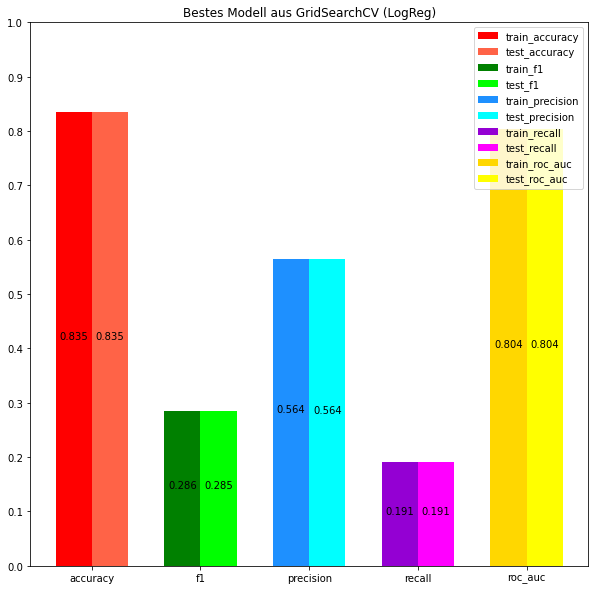

In [68]:
# visuelle Evaluation des Modells
evaluate_model(cv_scores_logreg_grid, 'Bestes Modell aus GridSearchCV (LogReg)')

##### Interpretation - bestes Modell aus der GridSearchCV (logistische Regression)

Bei der Betrachtung der obigen Abbildung, die das erste Modell evaluiert, ist deutlich zu erkennen, dass die Accuracy recht hoch ist. Aufgrund der Verwendung der unbalancierten Daten ist dies jedoch für die Güte des Modells nicht sonderlich aussagekräftig. Hier ist eine Betrachtung von anderen Kenngrößen, wie dem **f1-Score** und vor allem dem **recall-Score** wichtiger. Betrachtet man diese beiden Größen, so schneidet das erste Modell der logistischen Regression mit Werten deutlich unter 50% **extrem schlecht** ab. 

#### 4.1.2.2 Anpassung des 'class_weight'-Parameters

Die schlechten Ergebnisse bei der ersten Betrachtung der logistischen Regression, trotz Hyperparametertuning, sind auf die Unbalanciertheit des Datensatzes zurückzuführen. Um diese auszugleichen, wird die Änderung des 'class_weight'-Parameters der logistischen Regression, der beim Hyperparametertuning noch nicht betrachtet wurde, überprüft. 

##### StratifiedKFold Split

Da für die Durchführung des Modells noch immer die unbalancierten Daten verwendet werden, wird hier weiterhin ein **StratifiedKFold-Split** verwendet. 

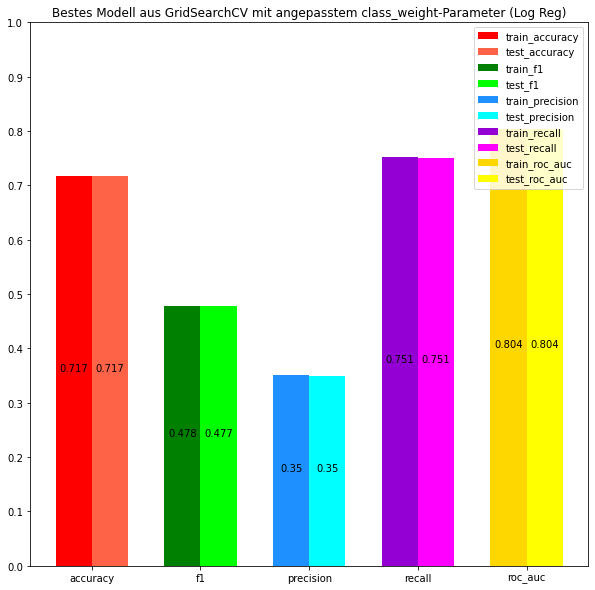

In [69]:
# Bestes Modell aus GridSearchCV mit angepasstem 'class_weight'-Parameter
logreg_balanced = LogisticRegression(C=1.0, solver='saga', max_iter=1000, class_weight='balanced')

# Testen des angepassten Modells mit normalen x- und y-Werten
cv_scores_logreg1 = cross_validate(logreg_balanced, x_values, y_value, cv=skf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation des angepassten Modells
evaluate_model(cv_scores_logreg1, 'Bestes Modell aus GridSearchCV mit angepasstem class_weight-Parameter (Log Reg)')

##### KFold Split 

Um hier einen Vergleich zwischen beiden Splitvarianten durchführen zu können, wird im Folgenden das gleiche Modell noch mit einem normalen kFold-Split getestet. 

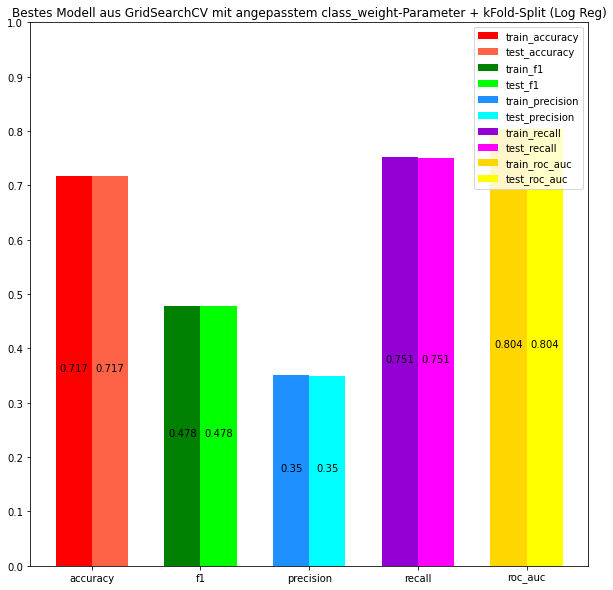

In [70]:
# Testen des angepassten Modells mit normalen x- und y-Werten im kFold-Split
cv_scores_logreg2 = cross_validate(logreg_balanced, x_values, y_value, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation des angepassten Modells
evaluate_model(cv_scores_logreg2, 'Bestes Modell aus GridSearchCV mit angepasstem class_weight-Parameter + kFold-Split (Log Reg)')

##### Interpretation - Anpassung des 'class_weight'-Parameters

Die Anpassung des 'class_weight'-Parameters hat vor allem in Bezug auf den **recall-Wert** zu einer **deutlichen Verbesserung** des Modells geführt. Allerdings ist der **f1-Wert**, der **knapp unter 50%** liegt immer noch nicht ausreichend.

Vergleicht man beide Splitarten, so gibt es keine Unterschiede zwischen den Ergebnissen. Dies könnte aber auch daran liegen, dass in der selbst geschriebenen 'evaluate_model'-Funktion, nur der Durchschnittswert der einzelnen Scores aus den unterschiedlichen Splits zurückgegeben wird. Deshalb wird im Folgenden kurz betrachtet, ob die Recall-Werte in den einzelnen kFold-Splits voneinander abweichen.

##### Betrachtung der recall-Werte in den einzelnen Splits

In [255]:
recall_cv_logreg = cross_val_score(logreg_balanced, x_values, y_value, cv=kf5, scoring='recall')
print(recall_cv_logreg)

SyntaxError: invalid syntax (Temp/ipykernel_7424/1354012037.py, line 1)

### 4.1.3 Ausbalancierung des Datensatzes - Logistische Regression

Zur weiteren Verbesserung des Modells wird nun versucht, ob mit einem balancierten Datensatz, der durch Over-, bzw. Undersampling entsteht, bessere Ergebnisse erzielt werden können. Hier sollen sowohl die oversampleten, als auch die undersampleten und die kombinierten Daten verwendet werden, um die Güte der jeweiligen Modelle vergleichen zu können.

Da der Datensatz ausbalanciert ist, ist es nicht mehr notwendig, den 'class_weight'-Parameter auf 'balanced' zu setzen. Darüber hinaus ist es nicht mehr nötig, den StratifiedKFold-Split anzuwenden, da es statistisch gesehen, bei gleicher Verteilung der Ausprägungen der Klassen, auch in jedem Split die gleiche Verteilung gibt. 

Aus diesem Grund wird im Folgenden wieder das **normale beste Modell** aus der GridSearchCV, in Kombination mit einem **normalen KFold-Split** verwendet.

#### 4.1.3.1 SMOTE-Oversampling - Logistische Regression

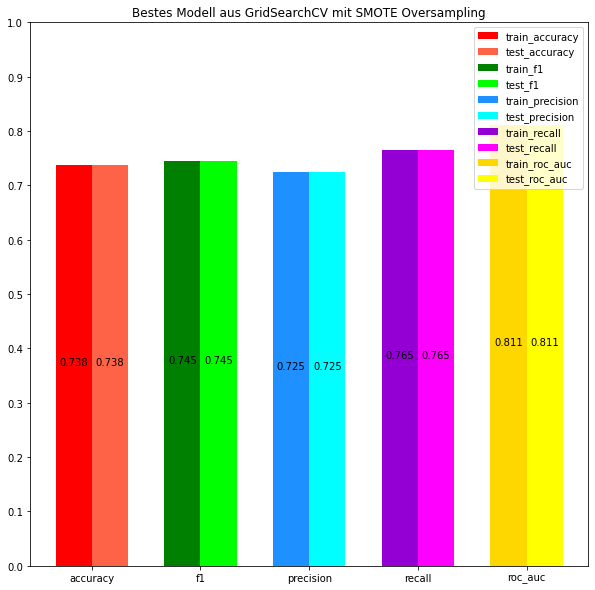

In [74]:
# Testen des besten Modells aus der GridSearchCV mit oversampleten Daten
cv_scores_logreg3 = cross_validate(logreg_grid_best, x_smote, y_smote, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit oversampleten Daten
evaluate_model(cv_scores_logreg3, 'Bestes Modell aus GridSearchCV mit SMOTE Oversampling')

#### 4.1.3.2 RandomUndersampling - Logistische Regression

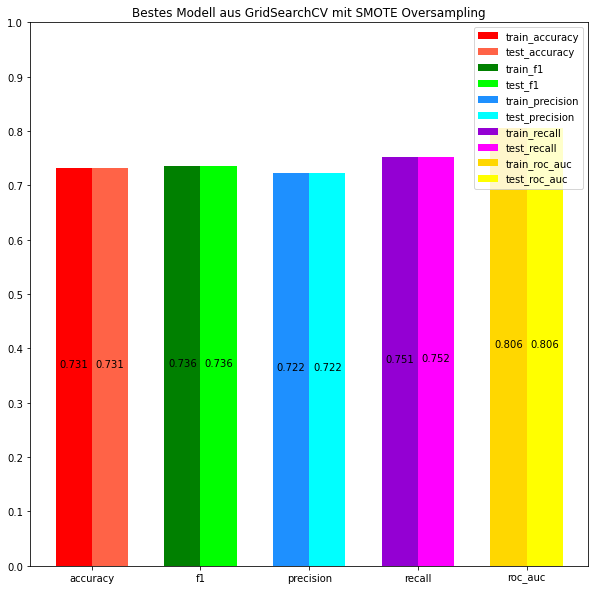

In [75]:
# Testen des besten Modells aus der GridSearchCV mit undersampleten Daten
cv_scores_logreg4 = cross_validate(logreg_grid_best, x_randomunder, y_randomunder, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit undersampleten Daten
evaluate_model(cv_scores_logreg4, 'Bestes Modell aus GridSearchCV mit SMOTE Oversampling')

#### 4.1.3.3 Kombination aus Over-/ und Undersampling 

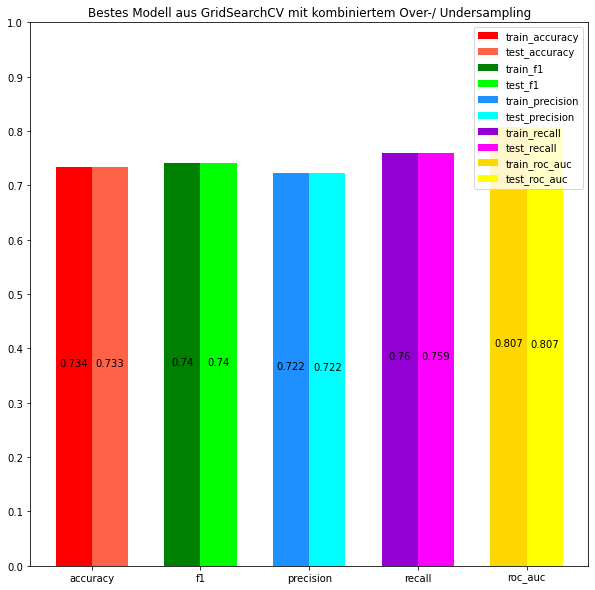

In [76]:
# Testen des besten Modells aus der GridSearchCV mit over-/ undersampleten Daten
cv_scores_logreg5 = cross_validate(logreg_grid_best, x_ou_combi, y_ou_combi, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit over-/ undersampleten Daten
evaluate_model(cv_scores_logreg5, 'Bestes Modell aus GridSearchCV mit kombiniertem Over-/ Undersampling')

##### Interpretation - Ausbalancierung des Datensatzes (logistische Regression)

Es ist deutlich zu erkennen, dass sich durch die **Ausbalancierung der Daten durch Over- bzw. Undersampling** die Ergebnisse der logistischen Regression nochmals **deutlich verbesserten**. Hierbei ist es nahezu **egal**, welche der Balancierungsmethoden verwendet wurde. Bei **fast gleich bleibenden Ergebnisse sinkt hierbei der Rechenaufwand** mit der Größe des Datensatzes drastisch. Während dies bei der logistischen Regression noch keine große Rolle spielt, so kann dies später bei der Support Vector Machine bzw. dem neuronalen Netzwerk sehr wichtig werden.

### 4.1.4 Sensitivitätsanalysen - Logistische Regression

#### 4.1.4.1 Verwendung der normalisierten Daten

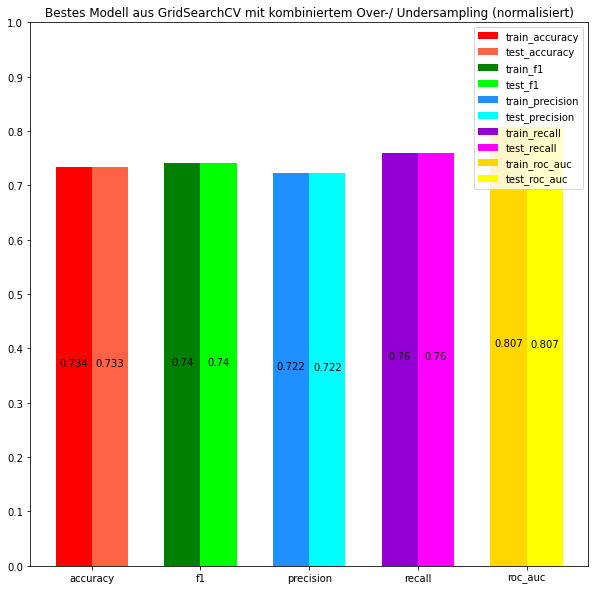

In [77]:
# Testen des besten Modells aus der GridSearchCV mit over-/ undersampleten (normalisierten) Daten
cv_scores_logreg6 = cross_validate(logreg_grid_best, x_ou_combi_mm, y_ou_combi, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit over-/ undersampleten (normalisierten) Daten
evaluate_model(cv_scores_logreg6, 'Bestes Modell aus GridSearchCV mit kombiniertem Over-/ Undersampling (normalisiert)')

##### Interpretation - Verwendung der normalisierten Daten (logistische Regression)

Vergleicht man die Ergebnisse, die bei der logistischen Regression mit den unskalierten Werten erreicht wurden, mit denen, die mit dem MinMaxScaler normalisiert wurden, so erkennt man **keine Veränderung der Güte des Modells**. Dies könnte eventuell daran liegen, dass im vorliegenden Features mehr als die Hälfte der Features sowieso nur die Werte 0 und 1 annehmen können. Dennoch werden im Folgenden, und auch zur anschließenden Evaluation weiterhin die normalisierten Werte für die logistische Regression verwendet.

#### 4.1.4.2 Verwendung eines Cross Validation Splits 10 Folds

Im Folgenden wird versucht, ob eine Anpassung der Anzahl der Folds beim Erstellen der Splits zu einer Veränderung der Ergebnisse führt. Hierdurch soll zudem nochmals überprüft werden, ob die bisherige Anzahl der Splits gut gewählt war.  

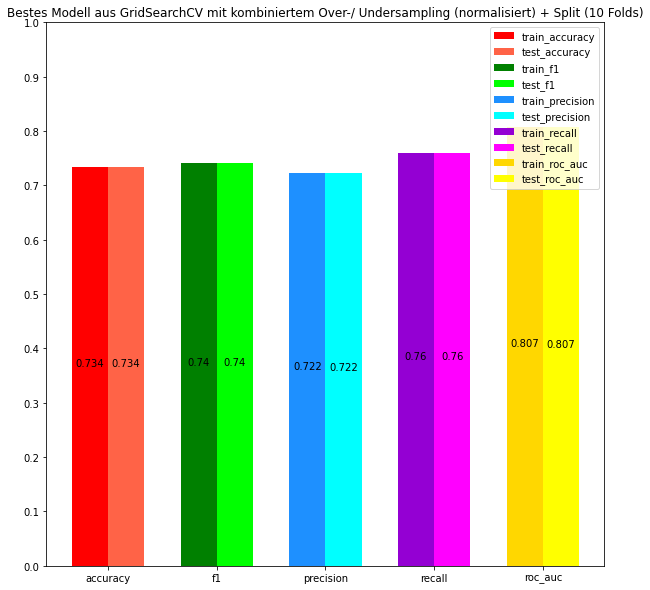

In [116]:
# Testen des besten Modells aus der GridSearchCV mit over-/ undersampleten (normalisierten) Daten
cv_scores_logreg7 = cross_validate(logreg_grid_best, x_ou_combi_mm, y_ou_combi, cv=kf10, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit over-/ undersampleten (normalisierten) Daten
evaluate_model(cv_scores_logreg7, 'Bestes Modell aus GridSearchCV mit kombiniertem Over-/ Undersampling (normalisiert) + Split (10 Folds)')

##### Interpretation - CV Split mit 10 Folds

Durch die Veränderung der Anzahl der Folds im KFold-Split wird erneut **keine Veränderung der Ergebnisse** erzielt. Hieraus lässt sich ableiten, dass die bisher verwendete Anzahl von 5 Folds pro Split ausreichend gewählt war.

#### 4.1.4.3 Verwendung der wichtigsten Features

Nun wird überprüft, ob mit dem **zweiten erstellten Feature Set**, welches nur noch 8 Features umfasst, die Ergebnisse der logistischen Regression nochmals verbessert werden können. Hierzu wird das zweite Feature Set mit einer Kombination aus Over- bzw. Undersampling balanciert und die Werte mit dem MinMaxScaler normalisiert. 

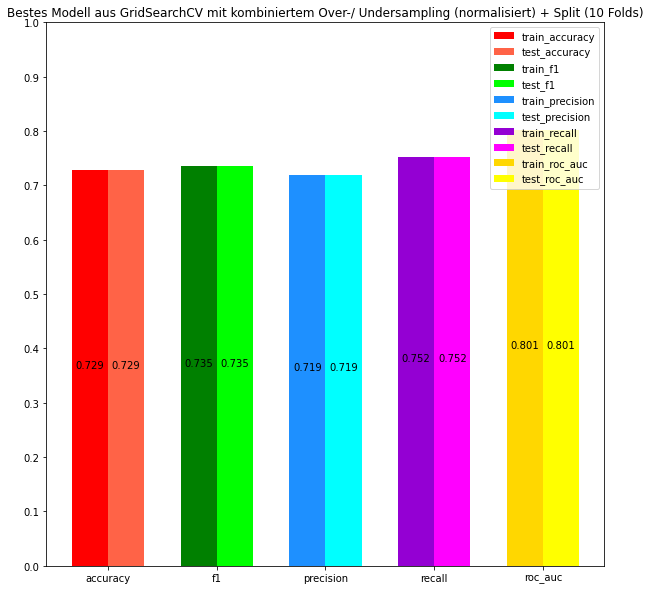

In [198]:
# Testen des besten Modells aus der GridSearchCV mit over-/ undersampleten (normalisierten) Daten
cv_scores_logreg8 = cross_validate(logreg_grid_best, x_sel8_oucomb_mm, y_ou_combi, cv=kf10, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation der Logistichen Regression mit over-/ undersampleten (normalisierten) Daten
evaluate_model(cv_scores_logreg8, 'Bestes Modell aus GridSearchCV mit kombiniertem Over-/ Undersampling (normalisiert) + Split (10 Folds)')

##### Interpretation - Verwendung der wichtigsten Features

Es ist zu erkennen, dass sich die Ergebnisse durch die Verwendung des zweiten Feature Sets nicht mehr verbessern konnten. Es kam sogar zu einer **leichten Verschlechterung der Ergebnisse**. Allerdings muss hier auch angemerkt werden, dass eine Reduzierung der Feature Anzahl von 21 auf 8 den **Rechenaufwand, bei fast gleich bleibenden Ergebnissen, deutlich verringert**. Dies kann vor allem im späteren Verlauf des Modellings, bei SVC oder MLP, eine wichtige Rolle spielen.

##### Quellen

sklearn-Dokumenation (logistische Regression): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression

Hyperparameter für die logistische Regression: *https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492*

## 4.2 Random Forest Classfier

Nach der Betrachtung der logistischen Regression wird im Folgenden der baumbasierte RandomForestClassifier betrachtet. 

### 4.2.1 Erste Betrachtung mit RandomizedSearchCV

Um einen ersten Eindruck bezüglich der richtigen Parameterwahl für den RandomForestClassifier zu bekommen, wird das Modelling hier erneut mit einem **Hyperparametertuning** gestartet. Da der Rechenaufwand und die allgemeine Anzahl der Parameter hier allerdings deutlich höher ist, als bei der logistischen Regression, kann hier statt einer GridSearchCV "nur" eine **RandomizedSearchCV mit 15 Iterationen** durchgeführt werden. Diese findet zwar nicht die beste Parameterkombination, überprüft aber zumindest 15 davon. Die Evaluationskenngröße die zur Ermittlung des besten Modells heran gezogen wird, ist hier erneut der **Recall-Wert**. 

Der erste Paramter, beim Hyperparametertuning betrachtet werden soll, ist **'n_estimators'**. Dieser gibt die Anzahl an Bäumen in einem Wald an. Darüber hinaus soll mit **'max_depth'** die maximale Tiefe eines Baumes begutachtet werden. Weitere interessante Parameter, die durch die RandomizedSearch betrachtet werden sollen, sind 'min_samples_split', 'min_samples_leaf', 'criterion' und 'boostrap'.

Zum Hyperparametertuning werden vorerst erneut die **unbalancierten Daten** verwendet.

In [163]:
# Dictionary mit wichtigen Parametern für die RandomizedSearchCV
rfc_parameters = [{'n_estimators': [10, 100, 1000], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20],
                  'min_samples_split': [2,4,6], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}]

# Initialisierung des Modells
rfc_model_rscv = RandomForestClassifier()

# Initialisierung der RandomizedSearchCV
rfc_rscv = RandomizedSearchCV(estimator=rfc_model_rscv, n_iter=15, scoring=['f1','accuracy', 'recall', 'roc_auc'], refit='recall', cv=skf5, param_distributions=rfc_parameters, verbose=2)

# Durchführung der RandomizedSearchCV
rfc_rscv.fit(x_values, y_value)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END bootstrap=False, criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=False, criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=True, criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=1000; total time= 1.

[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   1.6s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   1.6s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   1.6s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   1.6s
[CV] END bootstrap=True, criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   1.6s
[CV] END bootstrap=True, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 1.5min
[CV] END bootstrap=True, criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time= 1.6min
[CV] END bootstrap=True, criterion=entropy, max_depth=10

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=15,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['gini', 'entropy'],
                                         'max_depth': [None, 5, 10, 20],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 4, 6],
                                         'n_estimators': [10, 100, 1000]}],
                   refit='recall',
                   scoring=['f1', 'accuracy', 'recall', 'roc_auc'], verbose=2)

In [169]:
print(f'Das beste Ergebnis der Random Forest Classification wurde mit den Parameter {rfc_rscv.best_params_} erzielt mit einem Recall-Score von\n{rfc_rscv.best_score_}')

Das beste Ergebnis der Random Forest Classification wurde mit den Parameter {'n_estimators': 10, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': True} erzielt mit einem Recall-Score von
0.2204936394173258


### 4.2.2 Nähere Betrachtung des besten Modells aus der RandomizedSearchCV (RandomForestClassifier)

#### 4.2.2.1 Evaluation des besten Modells aus der RandomizedSearchCV (RandomForestClassifier)

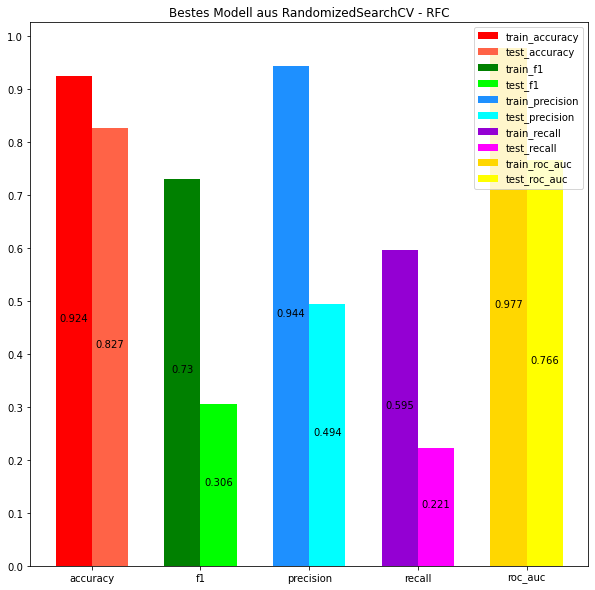

In [176]:
# Initialisierung des besten Modells aus der RandomizedSearchCV
rfc_rfscv_best = rfc_rscv.best_estimator_

# Test des besten Modells aus der RandomizedSearchCV mit dem RandomForestClassifier 
cv_scores_rfc1 = cross_validate(rfc_rfscv_best, x_values, y_value, cv=skf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc1, 'Bestes Modell aus RandomizedSearchCV - RFC')

##### Interpretation der Ergebnisse - RFC (bestes Modell aus der RandomizedSearchCV)

Bei allen Evaluationskenngrößen ist zu erkennen, dass das Modell im Training deutlich bessere Ergebnisse erzielt, als beim tatsächlichen Test. Dies deutet darauf hin, dass das Modell etwas zu komplex gewählt ist und deshalb **Overfitting** entsteht.

#### 4.2.2.2 Anpassung des Modells zur Reduzierung des Overfittings

Es gibt mehrere Parameter, die zur Reduzierung des Overfittings beim Random Forest Classifier angepasst werden können. Hierzu zählt zum Beispiel der **'max_depth'-Parameter**, der durch die RandomizedSearch mit Recall als Evaluationskenngröße sogar auf None gesetzt wurde. Darüber hinaus kann der **'min_samples_split'-Parameter** näher betrachtet werden, der durch das Hyperparametertuning ebenfalls relativ hoch eingestuft wurde.

##### Erste Anpassung des 'max_depth'-Parameters

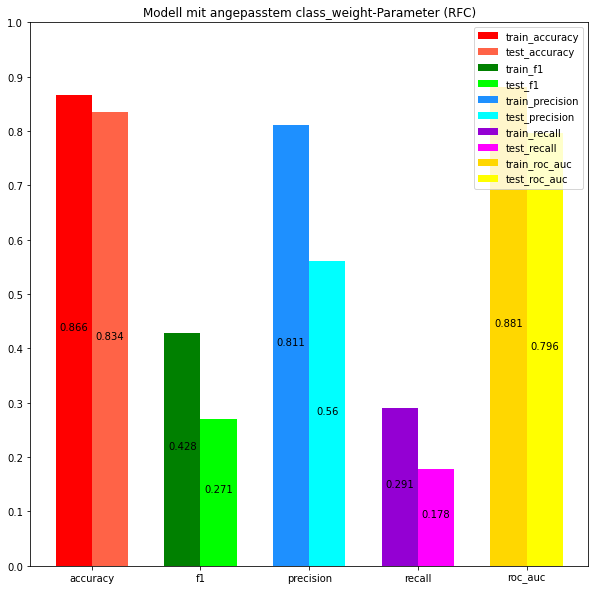

In [177]:
# Bestes Modell aus RandomizedSearchCV mit 'max_depth'=15
rfc_md_red = RandomForestClassifier(n_estimators=10, min_samples_split=6, criterion='gini', bootstrap=True, max_depth=15)

# Test des Modells mit angepasstem 'max_depth'-Parameter
cv_scores_rfc2 = cross_validate(rfc_md_red, x_values, y_value, cv=skf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc2, 'Modell mit angepasstem class_weight-Parameter (RFC)')

##### Interpretation - Erste Anpassung des 'max_depth'-Parameters

Es ist zu erkennen, dass das Overfitting der Ergebnisse bereits **leicht zurück** gegangen ist. Allerdings sind dadurch die Ergebnisse allgemein nochmals etwas schlechter geworden. Dies wiederum ist auf den **unbalancierten Datensatz** zurück zu führen. Im Folgenden wird nochmals versucht, dass **Overfitting weiter zu reduzieren**, bevor dann durch Anpassung geeigneter Parameter, bzw. Verwendung over- bzw. undersampleter Daten die Ergebnisse weiter verbessert werden.

##### Erneute Anpassung des 'max_depth'-Parameters

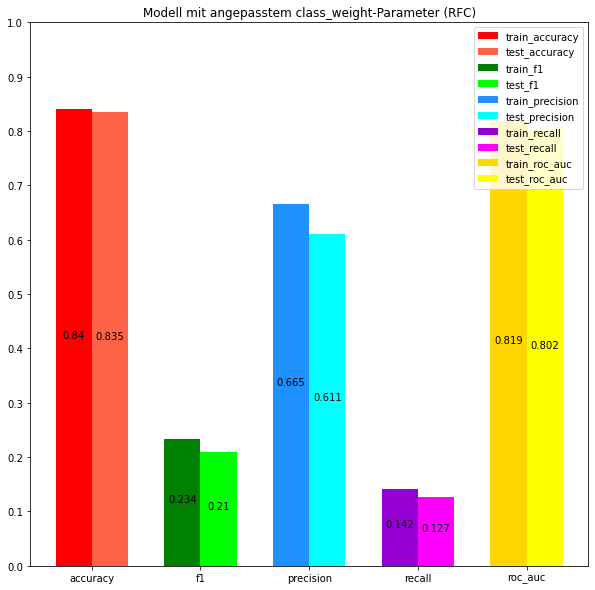

In [179]:
# Bestes Modell aus RandomizedSearchCV mit 'max_depth'=10
rfc_md_red2 = RandomForestClassifier(n_estimators=10, min_samples_split=6, criterion='gini', bootstrap=True, max_depth=10)

# Test des Modells mit angepasstem 'max_depth'-Parameter
cv_scores_rfc3 = cross_validate(rfc_md_red2, x_values, y_value, cv=skf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc3, 'Modell mit angepasstem class_weight-Parameter (RFC)')

##### Interpretation - Erneute Anpassung des 'max_depth'-Parameters

Durch die erneute Anpassung des 'max_depth'-Parameters hat sich das **Overfitting** der Ergebnisse für die Random Forest Classification nochmals **deutlich verbessert**, sodass nur noch ein sehr geringes Overfitting vorliegt. Durch eine weitere Anpassung des 'min_samples'-Split-Parameters wird versucht, ob hier nochmals eine geringe Verbesserung erzielt werden kann. 

#### 4.2.2.3 Anpassung des 'min_samples_split'-Parameters zur weiteren Reduzierung des Overfittings

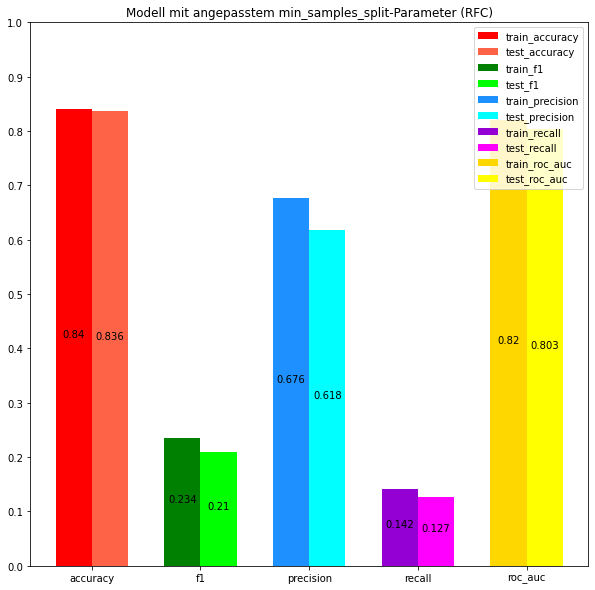

In [185]:
# Bestes Modell aus RandomizedSearchCV mit 'max_depth'=10 und 'min_samples_split'=2
rfc_mss_red = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10)

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc4 = cross_validate(rfc_mss_red, x_values, y_value, cv=skf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc4, 'Modell mit angepasstem min_samples_split-Parameter (RFC)')

##### Interpretation - Anpassung des 'min_samples_split'-Parameters

Durch die Anpassung des 'min_samples_split'-Parameters hat sich das Overfitting nicht großartig verändert. Eine kleine Verbesserung der Ergebnisse ist allerdings zu erkennen, weswegen im Folgenden das aktualisierte Modell zum Einsatz kommt. 

##### Quellen

Reduzierung von Overfitting beim RandomForestClassifier: *https://crunchingthedata.com/random-forest-overfitting/*

### 4.2.3 Ausgleich der Unbalanciertheit im Datensatz - RFC

#### 4.2.3.1 Anpassung des class_weight-Parameters

In der obigen Visualisierung der Ergebnisse ist zu erkennen, dass der **Recall-Wert**, der für die Klassifikation von Krankheiten eine **bedeutende Rolle** spielt, durch die Reduzierung des Overfittings nochmals **schlechter** wurden, als zu Beginn. Der Grund hierfür könnte in der Unbalanciertheit des verwendeten Datensatzes liegen. Deshalb wird im Folgenden versucht, durch eine **Anpassung des 'class_weight'-Parameters** eine weitere Verbesserung der Ergebnisse zu erzielen. Im Anschluss daran wird **Over- bzw. Undersampling** auf den Datensatz angewendet, um hier eine weitere Verbesserung der Ergebnisse zu erzielen.

Wegen des Ausgleichs der Unbalancierheit im Datensatz durch verschiedene Methoden, wird im Folgenden nicht mehr der StratifiedKFold-Split, sondern der normale **KFold-Split** verwendet.

##### class_weight = 'balanced'

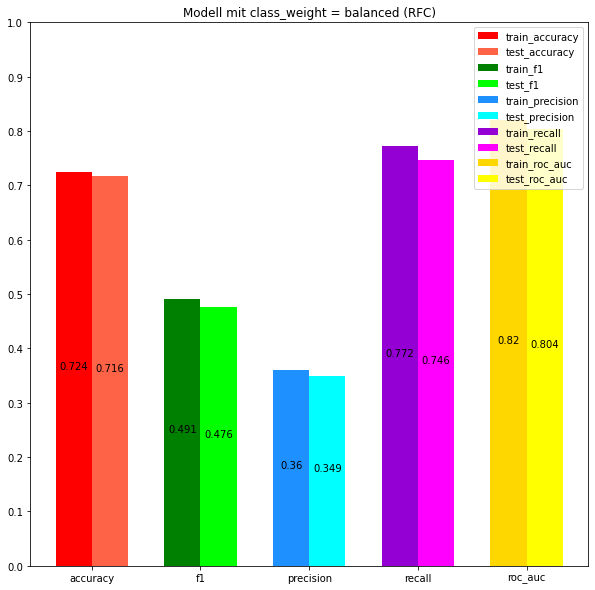

In [186]:
# Initialisierung eines Modells mit angepasstem 'class_weight'-Parameter
rfc_balanced1 = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10, class_weight='balanced')

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc5 = cross_validate(rfc_balanced1, x_values, y_value, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc5, 'Modell mit class_weight = balanced (RFC)')

##### class_weight = 'balanced_subsample'

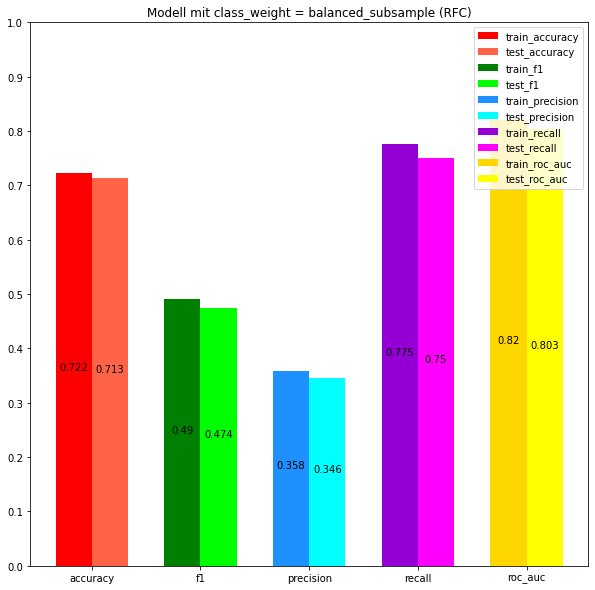

In [187]:
# Initialisierung eines Modells mit angepasstem 'class_weight'-Parameter
rfc_balanced2 = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10, class_weight='balanced_subsample')

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc6 = cross_validate(rfc_balanced2, x_values, y_value, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc6, 'Modell mit class_weight = balanced_subsample (RFC)')

##### Interpretation - Anpassung des 'class_weight'-Parameters

Ähnlich wie bei der logistischen Regression, ist zu sehen, dass vor allem der **Recall-Wert** durch die Anpassung des 'class_weight'-Parameters schon deutlich **ansteigt**. Allerdings liegt zum Beispiel der **f1-Wert immer noch unter 50%**. Deshalb wird im Folgenden versucht, den Datensatz zu balancieren und die Ergebnisse durch **Over- bzw. Undersampling** noch weiter zu verbessern.

#### 4.2.3.2 Verwendung des SMOTE-Oversamplings (RFC)

Zuerst wird überprüft, ob eine Verbesserung der oversampleten Daten das Modell verbessern kann. Hierzu kann der **'class_weight'**-Parameter wieder auf den Standardwert (**None**) gesetzt werden. Darüber hinaus bleibt der Split, wie bereits nach Anpassung des 'class_weight'-Parameters, ein **kFold-Split**. 

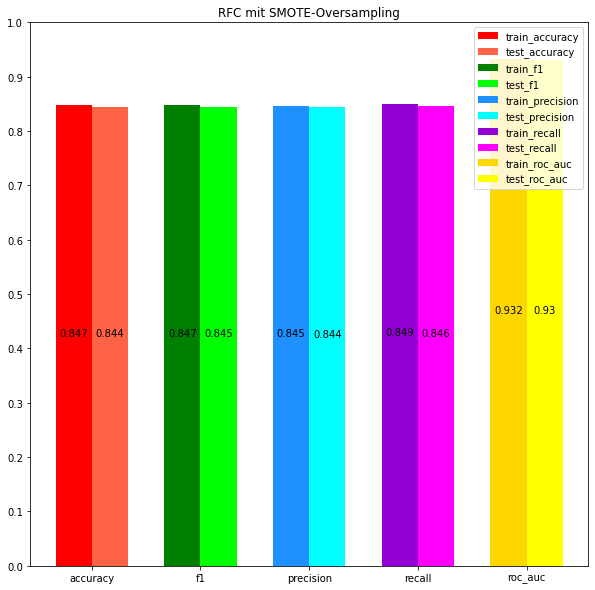

In [190]:
# Initialisierung eines Modells mit angepasstem 'class_weight'-Parameter
rfc_overunder = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10)

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc7 = cross_validate(rfc_overunder, x_smote, y_smote, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc7, 'RFC mit SMOTE-Oversampling')

#### 4.2.3.3 Verwendung der undersampleten Daten

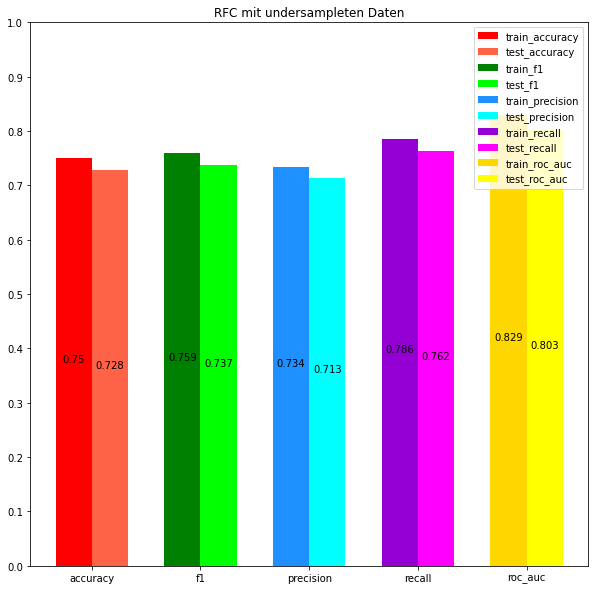

In [256]:
# Initialisierung eines Modells mit angepasstem 'class_weight'-Parameter
rfc_overunder = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10)

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc8 = cross_validate(rfc_overunder, x_randomunder, y_randomunder, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc8, 'RFC mit undersampleten Daten')

#### 4.2.3.4 Verwendung der kombinierten over-/ und undersampleten Daten

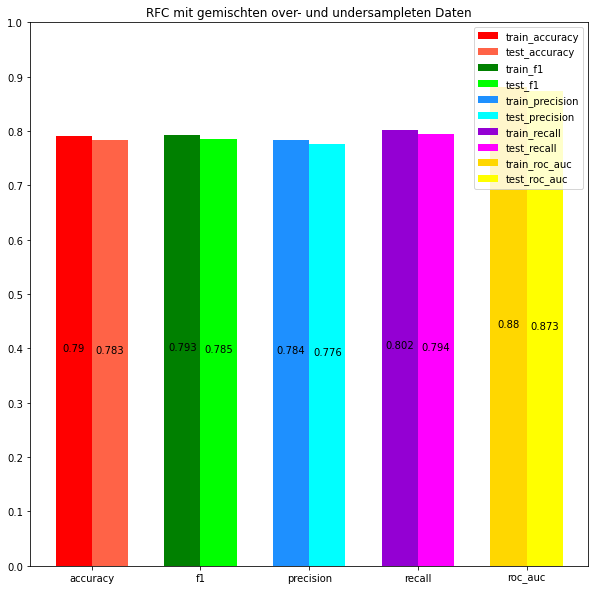

In [78]:
# Initialisierung eines Modells mit angepasstem 'class_weight'-Parameter
rfc_overunder = RandomForestClassifier(n_estimators=10, min_samples_split=2, criterion='gini', bootstrap=True, max_depth=10)

# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc9 = cross_validate(rfc_overunder, x_ou_combi, y_ou_combi, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc9, 'RFC mit gemischten over- und undersampleten Daten')

##### Interpretation - Ausgleich der Unbalanciertheit im Datensatz 

Ähnlich wie bei der logistischen Regression, **verbessert** auch beim Random Forest Classifier der Ausgleich der Ergebnisse durch Over-, bzw. Undersampling die Ergebnisse **signifikant**. Allerdings gibt es hier im Gegensatz zum anderen Modell einen relativ **deutlichen Unterschied zwischen den einzelnen Balancierungsarten**. So kann durch reines **SMOTE-Oversampling** hier sogar ein **Recall-Wert von knapp 85%** erzielt werden. Durch den relativ überschaubaren Rechenaufwand beim RandomForestClassifier lohnt sich diese Verbesserung von fast 10% im Vergleich zum normalen Undersampling auf jeden Fall.

### 4.2.4 Sensitivitätsanalysen - Random Forest Classifier

#### 4.2.4.1 Verwendung der normalisierten Daten

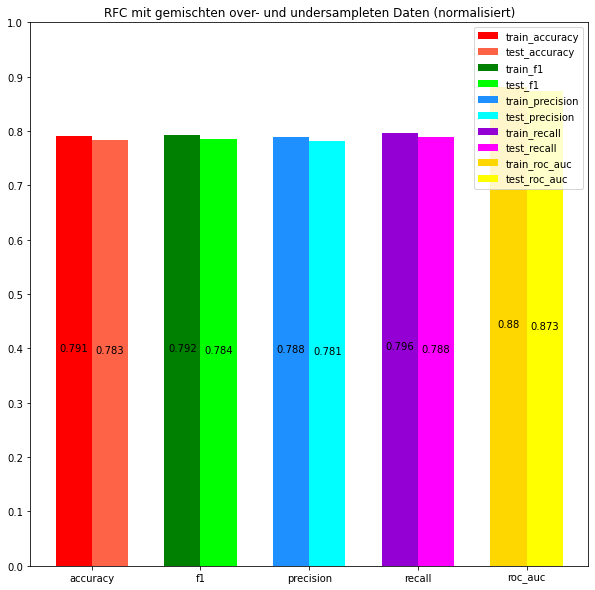

In [79]:
# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc10 = cross_validate(rfc_overunder, x_ou_combi_mm, y_ou_combi, cv=kf5, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc10, 'RFC mit gemischten over- und undersampleten Daten (normalisiert)')

##### Interpretation - Verwendung der normalisierten Daten (RFC)

Während der **Precision-Wert des Modells leicht ansteigt**, **sinkt** der wichtigere **Recall-Wert** des Modells leicht ab. Insgesamt ist es zwar nicht als Verschlechterung zu betrachten, es ist aber auch keine Verbesserung des Modells durch vorheriges Modelling zu erkennen.

#### 4.2.4.2 Cross Validation Split mit 10 Folds

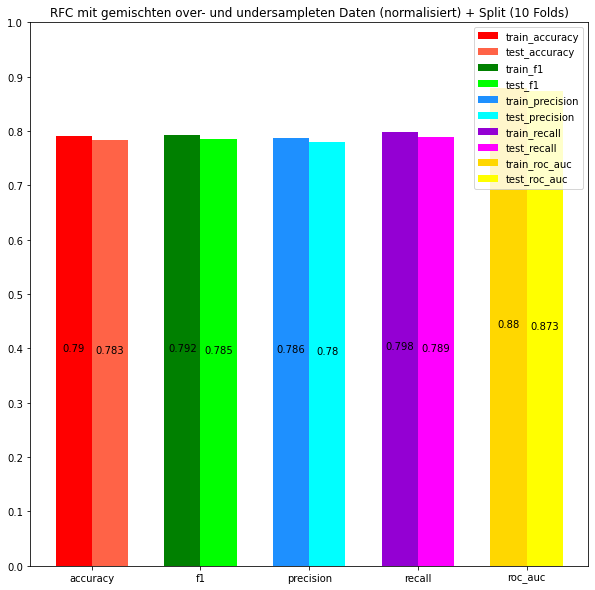

In [117]:
# Test des Modells mit angepasstem 'min_samples_split'-Parameter
cv_scores_rfc11 = cross_validate(rfc_overunder, x_ou_combi_mm, y_ou_combi, cv=kf10, scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'], return_train_score=True)

# visuelle Darstellung der Ergebnisse des besten Modells aus der RandomizedSearchCV (RFC)
evaluate_model(cv_scores_rfc11, 'RFC mit gemischten over- und undersampleten Daten (normalisiert) + Split (10 Folds)')

##### Interpretation - Cross Validation Splits mit 10 Folds

Auch in diesem Fall bewirkt eine Erhöhung der Anzahl der Folds im Split keine Veränderung der Ergebnisse. Es lässt erneut darauf schließen, dass der Split mit 5 Folds beim vorliegenden Datensatz ausreichend gewählt ist.

##### Quellen

sklearn-Dokumentation (Random Forest Classifier): *https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html*

Feature Scaling bei RFC: *https://towardsdatascience.com/feature-scaling-effectively-choose-input-variables-based-on-distributions-3032207c921f*

## 4.3 Support Vektor Classifier

### 4.3.1 Erste Betrachtung des Modells in einer RandomSearchCV

Ein bedeutender Nachteil des Support Vector Classifiers ist, dass es teilweise zu extrem **langen Rechenzeiten** kommen kann. Speziell beim vorliegenden Datensatz, der über **200.000 Feature Vektoren** umfasst, ist dies zu beachten. Aus diesem Grund wird das Modell nur mit den **wichtigsten Features** trainiert und diese nochmals **undersamplet**, um den Rechenaufwand möglich minimal zu halten. Zwar gehen hierbei durch das Undersampling einige Informationen verloren, allerdings ist es anders, zumindest für die RandomizedSearchCV, die einige Parameterkombinationen durchtestet, nicht möglich. 

In [29]:
# Erstellung eines Dictionaries mit interessanten Parametern
svc_parameters = {'kernel': ['linear', 'poly', 'rbf'],
                  'C': [5, 1.0, 0.1, 0.001],
                  'class_weight': [None, 'balanced']                 
                  }

# Initialisierung des Modells
svc_model_rscv = SVC()

# Initialisierung der RandomizedSearch mit 10 Wiederholungen, und einem normalen kfold-Split
svc_rscv = RandomizedSearchCV(svc_model_rscv, param_distributions=svc_parameters, cv=kf5, n_iter=10, verbose=4, scoring=['recall', 'accuracy'], refit='recall', return_train_score=True)

# Durchführung der RandomizedSearch mit undersampletem Datensatz und nur wichtigsten Features, um Rechenzeit zu sparen
svc_rscv.fit(x_important_under, y_important_under)

# Abspeichern der Ergebnisse
svc_rscv_best_params = svc_rscv.best_params_
svc_rscv_best_model = svc_rscv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=0.1, class_weight=None, kernel=rbf; accuracy: (train=0.733, test=0.733) recall: (train=0.787, test=0.785) total time= 3.2min
[CV 2/5] END C=0.1, class_weight=None, kernel=rbf; accuracy: (train=0.736, test=0.727) recall: (train=0.786, test=0.784) total time= 3.1min
[CV 3/5] END C=0.1, class_weight=None, kernel=rbf; accuracy: (train=0.734, test=0.732) recall: (train=0.785, test=0.781) total time= 3.2min
[CV 4/5] END C=0.1, class_weight=None, kernel=rbf; accuracy: (train=0.735, test=0.732) recall: (train=0.787, test=0.780) total time= 3.2min
[CV 5/5] END C=0.1, class_weight=None, kernel=rbf; accuracy: (train=0.733, test=0.736) recall: (train=0.786, test=0.792) total time= 3.3min
[CV 1/5] END C=1.0, class_weight=balanced, kernel=poly; accuracy: (train=0.723, test=0.723) recall: (train=0.764, test=0.763) total time= 3.4min
[CV 2/5] END C=1.0, class_weight=balanced, kernel=poly; accuracy: (train=0.726, test=0.719) re

In [34]:
print(f'Bestes SVC-Modell mit den Parametern: {svc_rscv_best_params}')

Bestes SVC-Modell mit den Parametern: {'kernel': 'rbf', 'class_weight': None, 'C': 0.1}


### 4.3.2 Nähere Betrachtung des besten Modells aus der RandomizedSearchCV

#### 4.3.2.1 Evaluation des besten SVC-Modells aus der RandomizedSearchCV

In [30]:
svc_rscv_best_model = SVC(kernel='rbf', class_weight=None, C=0.1)

In [74]:
cv_scores_svc1 = cross_validate(svc_rscv_best_model, x_important_under, y_important_under, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

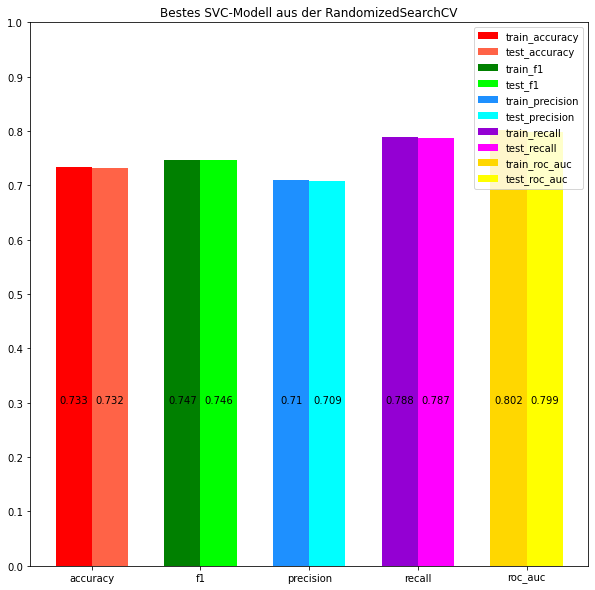

In [120]:
evaluate_model(cv_scores_svc1, 'Bestes SVC-Modell aus der RandomizedSearchCV')

##### Interpretation - RandomizedSearchCV

Der beste Recall-Wert mit dem SVC wurde nach 10 verschiedenen Parameterkombinationen mit den Parametern **'kernel': 'rbf', 'class_weight': None, 'C': 0.1** erzielt. Es ist zu erkennen, dass, nach mehrmaliger Betrachtung der zur Verfügung stehenden Kernels, 'rbf' hier die besten Ergebnisse erzielen konnte. Ein Blick in die Dokumentation zeigt einem, dass bei der Wahl der Kernels auf 'rbf' noch der **gamma-Parameter** näher zu betrachten ist. Darüber hinaus sieht man bei Betrachtung der RandomizedSearchCV, dass der 'rbf'-Kernel nur in Kombination mit C-Werten <= 1.0 getestet wurde. Hier wird im Folgenden auch nochmal probiert, mit **höheren Werten für C** bessere Ergebnisse zu erzielen. Da die SVC nur mit undersampleten Daten, also mit einem balancierten Datensatz getestet wurde, ist eine zusätzliche **Änderung des 'class_weight'-Parameters** hier **nicht nötig**.

#### 4.3.2.2 Zusätzliche Betrachtung des gamma-Parameters

Für den gamma-Parameter stehen die Optionen 'scale', 'auto' und ein float zur Verfügung, wobei der default-Wert bei 'scale' liegt. Im Folgenden wird nochmals der **'gamma'-Parameter** auf **'auto'** gesetzt, um eine mögliche Veränderung der Ergebnisse zu betrachten.

In [ ]:
svc_model_gamma = SVC(C=1.0, kernel='rbf', class_weight=None, gamma='auto')

cv_scores_svc2 = cross_validate(svc_model_gamma, x_important_under, y_important_under, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

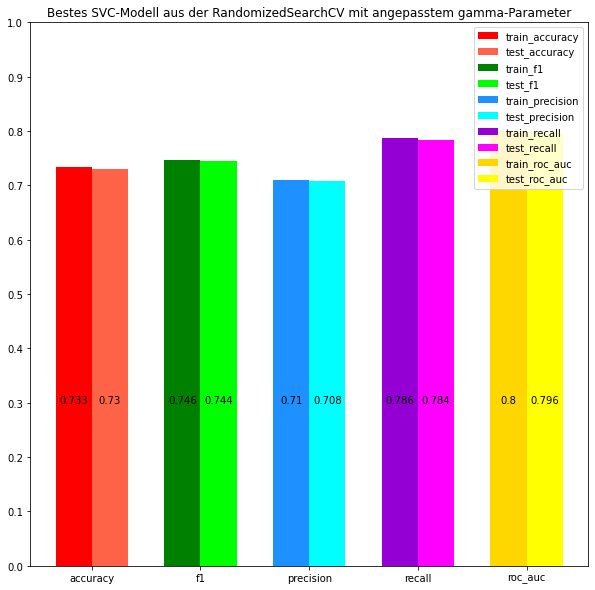

In [121]:
evaluate_model(cv_scores_svc2, 'Bestes SVC-Modell aus der RandomizedSearchCV mit angepasstem gamma-Parameter')

##### Interpretation - SVC mit angepasstem gamma-Parameter

Es ist zu sehen, dass die Änderung des gamma-Parameters **keine Verbesserung** (geringfügige Verschlechterung) der scores zur Folge hatte.

#### 4.3.2.3 Anpassung des C-Parameters in Kombination mit 'rbf'-Kernel

In [77]:
svc_model_c = SVC(kernel='rbf', class_weight=None)

svc_grid_c = GridSearchCV(svc_model_c, {'C': [10, 5, 1.0, 0.1]}, verbose=3, scoring=['f1','accuracy', 'precision', 'recall', 'roc_auc'], refit='recall', cv=kf5, return_train_score=True)

svc_grid_c.fit(x_important_under, y_important_under)

svc_grid_c_best = svc_grid_c.best_estimator_

print(svc_grid_c_best)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END C=10; accuracy: (train=0.741, test=0.730) f1: (train=0.753, test=0.743) precision: (train=0.719, test=0.711) recall: (train=0.790, test=0.778) roc_auc: (train=0.808, test=0.788) total time= 7.6min
[CV 2/5] END C=10; accuracy: (train=0.743, test=0.725) f1: (train=0.753, test=0.738) precision: (train=0.723, test=0.705) recall: (train=0.786, test=0.774) roc_auc: (train=0.809, test=0.785) total time= 7.3min
[CV 3/5] END C=10; accuracy: (train=0.740, test=0.736) f1: (train=0.752, test=0.745) precision: (train=0.720, test=0.718) recall: (train=0.786, test=0.775) roc_auc: (train=0.809, test=0.793) total time= 7.1min
[CV 4/5] END C=10; accuracy: (train=0.742, test=0.726) f1: (train=0.753, test=0.741) precision: (train=0.720, test=0.712) recall: (train=0.788, test=0.772) roc_auc: (train=0.810, test=0.784) total time= 7.3min
[CV 5/5] END C=10; accuracy: (train=0.741, test=0.730) f1: (train=0.753, test=0.740) precision: (tra

In [ ]:
cv_scores_svc3 = cross_validate(svc_grid_c_best, x_important_under, y_important_under, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

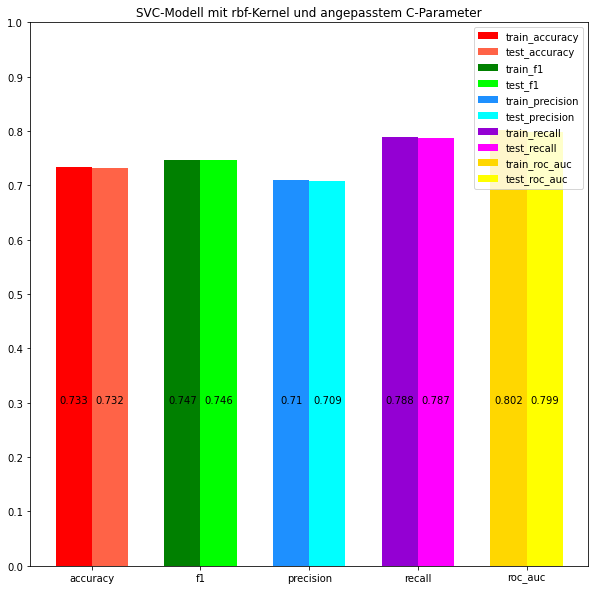

In [122]:
evaluate_model(cv_scores_svc3, 'SVC-Modell mit rbf-Kernel und angepasstem C-Parameter')

##### Interpretation - SVC mit 'rbf'-Kernel und angepasstem C-Parameter

Auch die Anpassung des C-Parameters ergab **keine Verbesserung** der Ergebnisse mehr. Im Folgenden wird das bisher beste Modell noch mit den **kombinierten over-/ und undersampleten Daten** getestet, um eine **bessere Vergleichbarkeit** mit den anderen Modellen zu gewährleisten.

### 4.3.3 Verwendung der gemischten over-/ und undersampleten Daten

In [33]:
cv_scores_svc4 = cross_validate(svc_rscv_best_model, x_ou_combi, y_ou_combi, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

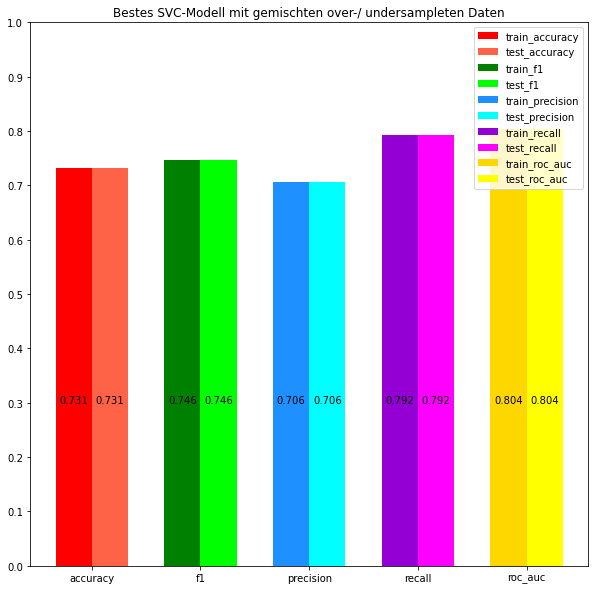

In [123]:
evaluate_model(cv_scores_svc4, 'Bestes SVC-Modell mit gemischten over-/ undersampleten Daten')

##### Interpretation - Verwendung der gemischten over-/ und undersampleten Daten

Auch die Verwendung der over- und undersampleten Daten gab bei der SVC, trotz erheblich höherem Rechenaufwand, **keine signifikante Verbesserung** der Ergebnisse.

### 4.3.4 Sensitivitätsanalysen - SVC

#### 4.3.4.1 Verwendung der normalisierten Daten (MinMaxScaler)

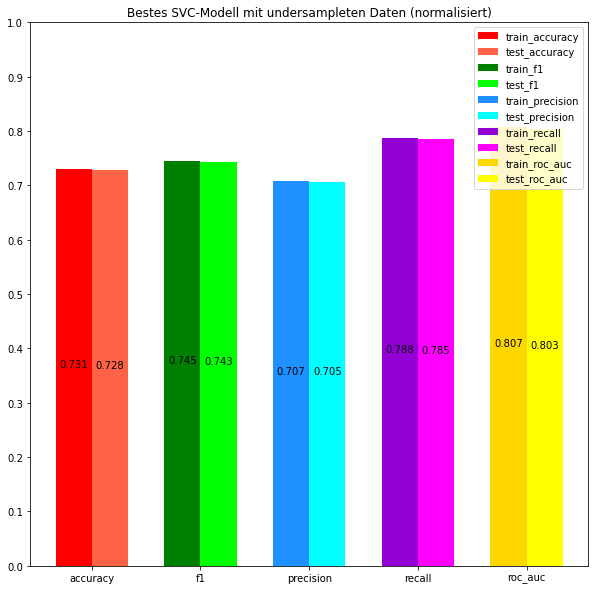

In [81]:
cv_scores_svc5 = cross_validate(svc_rscv_best_model, x_randomunder_mm, y_randomunder, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)
evaluate_model(cv_scores_svc5, 'Bestes SVC-Modell mit undersampleten Daten (normalisiert)')

##### 4.3.4.1 Verwendung eines neuen Feature Sets mit MinMaxScaler

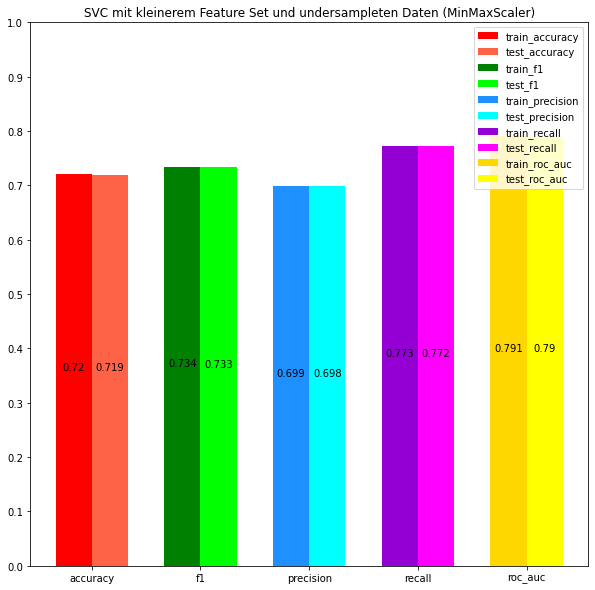

In [168]:
cv_scores_svc6 = cross_validate(svc_rscv_best_model, x_sel8_under_mm, y_randomunder, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)
evaluate_model(cv_scores_svc6, 'SVC mit kleinerem Feature Set und undersampleten Daten (MinMaxScaler)')

##### Quellen

sklearn-Dokumentation SVC *https://scikit--learn-org.translate.goog/stable/modules/generated/sklearn.svm.SVC.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=op,sc*

Hyperparameter für SVC: *https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/*

# 5. Evaluation - Machine Learning

##### Funktionen zur Erstellung einer Konfusionsmatrix über mehrere Cross-Validation-Splits

In [242]:
def cross_val_predict(model, kfold, x_values, y_value):
    
    actual_classes = np.array([])
    predicted_classes = np.array([])

    for train_index, test_index in kfold.split(x_values, y_value):

        X_train, y_train = x_values.iloc[train_index], y_value.iloc[train_index]
        X_test, y_test = x_values.iloc[test_index], y_value.iloc[test_index]
        
        actual_classes = np.append(actual_classes, y_test)

        model.fit(X_train, y_train)
        
        predicted_classes = np.append(predicted_classes, model.predict(X_test))

    return actual_classes, predicted_classes

def plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels):

    matrix = confusion_matrix(actual_classes, predicted_classes)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

##### Quellen zum Code

Ausgabe einer Konfusionmatrix über mehrere Cross Validation Splits (1): *https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874*

Ausgabe einer Konfusionmatrix über mehrere Cross Validation Splits (2): *https://medium.com/analytics-vidhya/generation-of-a-concatenated-confusion-matrix-in-cross-validation-912485c4a972*

##### Funktion zum Plotten einer ROC-Kurve über mehrere CV-Splits 

In [88]:
def plot_roc_cv(estimator, cv, x_values, y_value):    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(15,10))
    for i, (train, test) in enumerate(cv.split(x_values, y_value)):
        estimator.fit(x_values.iloc[train], y_value.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            estimator,
            x_values.iloc[test],
            y_value.iloc[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="ROC-Kurve (Logistische Regression) über mehrere Cross Validation Splits",
    )

    ax.legend(loc="lower right")
    plt.show()

##### Quellen zum Code

Ausgabe einer ROC-Kurve über mehrere Cross Validation Splits: *https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#:~:text=Example%20of%20Receiver%20Operating%20Characteristic,rate%20on%20the%20X%20axis.*

## 5.1 Evaluation - Logistische Regression

### 5.1.1 Konfusionsmatrix über alle Cross Validation Splits

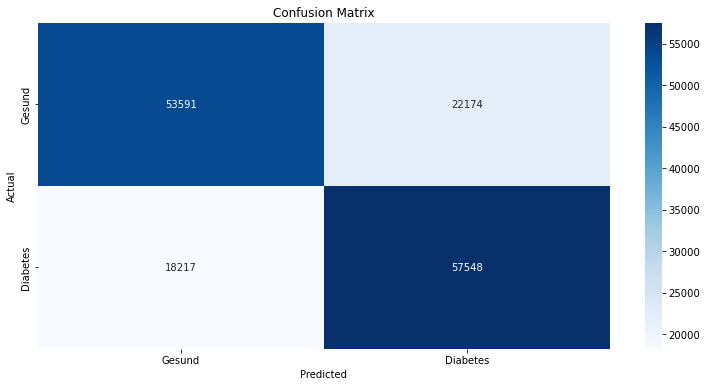

In [243]:
actual_classes_logreg, predicted_classes_logreg = cross_val_predict(logreg_grid_best, kf5, x_ou_combi_mm, y_ou_combi)
plot_confusion_matrix(actual_classes_logreg, predicted_classes_logreg, ['Gesund', 'Diabetes'])

### 5.1.2 Klassifikationsmessgrößen (logistische Regression)

#### 5.1.2.1 Accuracy (logistische Regression)

In [262]:
logreg_acc = accuracy_score(actual_classes_logreg, predicted_classes_logreg)
logreg_acc

0.7334455223388108

#### 5.1.2.2 Precision/ Positive Predictive Value (logistische Regression) 

In [263]:
logreg_prec = precision_score(actual_classes_logreg, predicted_classes_logreg)
logreg_prec

0.7218584581420436

#### 5.1.2.3 Recall Score/ Sensitivität/ True Positive Rate (logistische Regression)

In [264]:
logreg_recall = recall_score(actual_classes_logreg, predicted_classes_logreg)
logreg_recall

0.7595591632020062

#### 5.1.2.4 f1-Score (logistische Regression)

In [265]:
logreg_f1 = f1_score(actual_classes_logreg, predicted_classes_logreg)
logreg_f1

0.7402290866760566

In [266]:
# Liste mit allen Scores aus der logistischen Regression
logreg_scores = [logreg_acc, logreg_prec, logreg_recall, logreg_f1]

### 5.1.3 ROC-Kurve und AUC für mehrere Cross-Validation-Splits (logistische Regression)

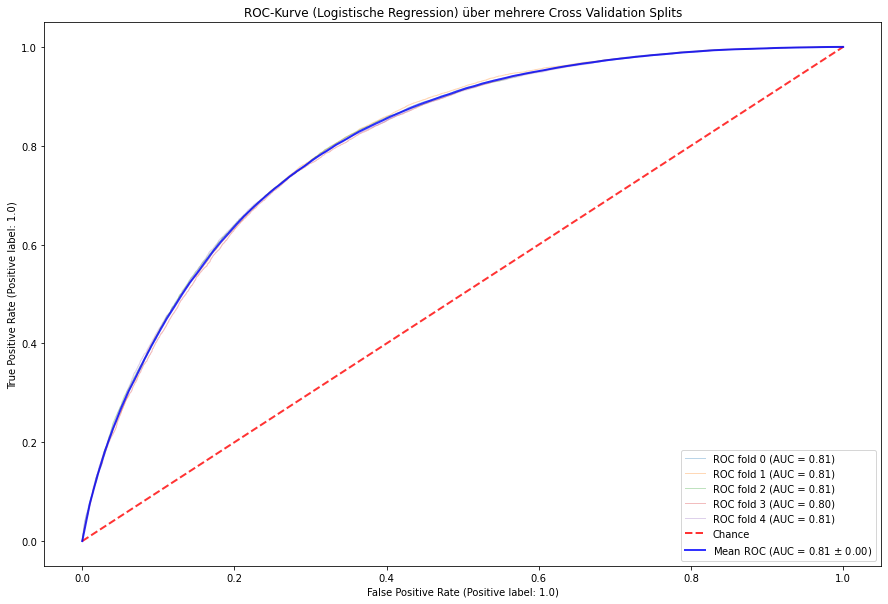

In [202]:
plot_roc_cv(logreg_grid_best, kf5, x_ou_combi_mm, y_ou_combi)

##### Quellen 

Interpretation der ROC-Kurve: *https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077*

## 5.2 Evaluation - Random Forest Classifier

### 5.2.1 Konfusionsmatrix über alle Cross Validation Splits (RFC) 

#### 5.2.1.1 Kombiniertes Over-/ Undersampling

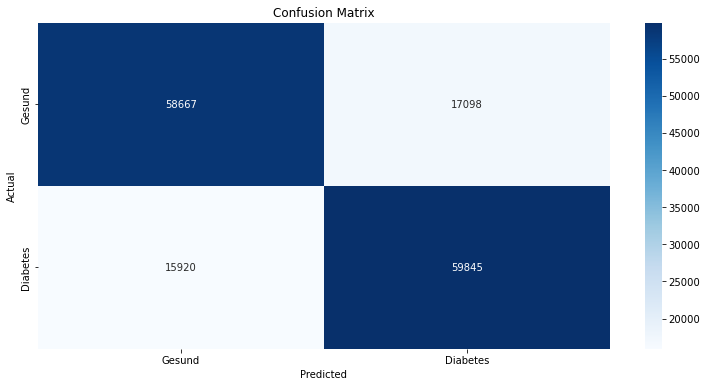

In [313]:
actual_classes_rfc, predicted_classes_rfc = cross_val_predict(rfc_overunder, kf5, x_ou_combi, y_ou_combi)
plot_confusion_matrix(actual_classes_rfc, predicted_classes_rfc, ['Gesund', 'Diabetes'])

#### 5.2.1.2 SMOTE-Oversampling

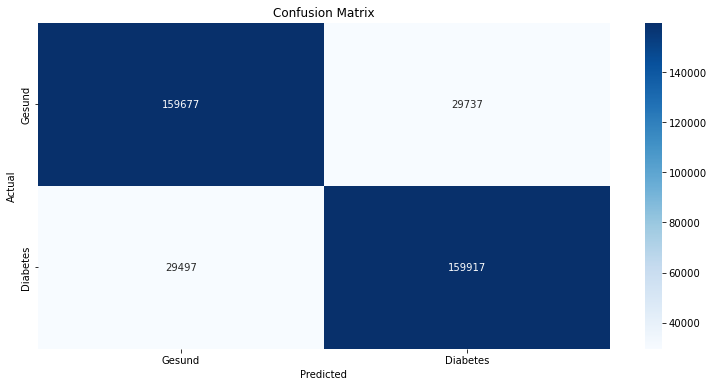

In [314]:
actual_classes_rfc_, predicted_classes_rfc_ = cross_val_predict(rfc_overunder, kf5, x_smote, y_smote)
plot_confusion_matrix(actual_classes_rfc_, predicted_classes_rfc_, ['Gesund', 'Diabetes'])

### 5.2.2 Klassifikationsmessgrößen (RFC)

#### 5.2.2.1 Accuracy (RFC)

In [302]:
rfc_acc = accuracy_score(actual_classes_rfc, predicted_classes_rfc)
rfc_acc

0.7826898963901537

#### 5.2.2.2 Precision/ Positive Predictive Value (RFC) 

In [303]:
rfc_prec = precision_score(actual_classes_rfc, predicted_classes_rfc)
rfc_prec

0.777701423644426

#### 5.2.2.3 Recall Score/ Sensitivität/ True Positive Rate (RFC)

In [304]:
rfc_recall = recall_score(actual_classes_rfc, predicted_classes_rfc)
rfc_recall

0.7916716161816142

#### 5.2.2.4 f1-Score (RFC)

In [305]:
rfc_f1 = f1_score(actual_classes_rfc, predicted_classes_rfc)
rfc_f1

0.7846243402162325

In [306]:
# Liste mit allen Scores des RandomForestClassifiers
rfc_scores = [rfc_acc, rfc_prec, rfc_recall, rfc_f1]

### 5.2.3 ROC-Kurve und AUC für mehrere Cross-Validation-Splits (RFC)

#### 5.2.3.1 Kombiniertes Over-/ Undersampling

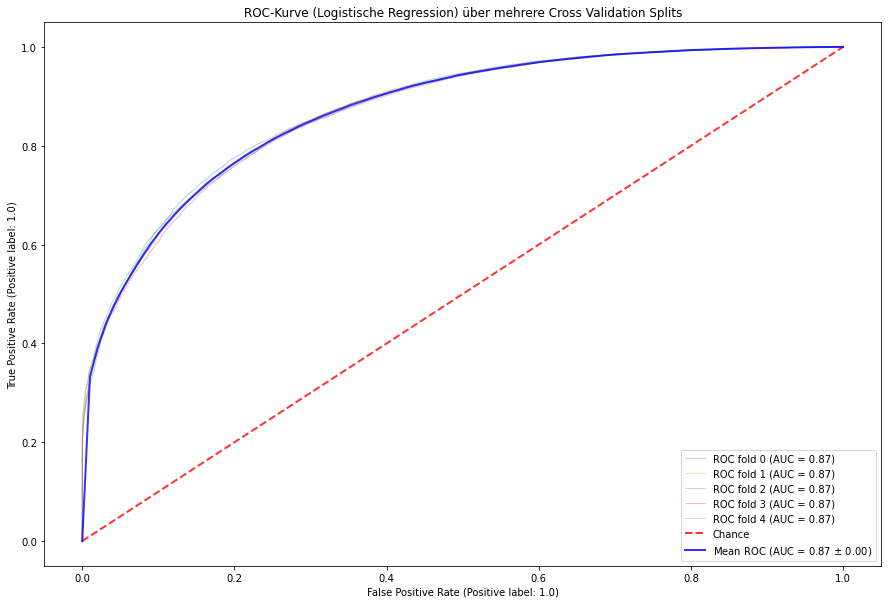

In [315]:
plot_roc_cv(rfc_overunder, kf5, x_ou_combi, y_ou_combi)

#### 5.2.3.2 SMOTE-Oversampling

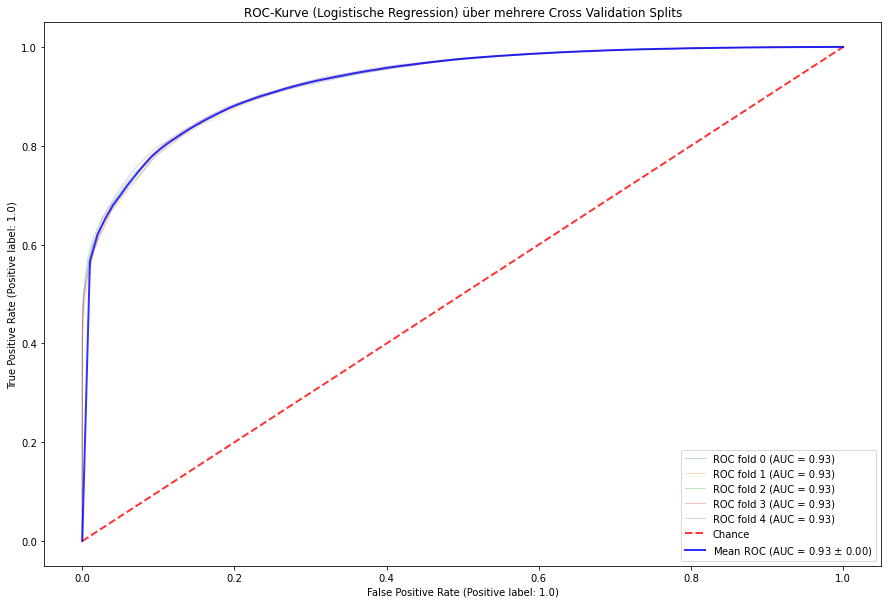

In [238]:
plot_roc_cv(rfc_overunder, kf5, x_smote, y_smote)

## 5.3 Evaluation - Support Vector Classifier 

### 5.3.1 Konfusionsmatrix über alle Cross Validation Splits (SVC)

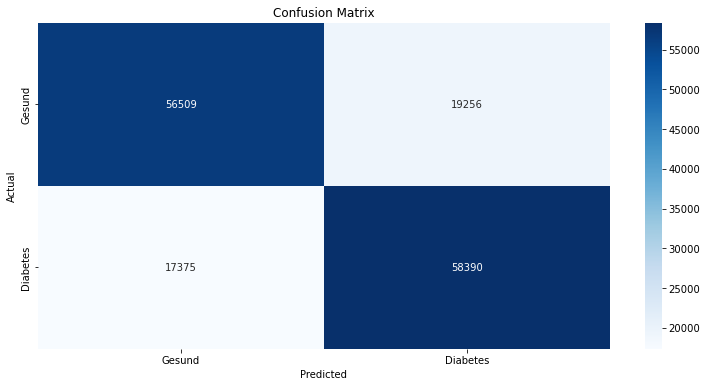

In [254]:
actual_classes_svc_oucomb, predicted_classes_svc_oucomb = cross_val_predict(svc_rscv_best_model, kf5, x_sel8_oucomb_mm, y_ou_combi)
plot_confusion_matrix(actual_classes_svc_oucomb, predicted_classes_svc_oucomb, ['Gesund', 'Diabetes'])

### 5.3.2 Klassifikationskenngrößen (SVC)

#### 5.2.2.1 Accuracy (SVC)

In [269]:
svc_acc = accuracy_score(actual_classes_svc_oucomb, predicted_classes_svc_oucomb)
svc_acc

0.7582590906091203

#### 5.3.2.2 Precision/ Positive Predictive Value (SVC) 

In [258]:
svc_prec = precision_score(actual_classes_svc_oucomb, predicted_classes_svc_oucomb)
svc_prec

0.7520026788244082

#### 5.3.2.3 Recall Score/ Sensitivität/ True Positive Rate (SVC)

In [259]:
svc_recall = recall_score(actual_classes_svc_oucomb, predicted_classes_svc_oucomb)
svc_recall

0.7706724740975385

#### 5.3.2.4 f1-Score (SVC)

In [261]:
svc_f1 = f1_score(actual_classes_svc_oucomb, predicted_classes_svc_oucomb)
svc_f1

0.7612231195937711

In [270]:
# Liste mit allen Scores aus der SVC
svc_scores = [svc_acc, svc_prec, svc_recall, svc_f1]

### 5.3.3 ROC-Kurve und AUC für mehrere Cross-Validation-Splits (SVC)

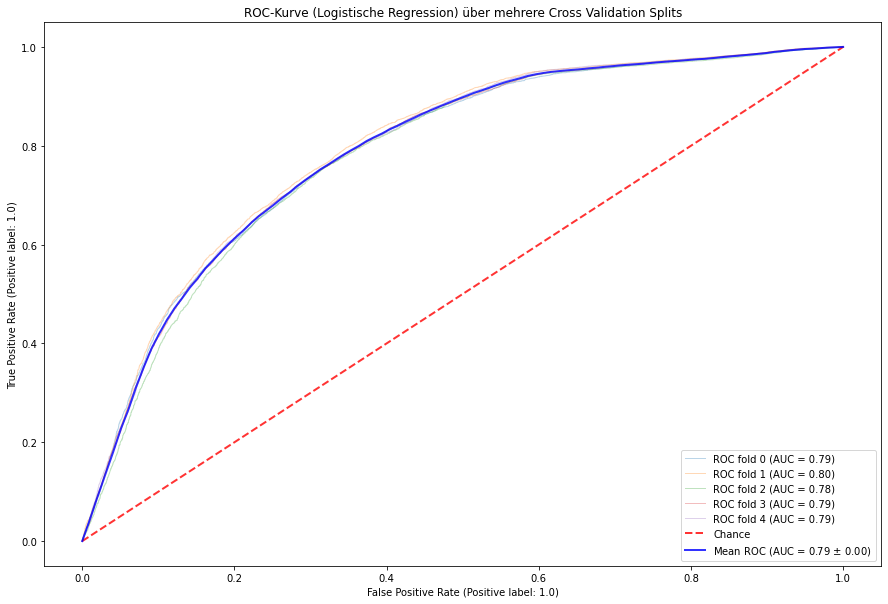

In [300]:
plot_roc_cv(svc_rscv_best_model, kf5, x_sel8_under_mm, y_randomunder)

##### Quellen

Evaluation einer Klassifikation (1): *https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226*

Evaluation einer Klassifikation (2): *https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-models-e2f0d8009d69*

Evaluation einer Klassifikation (3): *https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/#:~:text=Metrics%20like%20accuracy%2C%20precision%2C%20recall,in%20evaluating%20the%20model%20performance.*

Evaluation eines unbalancierten Datensatzes (1): *https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/#:~:text=The%20F%2DMeasure%20is%20a,by%20a%20coefficient%20called%20beta.*

Evaluation eines unbalancierten Datensatzes (2): *https://medium.com/datasciencestory/performance-metrics-for-evaluating-a-model-on-an-imbalanced-data-set-1feeab6c36fe*

# 6. Modelling - Deep Learning

## 6.1 Deep Learning mit MPLClassifier aus sklearn

### 6.1.1 Erste Betrachtung mit RandomizedSearchCV

Im Folgenden wird eine RandomizedSearchCV zum Hyperparametertuning bezüglich eines MLPClassifiers aus sklearn implementiert. Hierzu wurden aus der sklearn-Dokumentation **interessante Parameter mit zugehörigen Werten** ausgewählt. Die erste Durchführung des Hyperparametertunings, mit Tupeln mit jeweils drei Werten für die **'hidden_layer_sizes'**, wurde vorzeitig abgebrochen, da es hier zu längeren Ladezeiten und Overfitting, bei ähnlichen Scores kam. Hier stehen jetzt nur noch **Tupel mit zwei Werten** zur Auswahl. Als Optimizer wird nur der Standardwert 'adam' betrachtet. Lediglich für die **Learningrate** der Optimierungsfunktion stehen ein paar Werte zur Auswahl. Darüber hinaus wurden die Werte für **'max_iter' recht hoch** angesetzt, da es hier mit kleineren Werten bei der vorherigen, abgebrochenen RandomizedSearchCV zu Warnungen kam. 

Aufgrund von **erwarteten langen Ladezeiten** für das neuronale Netzwerk werden für die RandomizedSearchCV im Folgenden nur die **undersampleten Features** verwendet. Die direkte Wahl des **balancierten Datensatzes** soll zudem verhindern, dass das Hyperparametertuning zuerst mit schlechten Ergebnissen durchgeführt wird, und das Modell im Anschluss daran nochmals mit den balancierten Daten durchgeführt werden muss. Die Wahl des Undersamplings wird, neben der deutlich reduzierten Rechenzeit, zusätzlich dadurch bestätigt, dass es bei den Machine Learning-Algorithmen keine signifikante Verschlechterung im Vergleich zum Oversampling bzw. zum gemischten Over-/ und Undersampling gab. 

Darüber hinaus kann es ein wichtiger Schritt zur Verbesserung eines neuronalen Netzwerkes sein, die Daten vor der Eingabe in das Modell zu skalieren. Aus diesem Grund werden bereits hier die mit dem **MinMaxScaler skalierten Features** verwendet. 

##### Quellen 

Scaling von Daten vor der Durchführung eines neuronalen Netzwerkes: *https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/*

sklearn-Dokumentation (MLP-Classifier): *https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html*

In [20]:
# Auswahl von Parametern zum Hyperparamertuning für den MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(150, 50), (100,50), (50,25)],
    'max_iter': [400, 500],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [1e-3, 1e-4, 1e-5],
    'batch_size': [50, 100, 200]
}

# Initalisierung des Modells
mlp_rscv_model = MLPClassifier()

# Initialisierung einer RandoimzedSearchCV
randomized_mlp = RandomizedSearchCV(estimator=mlp_rscv_model, param_distributions=param_grid_mlp, n_iter=15, scoring=['f1', 'accuracy', 'precision', 'recall'], refit='recall', cv=kf5, verbose=5, return_train_score=True)

# Durchführung der RandomizedSearchCV
randomized_mlp.fit(x_randomunder_mm, y_randomunder)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END activation=tanh, batch_size=50, hidden_layer_sizes=(50, 25), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.734, test=0.736) f1: (train=0.745, test=0.748) precision: (train=0.714, test=0.717) recall: (train=0.779, test=0.782) total time=  40.6s
[CV 2/5] END activation=tanh, batch_size=50, hidden_layer_sizes=(50, 25), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.737, test=0.729) f1: (train=0.749, test=0.742) precision: (train=0.716, test=0.708) recall: (train=0.784, test=0.780) total time=  45.1s
[CV 3/5] END activation=tanh, batch_size=50, hidden_layer_sizes=(50, 25), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.737, test=0.728) f1: (train=0.742, test=0.733) precision: (train=0.728, test=0.719) recall: (train=0.757, test=0.747) total time= 1.1min
[CV 4/5] END activation=tanh, batch_size=50, hidden_layer_sizes=(50, 25), learning_rate_init=0.0001, max_iter=500; accuracy: (

C:\Users\Max\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, batch_size=200, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=500; accuracy: (train=0.757, test=0.714) f1: (train=0.765, test=0.723) precision: (train=0.742, test=0.699) recall: (train=0.789, test=0.749) total time= 1.9min
[CV 4/5] END activation=tanh, batch_size=200, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=500; accuracy: (train=0.753, test=0.715) f1: (train=0.765, test=0.733) precision: (train=0.727, test=0.700) recall: (train=0.807, test=0.769) total time= 1.6min
[CV 5/5] END activation=tanh, batch_size=200, hidden_layer_sizes=(50, 25), learning_rate_init=0.001, max_iter=500; accuracy: (train=0.752, test=0.722) f1: (train=0.763, test=0.728) precision: (train=0.735, test=0.701) recall: (train=0.792, test=0.757) total time= 1.6min
[CV 1/5] END activation=relu, batch_size=100, hidden_layer_sizes=(150, 50), learning_rate_init=1e-05, max_iter=400; accuracy: (train=0.732, test=0.733) f1: (train=0.744, test=0.745) preci

C:\Users\Max\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=200, hidden_layer_sizes=(150, 50), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.752, test=0.721) f1: (train=0.767, test=0.742) precision: (train=0.721, test=0.700) recall: (train=0.819, test=0.790) total time= 3.1min
[CV 5/5] END activation=relu, batch_size=200, hidden_layer_sizes=(150, 50), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.747, test=0.731) f1: (train=0.755, test=0.733) precision: (train=0.735, test=0.715) recall: (train=0.775, test=0.752) total time= 2.3min
[CV 1/5] END activation=tanh, batch_size=200, hidden_layer_sizes=(100, 50), learning_rate_init=0.0001, max_iter=400; accuracy: (train=0.734, test=0.737) f1: (train=0.745, test=0.749) precision: (train=0.714, test=0.718) recall: (train=0.780, test=0.783) total time=  33.3s
[CV 2/5] END activation=tanh, batch_size=200, hidden_layer_sizes=(100, 50), learning_rate_init=0.0001, max_iter=400; accuracy: (train=0.737, test=0.729) f1: (train=0.748, test=0.741

[CV 5/5] END activation=relu, batch_size=100, hidden_layer_sizes=(100, 50), learning_rate_init=0.0001, max_iter=500; accuracy: (train=0.742, test=0.732) f1: (train=0.748, test=0.733) precision: (train=0.734, test=0.718) recall: (train=0.762, test=0.748) total time= 2.0min


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=MLPClassifier(), n_iter=15,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'batch_size': [50, 100, 200],
                                        'hidden_layer_sizes': [(150, 50),
                                                               (100, 50),
                                                               (50, 25)],
                                        'learning_rate_init': [0.001, 0.0001,
                                                               1e-05],
                                        'max_iter': [400, 500]},
                   refit='recall', return_train_score=True,
                   scoring=['f1', 'accuracy', 'precision', 'recall'],
                   verbose=5)

In [25]:
# Initialisieren des besten Modells aus der RandomizedSearchCV
mlp_rscv_best = randomized_mlp.best_estimator_

# Ausgabe der besten Parameters und dem besten recall-Wert
print(f'Die besten Ergebnisse beim MLPClassfier wurden mit den Parameters {randomized_mlp.best_params_} und einem recall-Wert von {randomized_mlp.best_score_} erzielt.')

Die besten Ergebnisse beim MLPClassfier wurden mit den Parameters {'max_iter': 400, 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (100, 50), 'batch_size': 200, 'activation': 'tanh'} und einem recall-Wert von 0.7824438055118084 erzielt.


### 6.1.2 Nähere Betrachtung des bestes Modells aus der RandomizedSearchCV (MLP)

#### 6.1.2.1 Evaluation des besten Modells aus der RandomizedSearchCV (MLP)

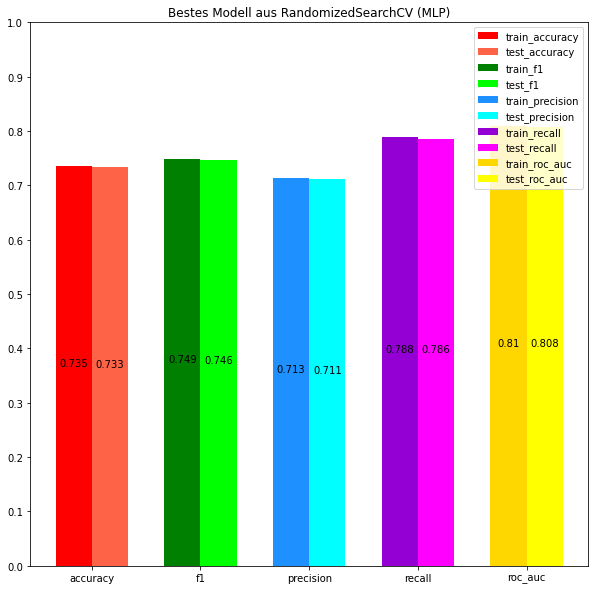

In [27]:
# Testen des angepassten Modells mit skalierten, undersampleten x- und y-Werten
cv_scores_logreg1 = cross_validate(mlp_rscv_best, x_randomunder_mm, y_randomunder, cv=kf5, scoring=['accuracy', 'f1', 'precision', 'recall','roc_auc'], return_train_score=True)

# visuelle Evaluation des besten Modells aus der RandomizedSearchCV
evaluate_model(cv_scores_logreg1, 'Bestes Modell aus RandomizedSearchCV (MLP)')

# 7. Evaluation - Deep Learning

# 7.1 Evaluation - MLP Classifier

### 7.1.1 Konfusionsmatrix über alle Cross Validation Splits (MLPClassifier)

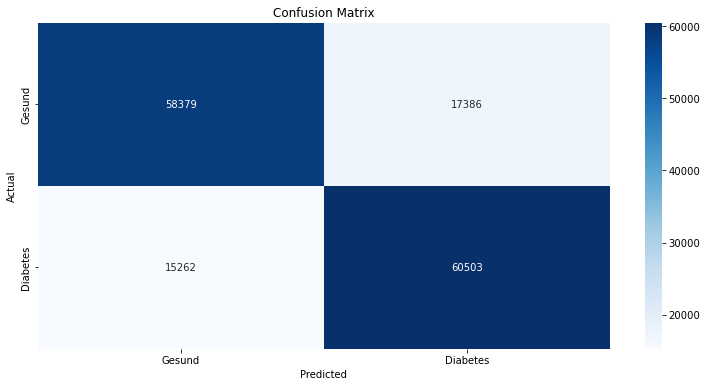

In [92]:
actual_classes_mlp, predicted_classes_mlp = cross_val_predict(mlp_rscv_model, kf5, x_ou_combi_mm, y_ou_combi)
plot_confusion_matrix(actual_classes_mlp, predicted_classes_mlp, ['Gesund', 'Diabetes'])

### 7.1.2 Evaluationskenngrößen (MLP)

#### 7.1.2.1 Accuracy (MLP)

In [272]:
mlp_acc = accuracy_score(actual_classes_mlp, predicted_classes_mlp)
mlp_acc

0.7845443146571636

#### 7.1.2.2 Precision/ Positive Predictive Value (MLP) 

In [273]:
mlp_prec = precision_score(actual_classes_mlp, predicted_classes_mlp)
mlp_prec

0.776784911861752

#### 7.1.2.3 Recall Score/ Sensitivität/ True Positive Rate (SVC)

In [275]:
mlp_recall = recall_score(actual_classes_mlp, predicted_classes_mlp)
mlp_recall

0.7985613409885831

#### 7.1.2.4 f1-Score (MLP)

In [274]:
mlp_f1 = f1_score(actual_classes_mlp, predicted_classes_mlp)
mlp_f1

0.7875226157470682

In [276]:
# Liste mit allen Scores aus MLP
mlp_scores = [mlp_acc, mlp_prec, mlp_recall, mlp_f1]

### 7.1.3 ROC-Kurve und AUC für mehrere Cross-Validation Splits (MLP)

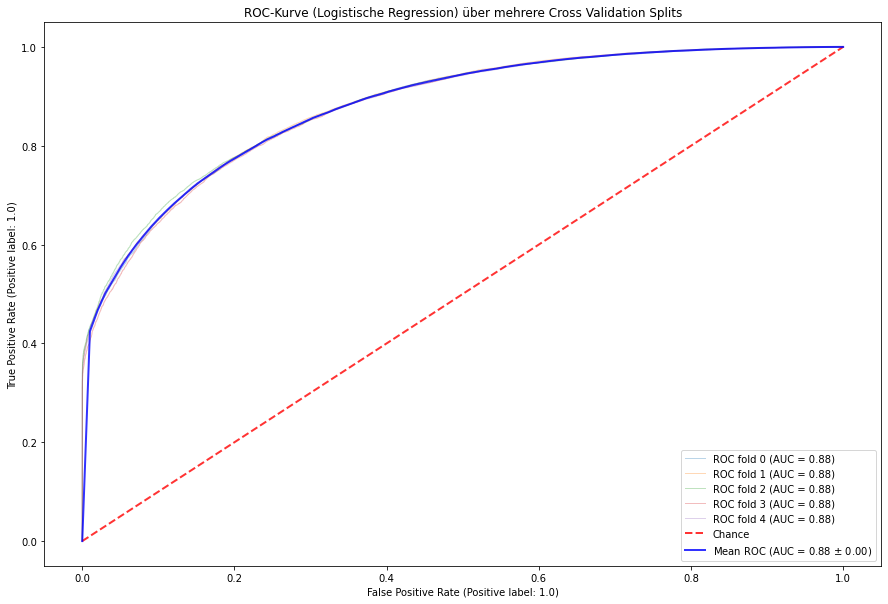

In [111]:
plot_roc_cv(mlp_rscv_model, kf5, x_ou_combi_mm, y_ou_combi)

# 8. Evalution

## 8.1 Vergleich der Evaluationskenngrößen aller Modelle

### 8.1.1 Visuelle Darstellung der Ergebnisse

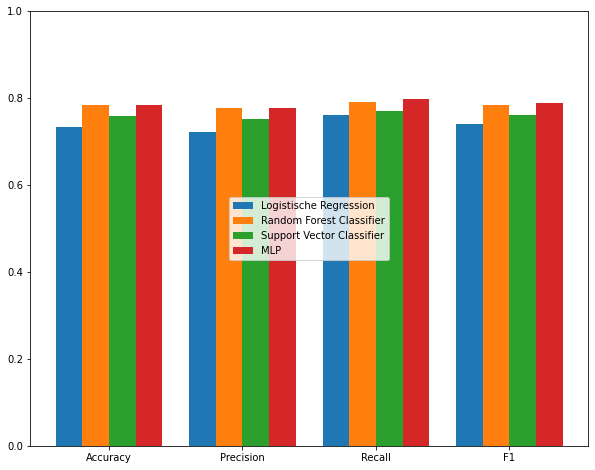

In [319]:
plt.figure(figsize=([10, 8]))

barwidth = 0.20

r1 = np.arange(len(logreg_scores))
r2 = [x + barwidth for x in r1]
r3 = [x + barwidth for x in r2]
r4 = [x + barwidth for x in r3]

plt.bar(r1, logreg_scores, width=barwidth, label='Logistische Regression')
plt.bar(r2, rfc_scores, width=barwidth, label='Random Forest Classifier')
plt.bar(r3, svc_scores, width=barwidth, label='Support Vector Classifier')
plt.bar(r4, mlp_scores, width=barwidth, label='MLP')

labels = ['Accuracy', 'Precision', 'Recall', 'F1']
plt.xticks(ticks=[r + (barwidth*1.5) for r in range(len(logreg_scores))], labels=labels)
plt.legend(loc='center')
plt.ylim(0,1)

plt.show()

### 8.1.2 Interpretation der Ergebnisse

##### Anmerkung 

Die obige Abbildung liefert eine **übersichtliche Darstellung der wichtigsten Scores**, die in den vier verwendeten Modellen erreicht wurden. Vor der Interpretation muss allerdings erwähnt werden, dass bei den Modellen **unterschiedliche Daten** verwendet wurden. So wurde beispielsweise beim **Support Vector Classifier**, um Rechenzeit einzusparen, das zweite **Feature Set** benutzt, welches nur noch 8 der ursprünglich 21 Features umfasst. Bei der Support Vector Classification wurde hierzu keine Sensitivitätsanalyse durchgeführt. Allerdings ist in Kapitel 4.1.4.3 zu sehen, dass die Verwendung dieses Feature Sets das Modell nur geringfügig verschlechterte. Bei der **logistischen Regression** sowie beim **neuronalen Netzwerk** wurden jeweils die **kombinierten over- bzw. undersampleten Features**, die **anschließened mit dem MinMaxScaler normalisiert** wurden, verwendet. Um die Ergebnisse hier besser vergleichen zu können, wurden auch beim **RandomForestClassifier** die **kombinierten over- bzw. undersampleten Werte** verwendet, obwohl mit den reinen SMOTE-Oversampling-Werten noche in besseres Ergebnis erzielt werden konnte. Die hier vewendeten Werte wurden allerdings vorher nicht skaliert. Das **beste erzielte Ergebnis** ist in **Kapitel 4.3.2.3** zu sehen. Eine bessere Vergleichbarkeit des Support Vector Classifiers mit den anderen Modellen durch die Verwendung des vollständigen, over- bzw. undersampleten Datensatzes wäre hier schön, war aber aus zeittechnischen Gründen leider nicht realisierbar.

##### Interpretation

Vergleicht man in der obigen Abbildung die vier farblich gekennzeichneten Modelle, so wird deutlich, dass der **Random Forest Classifier und der MLPClassifier** (neuronales Netzwerk) hier ungefähr gleich gut abschneiden, und die besten Ergebnisse in Bezug auf den vorliegenden Datensatz erzielen können. Allerdings muss man im Hinterkopf behalten, dass beim **RandomForestClassifier** der **Rechenaufwand geringer** ist, und durch die Verwendung des reinen Oversampling-Datensatzes hier **nochmals deutlich bessere Ergebnisse** erzielt werden können. Aus diesem Grund stellt der Random Forest Classifier hier vorerst das bessere und unkompliziertere Modell dar.

Die **dritt besten Ergebnisse** laut der Abbildung können mit dem **Support Vector Classifier** erzielt werden, und es ist unklar, ob man diese Ergebnisse nicht, durch die Verwendung eines größeren Datensatzes, noch weiter steigern könnte. Allerdings sind die **Rechenzeiten** beim vorliegenden Datensatz so **extrem lange**, dass das Modell, beispielsweise im Vergleich zum RandomForestClassifier, **nicht als gut** einzustufen ist. Obwohl die **logistische Regression** hier etwas **schlechtere Ergebnisse** erzielt, hat sie ihre Vorteile in der **unkomplizierten Implementierung**, sowie dem **geringen Rechenaufwand** und ist alles in allem sogar **über der Support Vector Classification** einzustufen. 

In [316]:
# Ausblick
# SVC mit ganzem Datensatz
# Sequential
# Optimierung der Feature Selection
# Suchen neuer Features im großen Datensatz

# 9. Quellenverzeichnis